## Supplementary: Parameter Recovery

This notebook covers the parameter recovery of the models.

Models will be tested in this notebook are M1, M2, M4, M5, and M7 from the main notebook. 

```
M1: A basic full model
HDDM(data, include = [‘z’, ‘sv’, ‘sz’, ‘st’])

M2: Full DDM model with drift rate varying.
HDDM(data, depends_on ={‘v’: ‘conf’}, include =[‘z’, ‘sv’, ‘sz’, ‘st’])


M4: A regressor version of M2

HDDMRegressor(data,  
                             "v ~ C(conf, Treatment('LC'))", 
                            group_only_regressors=False, 
                            keep_regressor_trace=True,
                            include =[‘z’, ‘sv’, ‘sz’, ‘st’])

M5: A model very close to the original model in Cavanagh et al. 2011 but with all data instead of grouped data.

HDDMRegressor(data[data['dbs'] == 0], 
                             "a ~ theta:C(conf, Treatment('LC'))", 
                             group_only_regressors=False
                             keep_regressor_trace=True,
                             depends_on={'v': 'conf'}, 
                             include =[‘z’, ‘sv’, ‘sz’, ‘st’])


M7: An improve version of M5
a_reg = {'model': "a ~ theta:C(conf, Treatment('LC')):C(dbs, Treatment('0'))", 'link_func': lambda x: x}
v_reg = {'model': "v ~ C(conf, Treatment('LC'))", 'link_func': lambda x: x}
reg_descr = [a_reg, v_reg]

HDDMRegressor(data, 
                             reg_descr, 
                             group_only_regressors=False, 
                             keep_regressor_trace=True,
                             include =[‘z’, ‘sv’, ‘sz’, ‘st’])
```

To be closer to the real data, the number of subjects and trial are set similar to the original paper

In [1]:
# check which python is in use.
import sys
print('Notebook is running:', sys.executable)

# further check your python version
from platform import python_version

print('The current HDDM version is', python_version())

# If you are sure that conda is installed, also check the package that install
#!conda list  # list the conda

import hddm, IPython, kabuki, pymc
import numpy as np
import pandas as pd
import seaborn as sns
print('The current HDDM version is', hddm.__version__) # 0.8.0
print('The current Kabuki version is', kabuki.__version__) # 0.6.3
print('The current PyMC version is', pymc.__version__) # 2.3.8

# Warning:`IPython.parallel` package has been deprecated since IPython 4.0. 
print('The current IPython version is', IPython.__version__) 

print('The current Numpy version is', np.__version__) 

print('The current Pandas version is', pd.__version__)

print('The current seaborn version is', sns.__version__)

Notebook is running: /opt/conda/bin/python
The current HDDM version is 3.7.6
The current HDDM version is 0.8.0
The current Kabuki version is 0.6.3
The current PyMC version is 2.3.8
The current IPython version is 7.15.0
The current Numpy version is 1.19.4
The current Pandas version is 1.0.5
The current seaborn version is 0.11.1


/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
%matplotlib inline

# Preparation
import os, hddm, time, csv
import glob
import datetime
from datetime import date

import pymc as pm
import hddm
import kabuki

import arviz as az
import numpy as np
import pandas as pd
import feather
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrix

from p_tqdm import p_map
from functools import partial

# set the color of plots
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmykw')

### Parameters for simulation (all)

Here are the parameters for all simulation: number of participants, total number of trials.

In [3]:
n_subj = 14
n_trials_total = 320
p_outliers = .05

### M1: A full DDM

Here because we used fixed parameter values, the noise will added by `kabuki.generate._add_noise()` function, which will used the parameter value as the location parameter and $0.1$ as the scale parameter. 

In [42]:
n_trials_cond = 320/1

params_m1 = {'v':2., 'a':1.5, 't':.4, 'sv':0, 'z':.5, 'sz':0, 'st':0}

sim_df_m1, sim_params_m1 = hddm.generate.gen_rand_data(params_m1,
                                                            size=n_trials_cond,
                                                            subjs=n_subj)

# add conf and dbs
# sim_df_m2.rename(columns = {'condition': 'conf'}, inplace = True)
sim_df_m1['conf'] = np.tile(["HC", "HC", "LC", "LC"], int(len(sim_df_m1)/4))
sim_df_m1['dbs'] = np.tile([0, 1, 0, 1], int(len(sim_df_m1)/4))
sim_df_m1['theta'] = np.random.normal(0, 1, len(sim_df_m1))
sim_df_m1 = sim_df_m1[['subj_idx', 'conf', 'dbs', 'rt', 'response', 'theta']]

sim_df_m1_full = sim_df_m1.copy()
sim_df_m1_full['v'] = None
sim_df_m1_full['a'] = None
sim_df_m1_full['t'] = None
sim_df_m1_full['z'] = None
sim_df_m1_full['sv'] = None
sim_df_m1_full['st'] = None
sim_df_m1_full['sz'] = None

for subj in range(n_subj):
    sim_df_m1_full['v'].loc[(sim_df_m1_full['subj_idx'] == subj)] = sim_params_m1[subj]['v']
    sim_df_m1_full['a'].loc[(sim_df_m1_full['subj_idx'] == subj)] = sim_params_m1[subj]['a']
    sim_df_m1_full['t'].loc[(sim_df_m1_full['subj_idx'] == subj)] = sim_params_m1[subj]['t']
    sim_df_m1_full['z'].loc[(sim_df_m1_full['subj_idx'] == subj)] = sim_params_m1[subj]['z']
    sim_df_m1_full['sv'].loc[(sim_df_m1_full['subj_idx'] == subj)] = sim_params_m1[subj]['sv']
    sim_df_m1_full['st'].loc[(sim_df_m1_full['subj_idx'] == subj)] = sim_params_m1[subj]['st']
    sim_df_m1_full['sz'].loc[(sim_df_m1_full['subj_idx'] == subj)] = sim_params_m1[subj]['sz']
    

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [106]:
sim_df_m1_full.columns

Index(['subj_idx', 'conf', 'dbs', 'rt', 'response', 'theta', 'v', 'a', 't',
       'z', 'sv', 'st', 'sz'],
      dtype='object')

### M2: A full DDM with drift rate depends on one DV

In [107]:
%%time
n_trials_cond = 320/2

params_m2 = {'HC': {'v':2.,  'a':1.5, 't':.4, 'sv':0, 'z':.5, 'sz':0, 'st':0},
             'LC' : {'v':3.2, 'a':1.5, 't':.4, 'sv':0, 'z':.5, 'sz':0, 'st':0}}

sim_df_m2, sim_params_m2 = hddm.generate.gen_rand_data(params_m2,
                                                            size=n_trials_cond,
                                                            subjs=n_subj)
# add conf and dbs
sim_df_m2.rename(columns = {'condition': 'conf'}, inplace = True)
sim_df_m2['dbs'] = np.tile([0,1], int(len(sim_df_m2)/2))
sim_df_m2['theta'] = np.random.normal(0, 1, len(sim_df_m2))
sim_df_m2 = sim_df_m2[['subj_idx', 'conf', 'dbs', 'rt', 'response', 'theta']]

sim_df_m2_full = sim_df_m2.copy()
sim_df_m2_full['v'] = None
sim_df_m2_full['a'] = None
sim_df_m2_full['t'] = None
sim_df_m2_full['z'] = None
sim_df_m2_full['sv'] = None
sim_df_m2_full['st'] = None
sim_df_m2_full['sz'] = None

for subj in range(n_subj):
    sim_df_m2_full['v'].loc[(sim_df_m2_full['conf'] == "HC") & (sim_df_m2_full['subj_idx'] == subj)] = sim_params_m2['HC'][subj]['v']
    sim_df_m2_full['v'].loc[(sim_df_m2_full['conf'] == "LC") & (sim_df_m2_full['subj_idx'] == subj)] = sim_params_m2['LC'][subj]['v']
    sim_df_m2_full['a'].loc[(sim_df_m2_full['conf'] == "HC") & (sim_df_m2_full['subj_idx'] == subj)] = sim_params_m2['HC'][subj]['a']
    sim_df_m2_full['a'].loc[(sim_df_m2_full['conf'] == "LC") & (sim_df_m2_full['subj_idx'] == subj)] = sim_params_m2['LC'][subj]['a']
    sim_df_m2_full['t'].loc[(sim_df_m2_full['conf'] == "HC") & (sim_df_m2_full['subj_idx'] == subj)] = sim_params_m2['HC'][subj]['t']
    sim_df_m2_full['t'].loc[(sim_df_m2_full['conf'] == "LC") & (sim_df_m2_full['subj_idx'] == subj)] = sim_params_m2['LC'][subj]['t']
    sim_df_m2_full['z'].loc[(sim_df_m2_full['conf'] == "HC") & (sim_df_m2_full['subj_idx'] == subj)] = sim_params_m2['HC'][subj]['z']
    sim_df_m2_full['z'].loc[(sim_df_m2_full['conf'] == "LC") & (sim_df_m2_full['subj_idx'] == subj)] = sim_params_m2['LC'][subj]['z']
    sim_df_m2_full['sv'].loc[(sim_df_m2_full['conf'] == "HC") & (sim_df_m2_full['subj_idx'] == subj)] = sim_params_m2['HC'][subj]['sv']
    sim_df_m2_full['sv'].loc[(sim_df_m2_full['conf'] == "LC") & (sim_df_m2_full['subj_idx'] == subj)] = sim_params_m2['LC'][subj]['sv']
    sim_df_m2_full['st'].loc[(sim_df_m2_full['conf'] == "HC") & (sim_df_m2_full['subj_idx'] == subj)] = sim_params_m2['HC'][subj]['st']
    sim_df_m2_full['st'].loc[(sim_df_m2_full['conf'] == "LC") & (sim_df_m2_full['subj_idx'] == subj)] = sim_params_m2['LC'][subj]['st']
    sim_df_m2_full['sz'].loc[(sim_df_m2_full['conf'] == "HC") & (sim_df_m2_full['subj_idx'] == subj)] = sim_params_m2['HC'][subj]['sz']
    sim_df_m2_full['sz'].loc[(sim_df_m2_full['conf'] == "LC") & (sim_df_m2_full['subj_idx'] == subj)] = sim_params_m2['LC'][subj]['sz']
    
sim_df_m2_full = sim_df_m2_full[sim_df_m1_full.columns]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


CPU times: user 428 ms, sys: 0 ns, total: 428 ms
Wall time: 426 ms


In [108]:
sim_df_m2_full

subj_idx conf  dbs        rt  response     theta        v        a  \
0            0   HC    0  0.431897       1.0  0.231914  1.93602  1.55971   
1            0   HC    1  0.745754       0.0 -0.092580  1.93602  1.55971   
2            0   HC    0  0.724806       1.0  0.949240  1.93602  1.55971   
3            0   HC    1  0.981294       1.0 -0.302295  1.93602  1.55971   
4            0   HC    0  0.508579       1.0  0.127929  1.93602  1.55971   
...        ...  ...  ...       ...       ...       ...      ...      ...   
4475        13   LC    1  0.478953       1.0  0.282991  3.15335  1.50287   
4476        13   LC    0  0.777479       1.0  0.070004  3.15335  1.50287   
4477        13   LC    1  0.684840       1.0  0.574238  3.15335  1.50287   
4478        13   LC    0  0.683354       1.0 -0.947395  3.15335  1.50287   
4479        13   LC    1  1.159144       1.0  0.081692  3.15335  1.50287   

             t         z         sv         st         sz  
0     0.360111  0.520087   0.049548  0.0587423  0.0732575  
1     0.360111  0.520087   0.049548  0.0587423  0.0732575  
2     0.360111  0.520087   0.049548  0.0587423  0.0732575  
3     0.360111  0.520087   0.049548  0.0587423  0.0732575  
4     0.360111  0.520087   0.049548  0.0587423  0.0732575  
...        ...       ...        ...        ...        ...  
4475     0.462  0.638187  0.0431842   0.224833  0.0683471  
4476     0.462  0.638187  0.0431842   0.224833  0.0683471  
4477     0.462  0.638187  0.0431842   0.224833  0.0683471  
4478     0.462  0.638187  0.0431842   0.224833  0.0683471  
4479     0.462  0.638187  0.0431842   0.224833  0.0683471  

[4480 rows x 13 columns]

In [102]:
tmp = sim_df_m1_full.groupby(['subj_idx','z']).size().reset_index().rename(columns={0:'count'})
tmp.iloc[:, 1].agg([np.mean, np.std])


mean    0.486513
std     0.106291
Name: z, dtype: float64

In [91]:
tmp.iloc[:, 1]

0     0.069895
1     0.099249
2     0.025982
3     0.070856
4     0.006636
5     0.014370
6     0.156837
7     0.001608
8     0.115097
9     0.019730
10    0.051458
11    0.045046
12    0.114105
13    0.164028
Name: sv, dtype: float64

In [ ]:
result = sim_df_m2_full.groupby(['conf','dbs'], as_index=False)['theta'].agg([np.mean, np.std])

### M4: A full DDM with drift rate has linear relation with one DV

In this model, we assume an within-subject relationship between different levels of the `conf`. to do that, we wil simulate the data individually. In each subject's data, we set the drift rate of one level is a linear combination of the other:

$$v_{i} = intercept + slope_{i}* conf$$

We also assume use the `treatment contrast` to specify our design matrix, so that $intercept $ is the mean `treatment condition` and $slope$ is the difference between the mean of `treatment condition` and `contrast condition`.

In `M4`, `M5`, and `M7`, we added the subject-level noise to $a$, $t$, $sv$, $st$, and $sz$. To make sure that these noise are the same as in the `M1` and `M2`, we used the default arugment in `gen_rand_data` from `kabuki/generate.py`, i.e., for $a$, $t$, and, $z$, `.1`; for $sv$, $st$, and $sz$, `.05`.

In [113]:
n_trials_cond = int(320/2)

# hyper parameters of the linear regresion
# need to be reconsidered in the future

intercept_mu = 2
intercept_sigma = 1

slope_mu = 1.2
slope_sigma = 0.6  

# params_m4 = []
sim_df_m4 = []
sim_params_m4 = []

for subj in range(n_subj):
    v_high = np.random.normal(intercept_mu, intercept_sigma)
    slope_tmp = np.random.normal(slope_mu, slope_sigma)
    v_low = v_high + slope_tmp
    
    params_m4_tmp = {'HC': {'v':v_high,  'a':1.5, 't':.4, 'sv':0, 'z':.5, 'sz':0, 'st':0},
                     'LC' : {'v':v_low, 'a':1.5, 't':.4, 'sv':0, 'z':.5, 'sz':0, 'st':0}}
    
    params_m4_tmp['HC']['a'] = params_m4_tmp['LC']['a'] = np.random.normal(1.5, 0.1)
    params_m4_tmp['HC']['t'] = params_m4_tmp['LC']['t'] = np.random.normal(0.4, 0.1)
    params_m4_tmp['HC']['z'] = params_m4_tmp['LC']['z'] = np.random.normal(0.5, 0.1)
    params_m4_tmp['HC']['sv'] = params_m4_tmp['LC']['sv'] = np.abs(np.random.normal(0., 0.05))
    params_m4_tmp['HC']['st'] = params_m4_tmp['LC']['st'] = np.abs(np.random.normal(0., 0.05))
    params_m4_tmp['HC']['sz'] = params_m4_tmp['LC']['sz'] = np.abs(np.random.normal(0., 0.05))
    
    sim_df_m4_tmp, sim_params_m4_tmp = hddm.generate.gen_rand_data(params_m4_tmp,
                                                                        size=n_trials_cond,
                                                                        subjs=1)
    # params_m4.append(params_m4_tmp)
    sim_df_m4_tmp.rename(columns = {'condition': 'conf'}, inplace = True)
    sim_df_m4_tmp['dbs'] = np.tile([0,1], n_trials_cond)
    sim_df_m4_tmp['theta'] = np.random.normal(0, 1, len(sim_df_m4_tmp))
    
    sim_df_m4_tmp['v'] = sim_params_m4_tmp['HC']['v']
    sim_df_m4_tmp['v'].loc[sim_df_m4_tmp['conf'] == 'LC'] = sim_params_m4_tmp['LC']['v']
    sim_df_m4_tmp['a'] = sim_params_m4_tmp['HC']['a']
    sim_df_m4_tmp['t'] = sim_params_m4_tmp['HC']['t']
    sim_df_m4_tmp['z'] = sim_params_m4_tmp['HC']['z']
    sim_df_m4_tmp['sv'] = sim_params_m4_tmp['HC']['sv']
    sim_df_m4_tmp['st'] = sim_params_m4_tmp['HC']['st']
    sim_df_m4_tmp['sz'] = sim_params_m4_tmp['HC']['sz']
    
    sim_df_m4.append(sim_df_m4_tmp)
    sim_params_m4.append(sim_params_m4_tmp)
    

sim_df_m4_full = pd.concat(sim_df_m4, names=['subj_idx'], keys=list(range(len(sim_df_m4))))
sim_df_m4_full.drop(['subj_idx'], axis=1, inplace=True)
sim_df_m4_full.reset_index(inplace=True) 
sim_df_m4_full.drop(['level_1'], axis=1, inplace=True)
# sim_df_m4.rename(columns = {'level_1':'trial'}, inplace = True)
sim_df_m4_full = sim_df_m4_full[sim_df_m1_full.columns]
sim_df_m4 = sim_df_m4_full[['subj_idx', 'conf', 'dbs', 'rt', 'response', 'theta']].copy()

# Check the data
sim_df_m4

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


subj_idx conf  dbs        rt  response     theta
0            0   HC    0  0.714680       1.0 -0.525055
1            0   HC    1  0.770647       1.0 -2.308951
2            0   HC    0  1.020569       1.0  0.299697
3            0   HC    1  1.233056       1.0 -0.208124
4            0   HC    0  1.223848       1.0  0.426260
...        ...  ...  ...       ...       ...       ...
4475        13   LC    1  0.799007       1.0  0.118425
4476        13   LC    0  0.732550       1.0  0.347248
4477        13   LC    1  0.584132       0.0 -0.399900
4478        13   LC    0  0.649625       1.0  0.855208
4479        13   LC    1  0.669415       1.0  1.238797

[4480 rows x 6 columns]

In [114]:
sim_df_m4_full

subj_idx conf  dbs        rt  response     theta         v         a  \
0            0   HC    0  0.714680       1.0 -0.525055  1.289752  1.444179   
1            0   HC    1  0.770647       1.0 -2.308951  1.289752  1.444179   
2            0   HC    0  1.020569       1.0  0.299697  1.289752  1.444179   
3            0   HC    1  1.233056       1.0 -0.208124  1.289752  1.444179   
4            0   HC    0  1.223848       1.0  0.426260  1.289752  1.444179   
...        ...  ...  ...       ...       ...       ...       ...       ...   
4475        13   LC    1  0.799007       1.0  0.118425  1.319758  1.288013   
4476        13   LC    0  0.732550       1.0  0.347248  1.319758  1.288013   
4477        13   LC    1  0.584132       0.0 -0.399900  1.319758  1.288013   
4478        13   LC    0  0.649625       1.0  0.855208  1.319758  1.288013   
4479        13   LC    1  0.669415       1.0  1.238797  1.319758  1.288013   

             t         z        sv        st        sz  
0     0.385517  0.512891  0.048692  0.046762  0.022334  
1     0.385517  0.512891  0.048692  0.046762  0.022334  
2     0.385517  0.512891  0.048692  0.046762  0.022334  
3     0.385517  0.512891  0.048692  0.046762  0.022334  
4     0.385517  0.512891  0.048692  0.046762  0.022334  
...        ...       ...       ...       ...       ...  
4475  0.527574  0.460043  0.074855  0.027131  0.022505  
4476  0.527574  0.460043  0.074855  0.027131  0.022505  
4477  0.527574  0.460043  0.074855  0.027131  0.022505  
4478  0.527574  0.460043  0.074855  0.027131  0.022505  
4479  0.527574  0.460043  0.074855  0.027131  0.022505  

[4480 rows x 13 columns]

### M5 & M7


#### Threshold $a$
In M5, we assume that DBS do not interact with the relation between theta and threshold, while in M7, we assume DBS has such effect. In both model, conflict level is interacting with theta. Note that in this relatively complicated design matrix, we will have two slopes for M5 (high_conf & low_conf) and four slopes for M7: high_conf:ON, low_conf:ON,  high_conf:OFF, low_conf:OFF. 

In M5:

$$a_{i} = intercept + slope_{i} * conf * theta$$

Where $i$ is the conflict level.

In M7:

$$a_{i,j} = intercept + slope_{i,j} * conf * dbs * theta$$

Where $i$ is the conflict level, $j$ is the DBS status.

#### Drift rate $v$

In M5, we modeled $v$ using `depends_on`, which is an between-subject approach. In M7, we used `regressor` function, which is the within-subject approch.

Given that brain activity `theta` are varying trial-by-trial, we need to simulate the data trial-by-trial. Thus, the simulation will be similar as PPC: first get the parameters and then generate only one datum, and iterate through all trials

#### First, get the parameter of theta

Here we will get the distribution of theta, hopefully it is a normal distribution

In [7]:
observed = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')

result = observed.groupby(['conf','dbs'], as_index=False)['theta'].agg([np.mean, np.std])
# groupby("a")["b"].agg([np.mean, np.std])
result

mean       std
conf dbs                    
HC   0    0.029230  0.998163
     1   -0.024845  0.996180
LC   0   -0.026052  1.003583
     1    0.023770  1.006609

#### $a$ for simulation

To get parameter $a$, we need `theta`.

Parameters for simulating M5's $a$:

$$theta_{HC} \sim N(-0.03, 1)$$
$$theta_{LC} \sim N(0.03, 1)$$

$$intercept \sim G(1.5, 0.1)$$
$$slope_{HC} \sim N(0.08, 0.02)$$
$$slope_{LC} \sim N(-0.02, 0.02)$$

Parameters for simulating M7's $a$:

$$theta_{ON, HC} \sim N(-0.03, 1)$$
$$theta_{OFF, HC} \sim N(0.03, 1)$$
$$theta_{ON, LC} \sim N(0.03, 1)$$
$$theta_{OFF, LC} \sim N(-0.03, 1)$$

$$intercept \sim G(1.5, 0.1)$$
$$slope_{ON, HC} \sim N(0.08, 0.02)$$
$$slope_{OFF, HC} \sim N(-0.07, 0.02)$$
$$slope_{ON, LC} \sim N(0.02, 0.02)$$
$$slope_{OFF, LC} \sim N(-0.02, 0.02)$$

#### $v$ for simulation
M5's $v$ is the same as in M2

M7's $v$ is the same as M4

In [115]:
%%time
# first, generate a matrix with all conditions

n_trials_cond = int(320/2)

sim_df_m5 = []
for subj in range(n_subj):
    
    ### for dbd ON:
    theta_hc = np.random.normal(-0.03, 1, n_trials_cond)
    tmp_df0 = pd.DataFrame(columns=['subj_idx','conf','dbs','theta'])
    tmp_df0['theta'] = theta_hc
    tmp_df0['subj_idx'] = subj
    tmp_df0['conf'] = 'HC'
    tmp_df0['dbs'] = np.repeat([0,1], n_trials_cond/2, axis=0)
    
    theta_lc  = np.random.normal(0.03, 1, n_trials_cond)
    tmp_df1 = pd.DataFrame(columns=['subj_idx','conf','dbs','theta'])
    tmp_df1['theta'] = theta_lc
    tmp_df1['subj_idx'] = subj
    tmp_df1['conf'] = 'LC'
    tmp_df1['dbs'] = np.repeat([0,1], n_trials_cond/2, axis=0)
            
    tmp_df_ls = [tmp_df0, tmp_df1]
    tmp_df = pd.concat(tmp_df_ls)
    tmp_df = tmp_df.sample(frac=1).reset_index(drop=True)
    
    # generate design matrix for a_on
    
    dm_tmp = pd.DataFrame(dmatrix("theta:C(conf, Treatment('LC'))", tmp_df))
    
    intercept_tmp = np.random.gamma(1.5, 0.75)
    slope_hc_tmp = np.random.normal(0.08, 0.02)
    slope_lc_tmp = np.random.normal(-0.02, 0.02)
    coef_tmp = [intercept_tmp, slope_hc_tmp, slope_lc_tmp]
    coef_tmp = pd.DataFrame(coef_tmp)
    
    tmp_df['a'] = np.dot(dm_tmp, coef_tmp)
    
    # get drift rate v
    v_high = 2.
    v_low = 3.2

    tmp_df['v'] = None
    tmp_df['v'].loc[tmp_df['conf']=='HC'] = v_high
    tmp_df['v'].loc[tmp_df['conf']=='LC'] = v_low
    
    # add noise to other parameters
    tmp_df['t'] = np.random.normal(0.4, 0.1, len(tmp_df))
    tmp_df['z'] = np.random.normal(0.5, 0.1, len(tmp_df))
    tmp_df['sv'] = np.random.normal(0, 0.05, len(tmp_df))
    tmp_df['sz'] = np.random.normal(0, 0.05, len(tmp_df))
    tmp_df['st'] = np.random.normal(0, 0.05, len(tmp_df))
    
    tmp_df['rt'] = None
    tmp_df['response'] = None
    
    for trial in range(len(tmp_df)):
        params_tmp = {'v': tmp_df['v'].iloc[trial],
                      'a': tmp_df['a'].iloc[trial],
                      't': tmp_df['t'].iloc[trial],
                      'sv': tmp_df['sv'].iloc[trial],
                      'z': tmp_df['z'].iloc[trial],
                      'sz': tmp_df['sz'].iloc[trial],
                      'st':tmp_df['st'].iloc[trial]
                     }

        sim_tmp, _ = hddm.generate.gen_rand_data(params_tmp,
                                              size=1,
                                              subjs=1)
        tmp_df['rt'].iloc[trial] = sim_tmp['rt'].iloc[0].copy()
        tmp_df['response'].iloc[trial] = sim_tmp['response'].iloc[0].copy()        
    
    sim_df_m5.append(tmp_df)

sim_df_m5_full = pd.concat(sim_df_m5, ignore_index=True)
sim_df_m5 = sim_df_m5_full.drop(['a', 'v'], axis=1).copy()
sim_df_m5_full = sim_df_m5_full[sim_df_m1_full.columns]
sim_df_m5 = sim_df_m5[['subj_idx', 'conf', 'dbs', 'rt', 'response', 'theta']]
sim_df_m5

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/hddm/generate.py:194: RuntimeWarning: invalid value encountered in true_divide
  size, range_[0], range_[1], dt)


CPU times: user 16.7 s, sys: 40.5 ms, total: 16.8 s
Wall time: 16.8 s


subj_idx conf  dbs        rt response     theta
0            0   HC    1   6.45164        0 -1.442542
1            0   HC    1   6.59585        0  0.131630
2            0   LC    0    6.5158        0  1.142664
3            0   LC    1   6.37637        0  0.106788
4            0   HC    0   6.51464        0  1.057933
...        ...  ...  ...       ...      ...       ...
4475        13   HC    1   6.32531        0 -0.193485
4476        13   HC    1  0.499044        1  0.918906
4477        13   LC    0   6.43662        0 -0.843211
4478        13   HC    0   6.53714        0  1.131136
4479        13   HC    0   6.44171        0  0.843920

[4480 rows x 6 columns]

In [112]:
sim_df_m5_full

subj_idx conf  dbs       rt response     theta    v         a         t  \
0            0   HC    1   6.1194        0  1.795692    2  2.287752  0.118426   
1            0   LC    1  6.32451        0 -0.764709  3.2  2.196251  0.337859   
2            0   LC    0  6.36619        0  0.449222  3.2  2.165152  0.366841   
3            0   LC    1  6.44433        0  0.733227  3.2  2.157876  0.447852   
4            0   LC    0   6.2993        0  1.342199  3.2  2.142276  0.297444   
...        ...  ...  ...      ...      ...       ...  ...       ...       ...   
4475        13   HC    1   6.3615        0 -1.075861    2  4.047446  0.377136   
4476        13   HC    1  6.39889        0  0.723503    2  4.230004  0.390001   
4477        13   LC    0  6.39736        0 -0.503657  3.2  4.175956  0.382717   
4478        13   LC    0  6.43115        0  1.297872  3.2  4.106719  0.448657   
4479        13   HC    1  6.29905        0 -0.890312    2  4.066271  0.308874   

             z        sv        st        sz  
0     0.544451 -0.076499 -0.043652  0.065460  
1     0.497707 -0.029296 -0.027352 -0.078816  
2     0.646937  0.020983  0.025949 -0.082663  
3     0.770409 -0.038275 -0.009876  0.011032  
4     0.349540  0.009520 -0.007761 -0.084944  
...        ...       ...       ...       ...  
4475  0.449819 -0.087681 -0.057888  0.027419  
4476  0.576749 -0.031697 -0.025214 -0.070498  
4477  0.407357 -0.063574 -0.037668  0.025419  
4478  0.424136 -0.032877  0.042197 -0.003403  
4479  0.412342 -0.070206  0.032180  0.008292  

[4480 rows x 13 columns]

In [104]:
%%time
# first, generate a matrix with all conditions

n_trials_cond = int(320/4)

sim_df_m7 = []
for subj in range(n_subj):
    theta_on_hc  = np.random.normal(-0.03, 1, n_trials_cond)
    tmp_df0 = pd.DataFrame(columns=['subj_idx','conf','dbs','theta'])
    tmp_df0['theta'] = theta_on_hc
    tmp_df0['subj_idx'] = subj
    tmp_df0['conf'] = 'HC'
    tmp_df0['dbs'] = 1
       
    theta_off_hc = np.random.normal( 0.03, 1, n_trials_cond)
    tmp_df1 = pd.DataFrame(columns=['subj_idx','conf','dbs','theta'])
    tmp_df1['theta'] = theta_off_hc
    tmp_df1['subj_idx'] = subj
    tmp_df1['conf'] = 'HC'
    tmp_df1['dbs'] = 0
    
    theta_on_lc  = np.random.normal( 0.03, 1, n_trials_cond)
    tmp_df2 = pd.DataFrame(columns=['subj_idx','conf','dbs','theta'])
    tmp_df2['theta'] = theta_on_lc
    tmp_df2['subj_idx'] = subj
    tmp_df2['conf'] = 'LC'
    tmp_df2['dbs'] = 1
    
    theta_off_lc = np.random.normal(-0.03, 1, n_trials_cond)
    tmp_df3 = pd.DataFrame(columns=['subj_idx','conf','dbs','theta'])
    tmp_df3['theta'] = theta_off_lc
    tmp_df3['subj_idx'] = subj
    tmp_df3['conf'] = 'LC'
    tmp_df3['dbs'] = 0
    
    tmp_df_ls = [tmp_df0, tmp_df1, tmp_df2, tmp_df3]
    tmp_df = pd.concat(tmp_df_ls)
    tmp_df = tmp_df.sample(frac=1).reset_index(drop=True)
    
    
    # generate design matrix for a
    
    dm_tmp = pd.DataFrame(dmatrix("theta:C(conf, Treatment('LC')):C(dbs, Treatment('0'))", tmp_df))
    
    intercept_tmp = np.random.gamma(1.5, 0.75)
    slope_on_hc_tmp = np.random.normal(0.08, 0.02)
    slope_off_hc_tmp = np.random.normal(-0.07, 0.02)
    slope_on_lc_tmp = np.random.normal(0.02, 0.02)
    slope_off_lc_tmp = np.random.normal(-0.02, 0.02)
    
    coef_tmp = [intercept_tmp, slope_on_hc_tmp, slope_off_hc_tmp, slope_on_lc_tmp, slope_off_lc_tmp]
    coef_tmp = pd.DataFrame(coef_tmp)

    tmp_df['a'] = np.dot(dm_tmp, coef_tmp)
    
    # get drift rate v
    
    v_intercept_mu = 2
    v_intercept_sigma = 1

    v_slope_mu = 1.2
    v_slope_sigma = 0.6  

    v_high = np.random.normal(v_intercept_mu, v_intercept_sigma)
    slope_tmp = np.random.normal(v_slope_mu, v_slope_sigma)

    v_low = v_high + slope_tmp

    tmp_df['v'] = None
    tmp_df['v'].loc[tmp_df['conf']=='HC'] = v_high
    tmp_df['v'].loc[tmp_df['conf']=='LC'] = v_low
    
    # add noise to other parameters
    tmp_df['t'] = np.random.normal(0.4, 0.1, len(tmp_df))
    tmp_df['z'] = np.random.normal(0.5, 0.1, len(tmp_df))
    tmp_df['sv'] = np.random.normal(0, 0.05, len(tmp_df))
    tmp_df['sz'] = np.random.normal(0, 0.05, len(tmp_df))
    tmp_df['st'] = np.random.normal(0, 0.05, len(tmp_df))
    
    tmp_df['rt'] = None
    tmp_df['response'] = None
    
    for trial in range(len(tmp_df)):
        params_tmp = {'v': tmp_df['v'].iloc[trial],
                      'a': tmp_df['a'].iloc[trial],
                      't': tmp_df['t'].iloc[trial],
                      'sv': tmp_df['sv'].iloc[trial],
                      'z': tmp_df['z'].iloc[trial],
                      'sz': tmp_df['sz'].iloc[trial],
                      'st':tmp_df['st'].iloc[trial]
                     }

        sim_tmp, _ = hddm.generate.gen_rand_data(params_tmp,
                                              size=1,
                                              subjs=1)
        tmp_df['rt'].iloc[trial] = sim_tmp['rt'].iloc[0].copy()
        tmp_df['response'].iloc[trial] = sim_tmp['response'].iloc[0].copy()        
    
    sim_df_m7.append(tmp_df)

# sim_df_m7 = pd.concat(sim_df_m7, ignore_index=True)
sim_df_m7_full = pd.concat(sim_df_m7, ignore_index=True)
sim_df_m7_full = sim_df_m7_full[sim_df_m1_full.columns]
sim_df_m7 = sim_df_m7_full[['subj_idx', 'conf', 'dbs', 'rt', 'response', 'theta']]
sim_df_m7

/opt/conda/lib/python3.7/site-packages/hddm/generate.py:194: RuntimeWarning: invalid value encountered in true_divide
  size, range_[0], range_[1], dt)


CPU times: user 16.3 s, sys: 0 ns, total: 16.3 s
Wall time: 16.3 s


subj_idx conf  dbs        rt response     theta
0            0   HC    0  0.508683        1  0.011376
1            0   HC    1   6.25997        0  1.086284
2            0   LC    0   6.41733        0  0.769176
3            0   LC    0  0.504603        1 -1.534576
4            0   HC    0  0.370377        0 -0.853040
...        ...  ...  ...       ...      ...       ...
4475        13   LC    0   6.33726        0  0.629322
4476        13   HC    1   6.47061        0 -0.739924
4477        13   HC    1   6.45109        0 -1.118915
4478        13   LC    0   6.54512        0 -0.187779
4479        13   HC    0   6.25383        0  1.221270

[4480 rows x 6 columns]

In [105]:
sim_df_m7_full

subj_idx conf  dbs     theta         a        v         t         z  \
0            0   HC    0  0.011376  0.300212  2.57229  0.504855  0.544003   
1            0   HC    1  1.086284  0.321331  2.57229  0.278016  0.628094   
2            0   LC    0  0.769176  0.237225  3.05706  0.417325  0.483105   
3            0   LC    0 -1.534576  0.422808  3.05706  0.467563  0.447410   
4            0   HC    0 -0.853040  0.222352  2.57229  0.378440  0.583680   
...        ...  ...  ...       ...       ...      ...       ...       ...   
4475        13   LC    0  0.629322  0.947180  2.97107  0.331960  0.500907   
4476        13   HC    1 -0.739924  0.963241   1.4364  0.463005  0.263062   
4477        13   HC    1 -1.118915  0.954557   1.4364  0.458825  0.580793   
4478        13   LC    0 -0.187779  0.990046  2.97107  0.545920  0.643042   
4479        13   HC    0  1.221270  1.080744   1.4364  0.252579  0.610524   

            sv        sz        st        rt response  
0     0.059918  0.051212 -0.030166  0.508683        1  
1     0.005567 -0.091060 -0.047048   6.25997        0  
2     0.058856 -0.036537  0.000751   6.41733        0  
3     0.012856  0.024222  0.000163  0.504603        1  
4     0.043420  0.064567  0.035223  0.370377        0  
...        ...       ...       ...       ...      ...  
4475 -0.008937  0.015109 -0.014814   6.33726        0  
4476 -0.008917 -0.041118  0.017535   6.47061        0  
4477 -0.021941  0.004691  0.024220   6.45109        0  
4478 -0.015816 -0.067853  0.006759   6.54512        0  
4479 -0.061036  0.029934  0.006423   6.25383        0  

[4480 rows x 13 columns]

In [10]:
print("Sim df for M1: ", sim_df_m1.shape)
print("Sim df for M2: ", sim_df_m2.shape)
print("Sim df for M4: ", sim_df_m4.shape)
print("Sim df for M5: ", sim_df_m5.shape)
print("Sim df for M7: ", sim_df_m7.shape)

Sim df for M1:  (4480, 6)
Sim df for M2:  (4480, 6)
Sim df for M4:  (4480, 6)
Sim df for M5:  (4480, 6)
Sim df for M7:  (4480, 6)


## Step 2: fit models with sim data

Here we will 

In [11]:
%%time

# define a function to run model in parallel

# M1: base model: full model
def run_m1(id, df=None, samples=None, burn=None, save_name="ms1"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, include=['z', 'sv', 'sz', 'st'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m


# M2: treat within-subj as between-subj: full model
def run_m2(id, df=None, samples=None, burn=None, save_name="ms2"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, include=['z', 'sv', 'st', 'sz'], 
                  depends_on={'v': 'conf'})
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M4: regression model (varying intercept and slope)
def run_m4(id, df=None, samples=None, burn=None, save_name="ms4"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id   
    m = hddm.HDDMRegressor(df,
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M5: regression model + theta as an additional predictor of `a`
def run_m5(id, df=None, samples=None, burn=None, save_name="ms5"): 
#     print('running model %i'%id);
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    m = hddm.HDDMRegressor(df,
                           "a ~ theta:C(conf, Treatment('LC'))",
                           depends_on={'v': 'conf'},
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

# M7: Regression for both parameters
def run_m7(id, df=None, samples=None, burn=None, save_name="ms7"): 
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    a_reg = {'model': "a ~ theta:C(conf, Treatment('LC')):C(dbs, Treatment('0'))", 'link_func': lambda x: x}
    v_reg = {'model': "v ~ C(conf, Treatment('LC'))", 'link_func': lambda x: x}
    reg_descr = [a_reg, v_reg]
    
    m = hddm.HDDMRegressor(df,
                           reg_descr,
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [12]:
samples = 2000
burn = 500
chains = 4
# test_mode = False

In [13]:
p_map(partial(run_m7, df=sim_df_m1, samples=samples,
                                               burn=burn,
                                               save_name = "save_name"),
                                     range(chains))

Adding these covariates:
['a_Intercept', "a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]", "a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[0]", "a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]", "a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[1]"]
Adding these covariates:
['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]
Adding these covariates:
['a_Intercept', "a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]", "a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[0]", "a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]", "a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[1]"]
Adding these covariates:
['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]
Adding these covariates:
['a_Intercept', "a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[0]", "a_theta:C(conf, Treatment('LC'))[LC]:C(dbs, Treatment('0'))[0]", "a_theta:C(conf, Treatment('LC'))[HC]:C(dbs, Treatment('0'))[1]

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Process ForkPoolWorker-7:
Process ForkPoolWorker-10:
Process ForkPoolWorker-8:
Process ForkPoolWorker-9:
Process ForkPoolWorker-6:


Process ForkPoolWorker-5:


Process ForkPoolWorker-15:


Process ForkPoolWorker-16:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/site-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()


In [16]:
%%time

## total time: 5h 19s when test_mode is False

## Step 1: run models in parallel
file_path = "/home/jovyan/hddm/temp/"

model_func = [run_m1, run_m2, run_m4, run_m5, run_m7]

sim_dfs = {'sim_df1': sim_df_m1, 
           'sim_df2': sim_df_m2, 
           'sim_df4': sim_df_m4, 
           'sim_df5': sim_df_m5, 
           'sim_df7': sim_df_m7}

m_keys = ["ms1",
          "ms2",
          "ms4",
          "ms5",
          "ms7"]

models = {"ms1": [], 
          "ms2": [], 
          "ms4": [], 
          "ms5": [], 
          "ms7": []}



CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs


In [17]:
for sim_name, data in sim_dfs.items():
# for sim in range(len(sim_dfs)):
#     data = sim_dfs[sim]
    
    for ii in range(len(model_func)):
        #print(model_func[ii])
        #print(model_name[ii])
        save_name = sim_name + "_" + m_keys[ii]
        file_full_path = file_path + "sim_df*" + m_keys[ii] + "_chain_*[!db]" 
        # print(file_full_path)
        file_names = glob.glob(file_full_path, recursive=False)
#         print(file_names)

        if file_names:
            for jj in file_names:
                print('current loading: ', jj, '\n')
                models[m_keys[ii]].append(hddm.load(jj))
        else:
            print('current estimating:', sim_name, m_keys[ii])
            models[m_keys[ii]] = p_map(partial(model_func[ii], df=data, samples=samples,
                                               burn=burn,
                                               save_name = save_name),
                                     range(chains))

current estimating: sim_df1 ms1


/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  0%                  ] 4 of 2000 complete in 0.5 sec[                  0%                  ] 3 of 2000 complete in 0.7 sec[                  0%                  ] 3 of 2000 complete in 0.8 sec[                  0%                  ] 3 of 2000 complete in 0.8 sec[                  0%                  ] 5 of 2000 complete in 1.2 sec[                  0%                  ] 4 of 2000 complete in 1.2 sec[                  0%                  ] 4 of 2000 complete in 1.3 sec[                  0%                  ] 6 of 2000 complete in 1.7 sec[                  0%                  ] 5 of 2000 complete in 1.7 sec[                  0%                  ] 5 of 2000 complete in 1.8 sec[                  0%                  ] 6 of 2000 complete in 2.2 sec  [                  0%                  ] 6 of 2000 complete in 2.4 sec[                  0%                  ] 6 of 2000 complete in 2.3 sec[                  0%                  ] 8 of 2000 complete in 2.7 sec[                

 [                  2%                  ] 42 of 2000 complete in 19.6 sec[                  1%                  ] 39 of 2000 complete in 19.7 sec[                  1%                  ] 39 of 2000 complete in 19.8 sec[                  2%                  ] 41 of 2000 complete in 20.0 sec[                  2%                  ] 40 of 2000 complete in 20.3 sec[                  2%                  ] 40 of 2000 complete in 20.3 sec[                  2%                  ] 44 of 2000 complete in 20.6 sec[                  2%                  ] 41 of 2000 complete in 20.8 sec[                  2%                  ] 43 of 2000 complete in 20.9 sec[                  2%                  ] 41 of 2000 complete in 20.9 sec[                  2%                  ] 45 of 2000 complete in 21.2 sec[                  2%                  ] 42 of 2000 complete in 21.4 sec[                  2%                  ] 42 of 2000 complete in 21.5 sec[                  2%                  ] 45 of 2000 complete in

 [-                 3%                  ] 78 of 2000 complete in 38.5 sec[-                 3%                  ] 76 of 2000 complete in 38.6 sec[-                 3%                  ] 73 of 2000 complete in 38.6 sec[-                 3%                  ] 79 of 2000 complete in 39.1 sec[-                 3%                  ] 77 of 2000 complete in 39.2 sec[-                 3%                  ] 74 of 2000 complete in 39.2 sec[-                 3%                  ] 75 of 2000 complete in 39.5 sec[-                 4%                  ] 80 of 2000 complete in 39.6 sec[-                 3%                  ] 75 of 2000 complete in 39.7 sec[-                 3%                  ] 78 of 2000 complete in 39.8 sec[-                 3%                  ] 76 of 2000 complete in 40.1 sec[-                 4%                  ] 82 of 2000 complete in 40.3 sec[-                 3%                  ] 79 of 2000 complete in 40.3 sec[-                 3%                  ] 77 of 2000 complete in

 [--                5%                  ] 111 of 2000 complete in 57.9 sec[--                5%                  ] 116 of 2000 complete in 58.0 sec[--                5%                  ] 110 of 2000 complete in 58.0 sec[--                5%                  ] 112 of 2000 complete in 58.4 sec[--                5%                  ] 117 of 2000 complete in 58.5 sec[--                5%                  ] 113 of 2000 complete in 58.9 sec[--                5%                  ] 112 of 2000 complete in 59.0 sec[--                5%                  ] 118 of 2000 complete in 59.1 sec[--                5%                  ] 114 of 2000 complete in 59.3 sec[--                5%                  ] 114 of 2000 complete in 59.5 sec[--                5%                  ] 119 of 2000 complete in 59.7 sec[--                5%                  ] 114 of 2000 complete in 59.9 sec[--                5%                  ] 115 of 2000 complete in 59.9 sec[--                5%                  ] 115 of 20

 [--                7%                  ] 147 of 2000 complete in 76.7 sec[--                7%                  ] 152 of 2000 complete in 76.7 sec[--                7%                  ] 147 of 2000 complete in 77.1 sec[--                7%                  ] 148 of 2000 complete in 77.2 sec[--                7%                  ] 153 of 2000 complete in 77.3 sec[--                7%                  ] 148 of 2000 complete in 77.3 sec[--                7%                  ] 148 of 2000 complete in 77.6 sec[--                7%                  ] 150 of 2000 complete in 77.9 sec[--                7%                  ] 150 of 2000 complete in 78.0 sec[--                7%                  ] 149 of 2000 complete in 78.2 sec[--                7%                  ] 155 of 2000 complete in 78.3 sec[--                7%                  ] 151 of 2000 complete in 78.5 sec[--                7%                  ] 150 of 2000 complete in 78.7 sec[--                7%                  ] 156 of 20

 [---               9%                  ] 180 of 2000 complete in 94.7 sec[---               9%                  ] 181 of 2000 complete in 94.9 sec[---               9%                  ] 187 of 2000 complete in 95.1 sec[---               9%                  ] 181 of 2000 complete in 95.2 sec[---               9%                  ] 182 of 2000 complete in 95.5 sec[---               9%                  ] 182 of 2000 complete in 95.6 sec[---               9%                  ] 188 of 2000 complete in 95.7 sec[---               9%                  ] 183 of 2000 complete in 96.1 sec[---               9%                  ] 183 of 2000 complete in 96.2 sec[---               9%                  ] 183 of 2000 complete in 96.2 sec[---               9%                  ] 189 of 2000 complete in 96.4 sec[---               9%                  ] 184 of 2000 complete in 96.7 sec[---               9%                  ] 184 of 2000 complete in 96.7 sec[---               9%                  ] 185 of 20

 [----             10%                  ] 217 of 2000 complete in 112.8 sec[----             10%                  ] 213 of 2000 complete in 112.7 sec[----             10%                  ] 214 of 2000 complete in 113.1 sec[----             10%                  ] 218 of 2000 complete in 113.3 sec[----             10%                  ] 214 of 2000 complete in 113.4 sec[----             10%                  ] 214 of 2000 complete in 113.4 sec[----             10%                  ] 215 of 2000 complete in 113.6 sec[----             10%                  ] 219 of 2000 complete in 113.9 sec[----             10%                  ] 215 of 2000 complete in 114.1 sec[----             10%                  ] 216 of 2000 complete in 114.1 sec[----             10%                  ] 216 of 2000 complete in 114.4 sec[----             11%                  ] 220 of 2000 complete in 114.5 sec[----             10%                  ] 216 of 2000 complete in 114.6 sec[----             10%                

 [----             12%                  ] 248 of 2000 complete in 130.3 sec[----             12%                  ] 242 of 2000 complete in 130.4 sec[----             12%                  ] 247 of 2000 complete in 130.4 sec[----             12%                  ] 244 of 2000 complete in 130.7 sec[----             12%                  ] 249 of 2000 complete in 130.8 sec[----             12%                  ] 248 of 2000 complete in 130.9 sec[----             12%                  ] 243 of 2000 complete in 131.1 sec[----             12%                  ] 250 of 2000 complete in 131.4 sec[----             12%                  ] 249 of 2000 complete in 131.5 sec[----             12%                  ] 244 of 2000 complete in 131.6 sec[----             12%                  ] 246 of 2000 complete in 131.7 sec[----             12%                  ] 250 of 2000 complete in 132.1 sec[----             12%                  ] 245 of 2000 complete in 132.1 sec[----             12%                

 [-----            13%                  ] 278 of 2000 complete in 148.8 sec[-----            13%                  ] 267 of 2000 complete in 149.3 sec[-----            14%                  ] 280 of 2000 complete in 149.4 sec[-----            13%                  ] 279 of 2000 complete in 149.4 sec[-----            13%                  ] 278 of 2000 complete in 149.5 sec[-----            14%                  ] 280 of 2000 complete in 149.9 sec[-----            14%                  ] 281 of 2000 complete in 149.9 sec[-----            13%                  ] 268 of 2000 complete in 150.1 sec[-----            13%                  ] 279 of 2000 complete in 150.1 sec[-----            14%                  ] 282 of 2000 complete in 150.5 sec[-----            14%                  ] 281 of 2000 complete in 150.5 sec[-----            13%                  ] 269 of 2000 complete in 150.8 sec[-----            14%                  ] 280 of 2000 complete in 150.8 sec[-----            14%                

 [-----            15%                  ] 309 of 2000 complete in 166.6 sec[-----            15%                  ] 309 of 2000 complete in 166.7 sec[-----            15%                  ] 310 of 2000 complete in 167.2 sec[-----            15%                  ] 309 of 2000 complete in 167.2 sec[-----            15%                  ] 310 of 2000 complete in 167.2 sec[-----            14%                  ] 291 of 2000 complete in 167.3 sec[-----            15%                  ] 311 of 2000 complete in 167.7 sec[-----            15%                  ] 311 of 2000 complete in 167.7 sec[-----            15%                  ] 310 of 2000 complete in 167.8 sec[-----            14%                  ] 292 of 2000 complete in 168.0 sec[-----            15%                  ] 312 of 2000 complete in 168.3 sec[-----            15%                  ] 312 of 2000 complete in 168.3 sec[-----            15%                  ] 311 of 2000 complete in 168.4 sec[-----            14%                

 [------           16%                  ] 339 of 2000 complete in 183.6 sec[-----            15%                  ] 315 of 2000 complete in 183.7 sec[------           16%                  ] 339 of 2000 complete in 183.7 sec[------           17%                  ] 340 of 2000 complete in 184.1 sec[------           17%                  ] 340 of 2000 complete in 184.1 sec[------           17%                  ] 340 of 2000 complete in 184.3 sec[------           15%                  ] 316 of 2000 complete in 184.5 sec[------           17%                  ] 341 of 2000 complete in 184.7 sec[------           17%                  ] 341 of 2000 complete in 184.7 sec[------           17%                  ] 341 of 2000 complete in 184.9 sec[------           15%                  ] 317 of 2000 complete in 185.2 sec[------           17%                  ] 342 of 2000 complete in 185.2 sec[------           17%                  ] 342 of 2000 complete in 185.4 sec[------           17%                

 [------           18%                  ] 368 of 2000 complete in 200.6 sec[-------          18%                  ] 370 of 2000 complete in 201.1 sec[-------          18%                  ] 370 of 2000 complete in 201.1 sec[------           17%                  ] 341 of 2000 complete in 201.2 sec[-------          18%                  ] 369 of 2000 complete in 201.1 sec[-------          18%                  ] 371 of 2000 complete in 201.6 sec[-------          18%                  ] 370 of 2000 complete in 201.8 sec[-------          18%                  ] 371 of 2000 complete in 201.9 sec[------           17%                  ] 343 of 2000 complete in 202.2 sec[-------          18%                  ] 372 of 2000 complete in 202.2 sec[-------          18%                  ] 371 of 2000 complete in 202.3 sec[-------          18%                  ] 372 of 2000 complete in 202.4 sec[-------          18%                  ] 373 of 2000 complete in 202.7 sec[------           17%                

 [-------          20%                  ] 400 of 2000 complete in 217.9 sec[-------          20%                  ] 401 of 2000 complete in 218.3 sec[-------          19%                  ] 399 of 2000 complete in 218.3 sec[-------          18%                  ] 370 of 2000 complete in 218.4 sec[-------          20%                  ] 402 of 2000 complete in 218.9 sec[-------          20%                  ] 400 of 2000 complete in 218.9 sec[-------          18%                  ] 371 of 2000 complete in 218.9 sec[-------          20%                  ] 403 of 2000 complete in 219.4 sec[-------          20%                  ] 401 of 2000 complete in 219.5 sec[-------          20%                  ] 403 of 2000 complete in 219.5 sec[-------          18%                  ] 373 of 2000 complete in 219.8 sec[-------          20%                  ] 404 of 2000 complete in 219.9 sec[-------          20%                  ] 402 of 2000 complete in 220.0 sec[-------          20%                

 [--------         21%                  ] 429 of 2000 complete in 235.3 sec[-------          19%                  ] 399 of 2000 complete in 235.5 sec[--------         21%                  ] 432 of 2000 complete in 235.8 sec[--------         21%                  ] 430 of 2000 complete in 236.0 sec[-------          20%                  ] 400 of 2000 complete in 236.2 sec[--------         21%                  ] 430 of 2000 complete in 236.3 sec[--------         21%                  ] 431 of 2000 complete in 236.5 sec[--------         21%                  ] 433 of 2000 complete in 236.5 sec[-------          20%                  ] 401 of 2000 complete in 236.9 sec[--------         21%                  ] 431 of 2000 complete in 236.8 sec[--------         21%                  ] 432 of 2000 complete in 237.0 sec[--------         21%                  ] 434 of 2000 complete in 237.1 sec[--------         21%                  ] 432 of 2000 complete in 237.4 sec[--------         21%                

 --------         23%                  ] 470 of 2000 complete in 259.4 secc[--------         21%                  ] 428 of 2000 complete in 253.3 sec[--------         23%                  ] 461 of 2000 complete in 253.3 sec[--------         23%                  ] 461 of 2000 complete in 253.8 sec[--------         23%                  ] 461 of 2000 complete in 253.9 sec[--------         21%                  ] 429 of 2000 complete in 254.0 sec[--------         23%                  ] 462 of 2000 complete in 254.0 sec[--------         23%                  ] 462 of 2000 complete in 254.4 sec[--------         23%                  ] 462 of 2000 complete in 254.5 sec[--------         23%                  ] 463 of 2000 complete in 254.6 sec[--------         21%                  ] 430 of 2000 complete in 254.7 sec[--------         23%                  ] 463 of 2000 complete in 255.0 sec[--------         23%                  ] 464 of 2000 complete in 255.2 sec[--------         23%                

 ---------        23%                  ] 477 of 2000 complete in 281.8 secc[--------         22%                  ] 457 of 2000 complete in 270.3 sec[---------        24%                  ] 489 of 2000 complete in 270.4 sec[---------        24%                  ] 491 of 2000 complete in 270.6 sec[---------        24%                  ] 490 of 2000 complete in 270.7 sec[--------         22%                  ] 458 of 2000 complete in 270.8 sec[---------        24%                  ] 490 of 2000 complete in 271.0 sec[---------        24%                  ] 492 of 2000 complete in 271.2 sec[---------        24%                  ] 491 of 2000 complete in 271.2 sec[--------         22%                  ] 459 of 2000 complete in 271.4 sec[---------        24%                  ] 491 of 2000 complete in 271.6 sec[---------        24%                  ] 493 of 2000 complete in 271.8 sec[---------        24%                  ] 492 of 2000 complete in 271.8 sec[--------         23%                

 ----------       26%                  ] 532 of 2000 complete in 294.0 secc[---------        25%                  ] 518 of 2000 complete in 287.2 sec[---------        26%                  ] 520 of 2000 complete in 287.5 sec[---------        24%                  ] 487 of 2000 complete in 287.6 sec[---------        25%                  ] 519 of 2000 complete in 287.8 sec[---------        26%                  ] 521 of 2000 complete in 287.8 sec[---------        24%                  ] 488 of 2000 complete in 288.2 sec[---------        26%                  ] 521 of 2000 complete in 288.2 sec[---------        26%                  ] 520 of 2000 complete in 288.3 sec[---------        26%                  ] 523 of 2000 complete in 288.5 sec[---------        26%                  ] 522 of 2000 complete in 288.7 sec[---------        26%                  ] 521 of 2000 complete in 288.9 sec[---------        26%                  ] 524 of 2000 complete in 289.0 sec[---------        24%                

 [----------       27%                  ] 547 of 2000 complete in 304.5 sec[----------       27%                  ] 548 of 2000 complete in 304.5 sec[---------        25%                  ] 517 of 2000 complete in 304.8 sec[----------       27%                  ] 551 of 2000 complete in 305.0 sec[----------       27%                  ] 549 of 2000 complete in 305.1 sec[----------       27%                  ] 548 of 2000 complete in 305.2 sec[---------        25%                  ] 518 of 2000 complete in 305.4 sec[----------       27%                  ] 552 of 2000 complete in 305.6 sec[----------       27%                  ] 550 of 2000 complete in 305.7 sec[----------       27%                  ] 549 of 2000 complete in 305.8 sec[---------        25%                  ] 519 of 2000 complete in 306.0 sec[----------       27%                  ] 553 of 2000 complete in 306.3 sec[----------       27%                  ] 551 of 2000 complete in 306.3 sec[----------       27%                

 [----------       28%                  ] 576 of 2000 complete in 322.3 sec[-----------      29%                  ] 581 of 2000 complete in 322.4 sec[----------       27%                  ] 549 of 2000 complete in 322.6 sec[-----------      29%                  ] 580 of 2000 complete in 322.7 sec[----------       28%                  ] 577 of 2000 complete in 323.0 sec[-----------      29%                  ] 582 of 2000 complete in 323.0 sec[----------       27%                  ] 550 of 2000 complete in 323.2 sec[-----------      29%                  ] 581 of 2000 complete in 323.3 sec[-----------      29%                  ] 583 of 2000 complete in 323.5 sec[----------       28%                  ] 578 of 2000 complete in 323.6 sec[----------       27%                  ] 551 of 2000 complete in 323.8 sec[-----------      29%                  ] 584 of 2000 complete in 324.2 sec[-----------      28%                  ] 579 of 2000 complete in 324.2 sec[----------       27%                

 [-----------      30%                  ] 613 of 2000 complete in 339.5 sec[-----------      30%                  ] 608 of 2000 complete in 339.7 sec[-----------      29%                  ] 580 of 2000 complete in 339.8 sec[-----------      30%                  ] 609 of 2000 complete in 339.9 sec[-----------      30%                  ] 614 of 2000 complete in 340.1 sec[-----------      30%                  ] 609 of 2000 complete in 340.3 sec[-----------      29%                  ] 581 of 2000 complete in 340.5 sec[-----------      30%                  ] 610 of 2000 complete in 340.6 sec[-----------      30%                  ] 615 of 2000 complete in 340.8 sec[-----------      30%                  ] 610 of 2000 complete in 340.9 sec[-----------      29%                  ] 582 of 2000 complete in 341.1 sec[-----------      30%                  ] 611 of 2000 complete in 341.2 sec[-----------      30%                  ] 616 of 2000 complete in 341.3 sec[-----------      29%                

 [------------     32%                  ] 640 of 2000 complete in 357.3 sec[-----------      30%                  ] 611 of 2000 complete in 357.6 sec[------------     32%                  ] 646 of 2000 complete in 357.8 sec[------------     31%                  ] 635 of 2000 complete in 357.8 sec[------------     32%                  ] 641 of 2000 complete in 357.9 sec[-----------      30%                  ] 612 of 2000 complete in 358.2 sec[------------     32%                  ] 647 of 2000 complete in 358.3 sec[------------     31%                  ] 636 of 2000 complete in 358.5 sec[------------     32%                  ] 643 of 2000 complete in 359.0 sec[------------     31%                  ] 637 of 2000 complete in 359.1 sec[-----------      30%                  ] 614 of 2000 complete in 359.2 sec[------------     32%                  ] 644 of 2000 complete in 359.5 sec[------------     32%                  ] 649 of 2000 complete in 359.5 sec[-----------      30%                

 [------------     33%                  ] 661 of 2000 complete in 375.0 sec[------------     33%                  ] 676 of 2000 complete in 375.1 sec[------------     32%                  ] 644 of 2000 complete in 375.5 sec[------------     33%                  ] 673 of 2000 complete in 375.6 sec[------------     33%                  ] 662 of 2000 complete in 375.7 sec[------------     33%                  ] 677 of 2000 complete in 375.8 sec  [------------     32%                  ] 645 of 2000 complete in 376.1 sec[------------     33%                  ] 674 of 2000 complete in 376.1 sec[------------     33%                  ] 663 of 2000 complete in 376.2 sec[------------     33%                  ] 678 of 2000 complete in 376.3 sec[------------     32%                  ] 646 of 2000 complete in 376.6 sec[------------     33%                  ] 675 of 2000 complete in 376.6 sec[------------     33%                  ] 679 of 2000 complete in 376.9 sec[------------     33%              

 [-------------    34%                  ] 692 of 2000 complete in 392.3 sec[-------------    35%                  ] 704 of 2000 complete in 392.4 sec[------------     33%                  ] 676 of 2000 complete in 392.7 sec[-------------    35%                  ] 707 of 2000 complete in 392.7 sec[-------------    35%                  ] 705 of 2000 complete in 392.9 sec[------------     33%                  ] 677 of 2000 complete in 393.3 sec[-------------    35%                  ] 708 of 2000 complete in 393.3 sec[-------------    34%                  ] 694 of 2000 complete in 393.4 sec[-------------    35%                  ] 706 of 2000 complete in 393.5 sec[-------------    35%                  ] 709 of 2000 complete in 393.8 sec[------------     33%                  ] 678 of 2000 complete in 393.9 sec[-------------    35%                  ] 707 of 2000 complete in 394.0 sec[-------------    34%                  ] 696 of 2000 complete in 394.1 sec[-------------    35%                

 [-------------    35%                  ] 704 of 2000 complete in 409.3 sec[-------------    36%                  ] 736 of 2000 complete in 409.3 sec[-------------    36%                  ] 735 of 2000 complete in 409.6 sec[-------------    36%                  ] 723 of 2000 complete in 409.7 sec[-------------    35%                  ] 705 of 2000 complete in 410.0 sec[--------------   36%                  ] 737 of 2000 complete in 409.9 sec[-------------    36%                  ] 736 of 2000 complete in 410.1 sec[-------------    36%                  ] 724 of 2000 complete in 410.3 sec[-------------    35%                  ] 706 of 2000 complete in 410.5 sec[--------------   36%                  ] 738 of 2000 complete in 410.5 sec[--------------   36%                  ] 737 of 2000 complete in 410.7 sec[-------------    36%                  ] 725 of 2000 complete in 411.0 sec[-------------    35%                  ] 707 of 2000 complete in 411.0 sec[--------------   36%                

 [--------------   38%                  ] 764 of 2000 complete in 426.5 sec[--------------   37%                  ] 751 of 2000 complete in 426.6 sec[--------------   38%                  ] 763 of 2000 complete in 426.6 sec[-------------    36%                  ] 732 of 2000 complete in 426.7 sec[--------------   38%                  ] 765 of 2000 complete in 427.0 sec[--------------   37%                  ] 752 of 2000 complete in 427.1 sec[--------------   38%                  ] 764 of 2000 complete in 427.2 sec[-------------    36%                  ] 733 of 2000 complete in 427.3 sec[--------------   38%                  ] 766 of 2000 complete in 427.6 sec[--------------   37%                  ] 753 of 2000 complete in 427.7 sec[--------------   38%                  ] 765 of 2000 complete in 427.7 sec[-------------    36%                  ] 734 of 2000 complete in 427.9 sec[--------------   38%                  ] 766 of 2000 complete in 428.3 sec[--------------   37%                

 ---------------  39%                  ] 796 of 2000 complete in 454.2 sec[--------------   38%                  ] 761 of 2000 complete in 443.4 sec[--------------   38%                  ] 778 of 2000 complete in 443.8 sec[---------------  39%                  ] 794 of 2000 complete in 443.8 sec[---------------  39%                  ] 792 of 2000 complete in 443.9 sec[--------------   38%                  ] 762 of 2000 complete in 444.0 sec[---------------  39%                  ] 795 of 2000 complete in 444.4 sec[--------------   38%                  ] 779 of 2000 complete in 444.4 sec[---------------  39%                  ] 793 of 2000 complete in 444.5 sec[--------------   38%                  ] 763 of 2000 complete in 444.5 sec[---------------  39%                  ] 796 of 2000 complete in 444.9 sec[--------------   39%                  ] 780 of 2000 complete in 445.0 sec[---------------  39%                  ] 794 of 2000 complete in 445.1 sec[--------------   38%                 

 [---------------  41%                  ] 822 of 2000 complete in 461.0 sec[---------------  40%                  ] 809 of 2000 complete in 461.1 sec[---------------  41%                  ] 823 of 2000 complete in 461.2 sec[---------------  41%                  ] 823 of 2000 complete in 461.6 sec[---------------  39%                  ] 794 of 2000 complete in 461.7 sec[---------------  40%                  ] 810 of 2000 complete in 461.7 sec[---------------  41%                  ] 824 of 2000 complete in 462.1 sec[---------------  41%                  ] 825 of 2000 complete in 462.2 sec[---------------  39%                  ] 795 of 2000 complete in 462.3 sec[---------------  40%                  ] 811 of 2000 complete in 462.3 sec[---------------  41%                  ] 825 of 2000 complete in 462.7 sec[---------------  41%                  ] 826 of 2000 complete in 462.8 sec[---------------  40%                  ] 812 of 2000 complete in 462.9 sec[---------------  39%                

 [---------------  42%                  ] 840 of 2000 complete in 477.9 sec[---------------- 42%                  ] 854 of 2000 complete in 478.1 sec[---------------- 42%                  ] 852 of 2000 complete in 478.4 sec[---------------  42%                  ] 841 of 2000 complete in 478.4 sec[---------------- 42%                  ] 855 of 2000 complete in 478.6 sec[---------------  41%                  ] 824 of 2000 complete in 479.0 sec[---------------  42%                  ] 842 of 2000 complete in 479.0 sec[---------------- 42%                  ] 853 of 2000 complete in 479.1 sec[---------------- 42%                  ] 856 of 2000 complete in 479.3 sec[---------------  41%                  ] 825 of 2000 complete in 479.5 sec[---------------- 42%                  ] 843 of 2000 complete in 479.5 sec[---------------- 42%                  ] 854 of 2000 complete in 479.7 sec[---------------- 42%                  ] 857 of 2000 complete in 479.8 sec[---------------  41%                

 [---------------- 44%                  ] 883 of 2000 complete in 495.5 sec[---------------- 42%                  ] 853 of 2000 complete in 495.6 sec[---------------- 44%                  ] 891 of 2000 complete in 495.9 sec[---------------- 44%                  ] 884 of 2000 complete in 496.2 sec[---------------- 42%                  ] 854 of 2000 complete in 496.2 sec[---------------- 43%                  ] 875 of 2000 complete in 496.2 sec[---------------- 44%                  ] 892 of 2000 complete in 496.5 sec[---------------- 44%                  ] 885 of 2000 complete in 496.7 sec[---------------- 43%                  ] 876 of 2000 complete in 496.8 sec[---------------- 42%                  ] 855 of 2000 complete in 496.8 sec[---------------- 44%                  ] 893 of 2000 complete in 497.0 sec[---------------- 42%                  ] 856 of 2000 complete in 497.4 sec[---------------- 43%                  ] 877 of 2000 complete in 497.3 sec[---------------- 44%                

 [---------------- 44%                  ] 885 of 2000 complete in 512.7 sec[-----------------45%                  ] 904 of 2000 complete in 512.7 sec[---------------- 44%                  ] 886 of 2000 complete in 513.3 sec[-----------------45%                  ] 905 of 2000 complete in 513.3 sec[-----------------45%                  ] 916 of 2000 complete in 513.3 sec[-----------------46%                  ] 923 of 2000 complete in 513.3 sec[---------------- 44%                  ] 887 of 2000 complete in 513.9 sec  [-----------------45%                  ] 917 of 2000 complete in 513.9 sec[-----------------45%                  ] 906 of 2000 complete in 513.9 sec[-----------------46%                  ] 924 of 2000 complete in 513.9 sec[-----------------45%                  ] 907 of 2000 complete in 514.4 sec[-----------------45%                  ] 918 of 2000 complete in 514.4 sec[-----------------46%                  ] 925 of 2000 complete in 514.5 sec[---------------- 44%              

 [-----------------47%                  ] 945 of 2000 complete in 529.5 sec[-----------------47%                  ] 952 of 2000 complete in 529.5 sec[-----------------46%                  ] 934 of 2000 complete in 529.9 sec[-----------------45%                  ] 914 of 2000 complete in 530.0 sec[-----------------47%                  ] 953 of 2000 complete in 530.1 sec[-----------------47%                  ] 946 of 2000 complete in 530.0 sec[-----------------46%                  ] 935 of 2000 complete in 530.4 sec[-----------------45%                  ] 915 of 2000 complete in 530.6 sec[-----------------47%                  ] 954 of 2000 complete in 530.6 sec[-----------------47%                  ] 947 of 2000 complete in 530.6 sec[-----------------46%                  ] 936 of 2000 complete in 531.0 sec[-----------------47%                  ] 948 of 2000 complete in 531.2 sec[-----------------45%                  ] 916 of 2000 complete in 531.3 sec[-----------------47%                

 [-----------------49%                  ] 985 of 2000 complete in 547.2 sec[-----------------48%                  ] 966 of 2000 complete in 547.4 sec[-----------------48%                  ] 979 of 2000 complete in 547.5 sec[-----------------49%                  ] 986 of 2000 complete in 547.7 sec[-----------------47%                  ] 947 of 2000 complete in 547.9 sec[-----------------48%                  ] 967 of 2000 complete in 547.9 sec[-----------------49%                  ] 980 of 2000 complete in 548.1 sec[-----------------49%                  ] 987 of 2000 complete in 548.3 sec[-----------------48%                  ] 968 of 2000 complete in 548.4 sec[-----------------47%                  ] 948 of 2000 complete in 548.6 sec[-----------------49%                  ] 981 of 2000 complete in 548.7 sec[-----------------48%                  ] 969 of 2000 complete in 549.0 sec[-----------------47%                  ] 949 of 2000 complete in 549.1 sec[-----------------49%                

 [-----------------50%                  ] 1010 of 2000 complete in 564.9 sec[-----------------48%                  ] 978 of 2000 complete in 565.1 sec[-----------------50%                  ] 1017 of 2000 complete in 565.1 sec[-----------------50%                  ] 1011 of 2000 complete in 565.4 sec[-----------------49%                  ] 999 of 2000 complete in 565.4 sec[-----------------50%                  ] 1018 of 2000 complete in 565.8 sec[-----------------48%                  ] 979 of 2000 complete in 565.9 sec[-----------------50%                  ] 1000 of 2000 complete in 566.0 sec[-----------------50%                  ] 1012 of 2000 complete in 566.0 sec[-----------------50%                  ] 1019 of 2000 complete in 566.5 sec[-----------------49%                  ] 980 of 2000 complete in 566.6 sec[-----------------50%                  ] 1013 of 2000 complete in 566.6 sec[-----------------50%                  ] 1001 of 2000 complete in 566.6 sec[-----------------51%       

 [-----------------50%                  ] 1007 of 2000 complete in 581.7 sec[-----------------51%                  ] 1037 of 2000 complete in 581.8 sec[-----------------51%                  ] 1029 of 2000 complete in 581.9 sec[-----------------52%                  ] 1047 of 2000 complete in 582.0 sec[-----------------50%                  ] 1008 of 2000 complete in 582.3 sec[-----------------51%                  ] 1038 of 2000 complete in 582.4 sec[-----------------51%                  ] 1030 of 2000 complete in 582.5 sec[-----------------52%                  ] 1048 of 2000 complete in 582.6 sec[-----------------51%                  ] 1039 of 2000 complete in 582.9 sec[-----------------51%                  ] 1031 of 2000 complete in 583.0 sec[-----------------52%                  ] 1049 of 2000 complete in 583.1 sec[-----------------50%                  ] 1010 of 2000 complete in 583.1 sec[-----------------51%                  ] 1032 of 2000 complete in 583.6 sec[-----------------52%   

 [-----------------53%                  ] 1060 of 2000 complete in 598.4 sec[-----------------51%                  ] 1039 of 2000 complete in 598.7 sec[-----------------53%                  ] 1077 of 2000 complete in 598.7 sec[-----------------53%                  ] 1066 of 2000 complete in 598.8 sec[-----------------53%                  ] 1061 of 2000 complete in 599.0 sec[-----------------52%                  ] 1040 of 2000 complete in 599.2 sec[-----------------53%                  ] 1078 of 2000 complete in 599.4 sec[-----------------53%                  ] 1067 of 2000 complete in 599.5 sec[-----------------53%                  ] 1062 of 2000 complete in 599.6 sec[-----------------52%                  ] 1041 of 2000 complete in 599.8 sec[-----------------53%                  ] 1068 of 2000 complete in 600.0 sec[-----------------53%                  ] 1079 of 2000 complete in 600.0 sec[-----------------53%                  ] 1063 of 2000 complete in 600.1 sec[-----------------52%   

 [-----------------54%                  ] 1093 of 2000 complete in 615.0 sec[-----------------54%                  ] 1088 of 2000 complete in 615.2 sec[-----------------54%                  ] 1094 of 2000 complete in 615.5 sec[-----------------53%                  ] 1068 of 2000 complete in 615.6 sec[-----------------54%                  ] 1089 of 2000 complete in 615.8 sec[-----------------55%-                 ] 1107 of 2000 complete in 615.9 sec[-----------------54%                  ] 1095 of 2000 complete in 616.1 sec[-----------------53%                  ] 1069 of 2000 complete in 616.2 sec[-----------------54%                  ] 1090 of 2000 complete in 616.3 sec[-----------------55%-                 ] 1108 of 2000 complete in 616.4 sec[-----------------54%                  ] 1096 of 2000 complete in 616.6 sec[-----------------53%                  ] 1070 of 2000 complete in 616.8 sec[-----------------55%-                 ] 1109 of 2000 complete in 616.9 sec[-----------------54%   

 [-----------------55%-                 ] 1118 of 2000 complete in 631.8 sec[-----------------54%                  ] 1097 of 2000 complete in 631.9 sec[-----------------56%-                 ] 1123 of 2000 complete in 631.9 sec[-----------------56%-                 ] 1136 of 2000 complete in 632.2 sec[-----------------55%-                 ] 1119 of 2000 complete in 632.4 sec[-----------------54%                  ] 1098 of 2000 complete in 632.5 sec[-----------------56%-                 ] 1124 of 2000 complete in 632.5 sec[-----------------56%-                 ] 1137 of 2000 complete in 632.8 sec[-----------------56%-                 ] 1120 of 2000 complete in 633.0 sec[-----------------54%                  ] 1099 of 2000 complete in 633.0 sec[-----------------56%-                 ] 1125 of 2000 complete in 633.1 sec[-----------------56%-                 ] 1138 of 2000 complete in 633.4 sec[-----------------56%-                 ] 1121 of 2000 complete in 633.5 sec[-----------------55%   

 [-----------------57%-                 ] 1154 of 2000 complete in 649.0 sec[-----------------57%-                 ] 1150 of 2000 complete in 649.1 sec[-----------------58%--                ] 1167 of 2000 complete in 649.2 sec[-----------------56%-                 ] 1129 of 2000 complete in 649.3 sec[-----------------57%-                 ] 1155 of 2000 complete in 649.6 sec[-----------------57%-                 ] 1151 of 2000 complete in 649.7 sec[-----------------56%-                 ] 1130 of 2000 complete in 649.8 sec[-----------------58%--                ] 1168 of 2000 complete in 649.8 sec[-----------------57%-                 ] 1156 of 2000 complete in 650.1 sec[-----------------56%-                 ] 1131 of 2000 complete in 650.3 sec[-----------------58%--                ] 1169 of 2000 complete in 650.3 sec[-----------------57%-                 ] 1152 of 2000 complete in 650.3 sec[-----------------57%-                 ] 1157 of 2000 complete in 650.7 sec[-----------------56%-  

 -----------------60%--                ] 1205 of 2000 complete in 681.3 secc[-----------------58%--                ] 1178 of 2000 complete in 665.2 sec[-----------------59%--                ] 1183 of 2000 complete in 665.5 sec[-----------------59%--                ] 1195 of 2000 complete in 665.6 sec[-----------------57%--                ] 1158 of 2000 complete in 665.7 sec[-----------------58%--                ] 1179 of 2000 complete in 665.7 sec[-----------------59%--                ] 1196 of 2000 complete in 666.2 sec[-----------------57%--                ] 1159 of 2000 complete in 666.3 sec[-----------------59%--                ] 1180 of 2000 complete in 666.4 sec[-----------------59%--                ] 1185 of 2000 complete in 666.5 sec[-----------------58%--                ] 1160 of 2000 complete in 666.9 sec[-----------------59%--                ] 1181 of 2000 complete in 666.9 sec[-----------------59%--                ] 1197 of 2000 complete in 666.9 sec[-----------------59%-- 

 [-----------------61%---               ] 1223 of 2000 complete in 682.7 sec[-----------------60%--                ] 1207 of 2000 complete in 682.8 sec[-----------------59%--                ] 1188 of 2000 complete in 683.1 sec[-----------------60%---               ] 1216 of 2000 complete in 683.2 sec[-----------------61%---               ] 1224 of 2000 complete in 683.3 sec[-----------------60%--                ] 1208 of 2000 complete in 683.5 sec[-----------------60%---               ] 1217 of 2000 complete in 683.8 sec[-----------------59%--                ] 1189 of 2000 complete in 683.8 sec[-----------------61%---               ] 1225 of 2000 complete in 683.9 sec[-----------------60%--                ] 1209 of 2000 complete in 684.1 sec[-----------------60%---               ] 1218 of 2000 complete in 684.3 sec[-----------------59%--                ] 1190 of 2000 complete in 684.5 sec[-----------------61%---               ] 1226 of 2000 complete in 684.4 sec[-----------------60%-- 

 [-----------------62%---               ] 1254 of 2000 complete in 700.4 sec[-----------------62%---               ] 1248 of 2000 complete in 700.4 sec[-----------------60%---               ] 1213 of 2000 complete in 700.5 sec[-----------------62%---               ] 1255 of 2000 complete in 700.9 sec[-----------------62%---               ] 1249 of 2000 complete in 701.0 sec[-----------------61%---               ] 1239 of 2000 complete in 701.2 sec[-----------------60%---               ] 1214 of 2000 complete in 701.3 sec[-----------------62%---               ] 1256 of 2000 complete in 701.6 sec[-----------------62%---               ] 1250 of 2000 complete in 701.6 sec[-----------------62%---               ] 1240 of 2000 complete in 701.8 sec[-----------------60%---               ] 1215 of 2000 complete in 702.2 sec[-----------------62%---               ] 1257 of 2000 complete in 702.2 sec[-----------------62%---               ] 1251 of 2000 complete in 702.2 sec[-----------------62%---

 [-----------------61%---               ] 1237 of 2000 complete in 718.3 sec[-----------------64%----              ] 1286 of 2000 complete in 718.3 sec[-----------------64%----              ] 1280 of 2000 complete in 718.3 sec[-----------------64%----              ] 1287 of 2000 complete in 718.8 sec[-----------------61%---               ] 1238 of 2000 complete in 719.0 sec[-----------------64%----              ] 1281 of 2000 complete in 719.0 sec[-----------------63%----              ] 1271 of 2000 complete in 719.3 sec[-----------------64%----              ] 1288 of 2000 complete in 719.3 sec[-----------------64%----              ] 1282 of 2000 complete in 719.6 sec[-----------------61%---               ] 1239 of 2000 complete in 719.7 sec[-----------------63%----              ] 1272 of 2000 complete in 719.9 sec[-----------------64%----              ] 1289 of 2000 complete in 720.0 sec[-----------------62%---               ] 1240 of 2000 complete in 720.5 sec[-----------------63%---

 [-----------------65%-----             ] 1318 of 2000 complete in 736.5 sec[-----------------65%----              ] 1313 of 2000 complete in 736.5 sec[-----------------63%---               ] 1262 of 2000 complete in 736.7 sec[-----------------65%----              ] 1302 of 2000 complete in 737.1 sec[-----------------65%----              ] 1314 of 2000 complete in 737.1 sec[-----------------65%-----             ] 1319 of 2000 complete in 737.2 sec[-----------------63%---               ] 1263 of 2000 complete in 737.6 sec[-----------------65%----              ] 1303 of 2000 complete in 737.6 sec[-----------------65%----              ] 1315 of 2000 complete in 737.7 sec[-----------------66%-----             ] 1320 of 2000 complete in 738.1 sec[-----------------63%----              ] 1264 of 2000 complete in 738.2 sec[-----------------65%-----             ] 1316 of 2000 complete in 738.2 sec[-----------------65%----              ] 1304 of 2000 complete in 738.2 sec[-----------------66%---

 [-----------------67%-----             ] 1344 of 2000 complete in 754.3 sec[-----------------67%-----             ] 1348 of 2000 complete in 754.7 sec[-----------------64%----              ] 1287 of 2000 complete in 754.7 sec[-----------------66%-----             ] 1335 of 2000 complete in 754.8 sec[-----------------67%-----             ] 1345 of 2000 complete in 754.9 sec[-----------------67%-----             ] 1349 of 2000 complete in 755.3 sec[-----------------66%-----             ] 1336 of 2000 complete in 755.3 sec[-----------------67%-----             ] 1346 of 2000 complete in 755.5 sec[-----------------64%----              ] 1288 of 2000 complete in 755.6 sec[-----------------67%-----             ] 1350 of 2000 complete in 755.9 sec[-----------------66%-----             ] 1337 of 2000 complete in 756.0 sec[-----------------67%-----             ] 1347 of 2000 complete in 756.0 sec[-----------------64%----              ] 1289 of 2000 complete in 756.3 sec[-----------------67%---

 [-----------------65%----              ] 1312 of 2000 complete in 772.0 sec[-----------------68%-----             ] 1364 of 2000 complete in 772.0 sec[-----------------68%------            ] 1378 of 2000 complete in 772.2 sec[-----------------68%------            ] 1378 of 2000 complete in 772.5 sec[-----------------68%-----             ] 1365 of 2000 complete in 772.7 sec[-----------------65%----              ] 1313 of 2000 complete in 772.8 sec[-----------------68%------            ] 1379 of 2000 complete in 772.8 sec[-----------------68%------            ] 1379 of 2000 complete in 773.3 sec[-----------------68%-----             ] 1366 of 2000 complete in 773.3 sec[-----------------69%------            ] 1380 of 2000 complete in 773.5 sec[-----------------65%----              ] 1314 of 2000 complete in 773.6 sec[-----------------68%-----             ] 1367 of 2000 complete in 773.8 sec[-----------------69%------            ] 1380 of 2000 complete in 774.0 sec[-----------------69%---

 [-----------------70%------            ] 1408 of 2000 complete in 789.9 sec[-----------------69%------            ] 1398 of 2000 complete in 790.2 sec[-----------------70%------            ] 1406 of 2000 complete in 790.3 sec[-----------------66%-----             ] 1337 of 2000 complete in 790.4 sec[-----------------70%------            ] 1409 of 2000 complete in 790.5 sec[-----------------69%------            ] 1399 of 2000 complete in 790.8 sec[-----------------70%------            ] 1407 of 2000 complete in 790.9 sec[-----------------66%-----             ] 1338 of 2000 complete in 791.1 sec[-----------------70%------            ] 1411 of 2000 complete in 791.3 sec[-----------------70%------            ] 1409 of 2000 complete in 791.7 sec[-----------------70%------            ] 1401 of 2000 complete in 791.8 sec[-----------------66%-----             ] 1339 of 2000 complete in 791.9 sec[-----------------70%------            ] 1412 of 2000 complete in 792.0 sec[-----------------70%---

 [-----------------71%-------           ] 1438 of 2000 complete in 808.3 sec[-----------------72%-------           ] 1440 of 2000 complete in 808.4 sec[-----------------68%-----             ] 1362 of 2000 complete in 808.5 sec[-----------------71%-------           ] 1431 of 2000 complete in 808.6 sec[-----------------71%-------           ] 1439 of 2000 complete in 809.0 sec[-----------------68%-----             ] 1363 of 2000 complete in 809.1 sec[-----------------72%-------           ] 1441 of 2000 complete in 809.1 sec[-----------------71%-------           ] 1432 of 2000 complete in 809.2 sec[-----------------72%-------           ] 1442 of 2000 complete in 809.7 sec[-----------------72%-------           ] 1440 of 2000 complete in 809.7 sec[-----------------71%-------           ] 1433 of 2000 complete in 809.7 sec[-----------------68%-----             ] 1364 of 2000 complete in 809.8 sec[-----------------72%-------           ] 1441 of 2000 complete in 810.3 sec[-----------------68%---

 [-----------------73%-------           ] 1472 of 2000 complete in 825.8 sec[-----------------73%-------           ] 1464 of 2000 complete in 825.9 sec[-----------------69%------            ] 1394 of 2000 complete in 826.2 sec[-----------------72%-------           ] 1458 of 2000 complete in 826.2 sec[-----------------73%-------           ] 1473 of 2000 complete in 826.3 sec[-----------------73%-------           ] 1465 of 2000 complete in 826.5 sec[-----------------69%------            ] 1395 of 2000 complete in 826.8 sec[-----------------72%-------           ] 1459 of 2000 complete in 826.8 sec[-----------------73%--------          ] 1475 of 2000 complete in 827.2 sec[-----------------69%------            ] 1396 of 2000 complete in 827.3 sec[-----------------73%-------           ] 1466 of 2000 complete in 827.3 sec[-----------------73%-------           ] 1460 of 2000 complete in 827.5 sec[-----------------69%------            ] 1397 of 2000 complete in 827.9 sec[-----------------73%---

 -----------------76%---------         ] 1528 of 2000 complete in 857.0 secc[-----------------74%--------          ] 1493 of 2000 complete in 843.6 sec[-----------------75%--------          ] 1503 of 2000 complete in 843.6 sec[-----------------71%-------           ] 1425 of 2000 complete in 843.8 sec[-----------------74%--------          ] 1485 of 2000 complete in 843.9 sec[-----------------74%--------          ] 1494 of 2000 complete in 844.2 sec[-----------------75%--------          ] 1504 of 2000 complete in 844.2 sec[-----------------71%-------           ] 1426 of 2000 complete in 844.4 sec[-----------------74%--------          ] 1486 of 2000 complete in 844.5 sec[-----------------75%--------          ] 1505 of 2000 complete in 844.8 sec[-----------------74%--------          ] 1495 of 2000 complete in 844.8 sec[-----------------71%-------           ] 1427 of 2000 complete in 845.0 sec[-----------------74%--------          ] 1487 of 2000 complete in 845.2 sec[-----------------74%---

 [-----------------75%--------          ] 1515 of 2000 complete in 860.1 sec[-----------------72%-------           ] 1454 of 2000 complete in 860.4 sec[-----------------76%--------          ] 1520 of 2000 complete in 860.4 sec[-----------------76%---------         ] 1534 of 2000 complete in 860.6 sec[-----------------75%--------          ] 1516 of 2000 complete in 860.6 sec[-----------------72%-------           ] 1455 of 2000 complete in 861.0 sec[-----------------76%--------          ] 1521 of 2000 complete in 861.0 sec[-----------------76%---------         ] 1535 of 2000 complete in 861.1 sec[-----------------75%--------          ] 1517 of 2000 complete in 861.2 sec[-----------------72%-------           ] 1456 of 2000 complete in 861.5 sec[-----------------76%---------         ] 1536 of 2000 complete in 861.7 sec[-----------------76%--------          ] 1522 of 2000 complete in 861.7 sec[-----------------75%--------          ] 1518 of 2000 complete in 861.8 sec[-----------------72%---

 [-----------------78%---------         ] 1563 of 2000 complete in 877.2 sec[-----------------74%--------          ] 1484 of 2000 complete in 877.3 sec[-----------------77%---------         ] 1546 of 2000 complete in 877.3 sec[-----------------78%---------         ] 1564 of 2000 complete in 877.7 sec[-----------------77%---------         ] 1547 of 2000 complete in 877.8 sec[-----------------77%---------         ] 1547 of 2000 complete in 877.8 sec[-----------------74%--------          ] 1485 of 2000 complete in 877.8 sec[-----------------78%---------         ] 1565 of 2000 complete in 878.3 sec[-----------------77%---------         ] 1548 of 2000 complete in 878.3 sec[-----------------77%---------         ] 1548 of 2000 complete in 878.3 sec[-----------------74%--------          ] 1487 of 2000 complete in 878.8 sec[-----------------77%---------         ] 1549 of 2000 complete in 878.8 sec[-----------------77%---------         ] 1549 of 2000 complete in 878.9 sec[-----------------78%---

 [-----------------79%----------        ] 1591 of 2000 complete in 894.1 sec[-----------------78%---------         ] 1573 of 2000 complete in 894.1 sec[-----------------75%--------          ] 1514 of 2000 complete in 894.5 sec[-----------------79%----------        ] 1592 of 2000 complete in 894.6 sec[-----------------78%---------         ] 1578 of 2000 complete in 894.8 sec[-----------------78%---------         ] 1574 of 2000 complete in 894.9 sec[-----------------79%----------        ] 1593 of 2000 complete in 895.3 sec[-----------------78%----------        ] 1579 of 2000 complete in 895.4 sec[-----------------75%--------          ] 1516 of 2000 complete in 895.4 sec[-----------------78%---------         ] 1575 of 2000 complete in 895.4 sec[-----------------79%----------        ] 1594 of 2000 complete in 895.9 sec[-----------------75%--------          ] 1517 of 2000 complete in 896.0 sec[-----------------79%----------        ] 1580 of 2000 complete in 896.0 sec[-----------------78%---

 [-----------------80%----------        ] 1608 of 2000 complete in 911.2 sec[-----------------80%----------        ] 1603 of 2000 complete in 911.2 sec[-----------------77%---------         ] 1547 of 2000 complete in 911.5 sec[-----------------81%----------        ] 1620 of 2000 complete in 911.5 sec[-----------------80%----------        ] 1605 of 2000 complete in 911.9 sec[-----------------77%---------         ] 1548 of 2000 complete in 912.1 sec[-----------------81%----------        ] 1621 of 2000 complete in 912.1 sec[-----------------80%----------        ] 1610 of 2000 complete in 912.2 sec[-----------------77%---------         ] 1549 of 2000 complete in 912.6 sec[-----------------81%----------        ] 1622 of 2000 complete in 912.6 sec[-----------------80%----------        ] 1607 of 2000 complete in 912.6 sec[-----------------80%----------        ] 1611 of 2000 complete in 912.9 sec[-----------------77%---------         ] 1550 of 2000 complete in 913.2 sec[-----------------81%---

 [-----------------81%-----------       ] 1639 of 2000 complete in 928.9 sec[-----------------82%-----------       ] 1641 of 2000 complete in 929.1 sec[-----------------82%-----------       ] 1652 of 2000 complete in 929.4 sec[-----------------82%-----------       ] 1640 of 2000 complete in 929.4 sec[-----------------78%----------        ] 1579 of 2000 complete in 929.5 sec[-----------------82%-----------       ] 1642 of 2000 complete in 929.6 sec[-----------------82%-----------       ] 1641 of 2000 complete in 930.0 sec[-----------------82%-----------       ] 1653 of 2000 complete in 930.1 sec[-----------------82%-----------       ] 1643 of 2000 complete in 930.2 sec[-----------------79%----------        ] 1581 of 2000 complete in 930.5 sec[-----------------82%-----------       ] 1642 of 2000 complete in 930.5 sec[-----------------82%-----------       ] 1654 of 2000 complete in 930.6 sec[-----------------82%-----------       ] 1644 of 2000 complete in 930.7 sec[-----------------82%---

 -----------------85%------------      ] 1700 of 2000 complete in 962.5 secc[-----------------83%-----------       ] 1679 of 2000 complete in 946.9 sec[-----------------83%-----------       ] 1674 of 2000 complete in 947.1 sec[-----------------83%-----------       ] 1675 of 2000 complete in 947.2 sec[-----------------80%----------        ] 1611 of 2000 complete in 947.4 sec[-----------------84%-----------       ] 1680 of 2000 complete in 947.5 sec[-----------------83%-----------       ] 1675 of 2000 complete in 947.6 sec[-----------------83%-----------       ] 1676 of 2000 complete in 947.8 sec[-----------------80%----------        ] 1612 of 2000 complete in 948.0 sec[-----------------84%-----------       ] 1681 of 2000 complete in 948.2 sec[-----------------83%-----------       ] 1676 of 2000 complete in 948.2 sec[-----------------83%-----------       ] 1677 of 2000 complete in 948.5 sec[-----------------80%----------        ] 1613 of 2000 complete in 948.6 sec[-----------------83%---

 [-----------------85%------------      ] 1705 of 2000 complete in 965.3 sec[-----------------85%------------      ] 1711 of 2000 complete in 965.5 sec[-----------------85%------------      ] 1708 of 2000 complete in 965.6 sec[-----------------82%-----------       ] 1644 of 2000 complete in 965.8 sec[-----------------85%------------      ] 1706 of 2000 complete in 966.0 sec[-----------------85%------------      ] 1709 of 2000 complete in 966.2 sec[-----------------82%-----------       ] 1645 of 2000 complete in 966.3 sec[-----------------85%------------      ] 1707 of 2000 complete in 966.5 sec[-----------------85%------------      ] 1713 of 2000 complete in 966.5 sec[-----------------85%------------      ] 1710 of 2000 complete in 966.8 sec[-----------------82%-----------       ] 1646 of 2000 complete in 966.9 sec[-----------------85%------------      ] 1708 of 2000 complete in 967.0 sec[-----------------85%------------      ] 1714 of 2000 complete in 967.0 sec[-----------------82%---

 [-----------------86%------------      ] 1733 of 2000 complete in 982.6 sec[-----------------87%-------------     ] 1744 of 2000 complete in 982.7 sec[-----------------86%-------------     ] 1738 of 2000 complete in 982.8 sec[-----------------83%-----------       ] 1677 of 2000 complete in 983.2 sec[-----------------86%------------      ] 1734 of 2000 complete in 983.2 sec[-----------------87%-------------     ] 1745 of 2000 complete in 983.3 sec[-----------------86%-------------     ] 1739 of 2000 complete in 983.4 sec[-----------------87%-------------     ] 1746 of 2000 complete in 983.9 sec[-----------------86%------------      ] 1735 of 2000 complete in 984.0 sec[-----------------83%-----------       ] 1679 of 2000 complete in 984.1 sec[-----------------87%-------------     ] 1747 of 2000 complete in 984.4 sec[-----------------87%-------------     ] 1741 of 2000 complete in 984.5 sec[-----------------86%------------      ] 1736 of 2000 complete in 984.6 sec[-----------------84%---

 [-----------------88%-------------     ] 1770 of 2000 complete in 1000.6 sec[-----------------88%-------------     ] 1779 of 2000 complete in 1001.1 sec[-----------------88%-------------     ] 1760 of 2000 complete in 1001.1 sec[-----------------85%------------      ] 1712 of 2000 complete in 1001.2 sec[-----------------88%-------------     ] 1771 of 2000 complete in 1001.2 sec[-----------------89%-------------     ] 1780 of 2000 complete in 1001.7 sec[-----------------85%------------      ] 1713 of 2000 complete in 1001.8 sec[-----------------88%-------------     ] 1761 of 2000 complete in 1001.9 sec[-----------------88%-------------     ] 1773 of 2000 complete in 1002.1 sec[-----------------85%------------      ] 1714 of 2000 complete in 1002.3 sec[-----------------89%-------------     ] 1781 of 2000 complete in 1002.3 sec[-----------------88%-------------     ] 1762 of 2000 complete in 1002.5 sec[-----------------85%------------      ] 1715 of 2000 complete in 1002.8 sec[----------

 [-----------------87%-------------     ] 1745 of 2000 complete in 1018.1 sec[-----------------90%--------------    ] 1804 of 2000 complete in 1018.2 sec[-----------------90%--------------    ] 1812 of 2000 complete in 1018.5 sec[-----------------89%--------------    ] 1790 of 2000 complete in 1018.6 sec[-----------------87%-------------     ] 1746 of 2000 complete in 1018.7 sec[-----------------90%--------------    ] 1805 of 2000 complete in 1018.8 sec[-----------------90%--------------    ] 1813 of 2000 complete in 1019.0 sec[-----------------89%--------------    ] 1791 of 2000 complete in 1019.2 sec[-----------------87%-------------     ] 1747 of 2000 complete in 1019.3 sec[-----------------90%--------------    ] 1814 of 2000 complete in 1019.6 sec[-----------------89%--------------    ] 1792 of 2000 complete in 1019.8 sec[-----------------90%--------------    ] 1807 of 2000 complete in 1019.8 sec[-----------------87%-------------     ] 1748 of 2000 complete in 1019.9 sec[----------

 [-----------------88%-------------     ] 1779 of 2000 complete in 1036.2 sec[-----------------91%--------------    ] 1823 of 2000 complete in 1036.3 sec[-----------------89%-------------     ] 1780 of 2000 complete in 1036.7 sec[-----------------91%--------------    ] 1839 of 2000 complete in 1036.7 sec[-----------------92%---------------   ] 1846 of 2000 complete in 1036.8 sec[-----------------91%--------------    ] 1824 of 2000 complete in 1036.9 sec[-----------------89%-------------     ] 1781 of 2000 complete in 1037.3 sec[-----------------92%--------------    ] 1840 of 2000 complete in 1037.2 sec[-----------------92%---------------   ] 1847 of 2000 complete in 1037.4 sec[-----------------89%-------------     ] 1782 of 2000 complete in 1037.8 sec[-----------------92%--------------    ] 1841 of 2000 complete in 1037.8 sec[-----------------91%--------------    ] 1826 of 2000 complete in 1037.9 sec[-----------------92%---------------   ] 1848 of 2000 complete in 1038.0 sec[----------

 -----------------94%---------------   ] 1884 of 2000 complete in 1058.5 secc[-----------------93%---------------   ] 1875 of 2000 complete in 1053.6 sec[-----------------92%---------------   ] 1858 of 2000 complete in 1053.6 sec[-----------------90%--------------    ] 1809 of 2000 complete in 1053.8 sec[-----------------93%---------------   ] 1876 of 2000 complete in 1054.2 sec[-----------------93%---------------   ] 1871 of 2000 complete in 1054.2 sec[-----------------93%---------------   ] 1860 of 2000 complete in 1054.4 sec[-----------------90%--------------    ] 1811 of 2000 complete in 1054.6 sec[-----------------93%---------------   ] 1877 of 2000 complete in 1054.7 sec[-----------------93%---------------   ] 1872 of 2000 complete in 1054.7 sec[-----------------93%---------------   ] 1861 of 2000 complete in 1054.9 sec[-----------------90%--------------    ] 1812 of 2000 complete in 1055.3 sec[-----------------93%---------------   ] 1862 of 2000 complete in 1055.5 sec[----------

 [-----------------94%---------------   ] 1888 of 2000 complete in 1070.4 sec[-----------------91%--------------    ] 1839 of 2000 complete in 1070.5 sec[-----------------95%----------------  ] 1907 of 2000 complete in 1070.8 sec[-----------------92%--------------    ] 1840 of 2000 complete in 1071.0 sec[-----------------95%----------------  ] 1903 of 2000 complete in 1071.0 sec[-----------------94%---------------   ] 1889 of 2000 complete in 1071.1 sec[-----------------95%----------------  ] 1908 of 2000 complete in 1071.4 sec[-----------------92%--------------    ] 1841 of 2000 complete in 1071.6 sec[-----------------95%----------------  ] 1904 of 2000 complete in 1071.6 sec[-----------------94%---------------   ] 1890 of 2000 complete in 1071.7 sec[-----------------95%----------------  ] 1909 of 2000 complete in 1072.0 sec[-----------------95%----------------  ] 1905 of 2000 complete in 1072.2 sec[-----------------92%--------------    ] 1842 of 2000 complete in 1072.2 sec[----------

 [-----------------96%----------------  ] 1931 of 2000 complete in 1086.9 sec[-----------------96%----------------  ] 1935 of 2000 complete in 1087.3 sec[-----------------95%----------------  ] 1915 of 2000 complete in 1087.3 sec[-----------------93%---------------   ] 1871 of 2000 complete in 1087.6 sec[-----------------96%----------------  ] 1932 of 2000 complete in 1087.5 sec[-----------------96%----------------  ] 1936 of 2000 complete in 1087.9 sec[-----------------93%---------------   ] 1872 of 2000 complete in 1088.1 sec[-----------------96%----------------  ] 1933 of 2000 complete in 1088.1 sec[-----------------95%----------------  ] 1916 of 2000 complete in 1088.2 sec[-----------------96%----------------  ] 1937 of 2000 complete in 1088.5 sec[-----------------96%----------------  ] 1934 of 2000 complete in 1088.6 sec[-----------------93%---------------   ] 1873 of 2000 complete in 1088.7 sec[-----------------95%----------------  ] 1917 of 2000 complete in 1089.0 sec[----------

 [-----------------96%----------------  ] 1939 of 2000 complete in 1105.2 sec[-----------------98%----------------- ] 1963 of 2000 complete in 1105.4 sec[-----------------95%----------------  ] 1905 of 2000 complete in 1105.5 sec[-----------------98%----------------- ] 1967 of 2000 complete in 1105.5 sec[-----------------97%----------------  ] 1940 of 2000 complete in 1105.8 sec[-----------------98%----------------- ] 1964 of 2000 complete in 1106.0 sec[-----------------95%----------------  ] 1906 of 2000 complete in 1106.1 sec[-----------------98%----------------- ] 1968 of 2000 complete in 1106.0 sec[-----------------97%----------------  ] 1941 of 2000 complete in 1106.4 sec[-----------------95%----------------  ] 1907 of 2000 complete in 1106.7 sec[-----------------98%----------------- ] 1965 of 2000 complete in 1106.6 sec[-----------------98%----------------- ] 1970 of 2000 complete in 1107.0 sec[-----------------97%----------------  ] 1942 of 2000 complete in 1107.1 sec[----------

 -----------------99%----------------- ] 1999 of 2000 complete in 1126.4 secc[-----------------98%----------------- ] 1965 of 2000 complete in 1123.1 sec[-----------------96%----------------  ] 1938 of 2000 complete in 1123.2 sec[-----------------99%----------------- ] 1998 of 2000 complete in 1123.4 sec[-----------------99%----------------- ] 1994 of 2000 complete in 1123.4 sec[-----------------98%----------------- ] 1966 of 2000 complete in 1123.6 sec[-----------------96%----------------  ] 1939 of 2000 complete in 1123.7 sec[-----------------99%----------------- ] 1995 of 2000 complete in 1123.9 sec[-----------------99%----------------- ] 1999 of 2000 complete in 1124.0 sec[-----------------98%----------------- ] 1967 of 2000 complete in 1124.3 sec[-----------------97%----------------  ] 1941 of 2000 complete in 1124.5 sec[-----------------99%----------------- ] 1996 of 2000 complete in 1124.6 sec[-----------------100%-----------------] 2000 of 2000 complete in 1124.6 sec[----------

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  0%                  ] 3 of 2000 complete in 1.0 sec[                  0%                  ] 3 of 2000 complete in 0.9 sec[                  0%                  ] 3 of 2000 complete in 1.0 sec[                  0%                  ] 3 of 2000 complete in 1.0 sec[                  0%                  ] 4 of 2000 complete in 1.5 sec[                  0%                  ] 4 of 2000 complete in 1.6 sec[                  0%                  ] 4 of 2000 complete in 1.6 sec[                  0%                  ] 4 of 2000 complete in 1.6 sec[                  0%                  ] 5 of 2000 complete in 2.1 sec[                  0%                  ] 5 of 2000 complete in 2.2 sec[                  0%                  ] 5 of 2000 complete in 2.3 sec[                  0%                  ] 6 of 2000 complete in 2.4 sec[                  0%                  ] 6 of 2000 complete in 2.7 sec[                  0%                  ] 6 of 2000 complete in 2.7 sec[                  

 [                  1%                  ] 33 of 2000 complete in 19.2 sec[                  1%                  ] 33 of 2000 complete in 19.3 sec[                  1%                  ] 33 of 2000 complete in 19.2 sec[                  1%                  ] 34 of 2000 complete in 19.6 sec[                  1%                  ] 34 of 2000 complete in 19.7 sec[                  1%                  ] 34 of 2000 complete in 19.8 sec[                  1%                  ] 34 of 2000 complete in 19.9 sec[                  1%                  ] 35 of 2000 complete in 20.2 sec[                  1%                  ] 35 of 2000 complete in 20.4 sec[                  1%                  ] 35 of 2000 complete in 20.4 sec[                  1%                  ] 35 of 2000 complete in 20.5 sec[                  1%                  ] 36 of 2000 complete in 20.8 sec[                  1%                  ] 36 of 2000 complete in 21.0 sec[                  1%                  ] 36 of 2000 complete in

 [-                 3%                  ] 63 of 2000 complete in 37.4 sec[-                 3%                  ] 62 of 2000 complete in 37.6 sec[-                 3%                  ] 63 of 2000 complete in 37.6 sec[-                 3%                  ] 65 of 2000 complete in 37.6 sec[-                 3%                  ] 64 of 2000 complete in 38.0 sec[-                 3%                  ] 64 of 2000 complete in 38.2 sec [-                 3%                  ] 63 of 2000 complete in 38.2 sec [-                 3%                  ] 66 of 2000 complete in 38.2 sec[-                 3%                  ] 65 of 2000 complete in 38.6 sec[-                 3%                  ] 65 of 2000 complete in 38.8 sec[-                 3%                  ] 67 of 2000 complete in 38.9 sec[-                 3%                  ] 65 of 2000 complete in 39.0 sec[-                 3%                  ] 66 of 2000 complete in 39.3 sec[-                 3%                  ] 68 of 2000 complete 

 [-                 4%                  ] 95 of 2000 complete in 55.9 sec[-                 4%                  ] 94 of 2000 complete in 56.0 sec[-                 4%                  ] 91 of 2000 complete in 56.3 sec[-                 4%                  ] 93 of 2000 complete in 56.3 sec[-                 4%                  ] 96 of 2000 complete in 56.5 sec[-                 4%                  ] 95 of 2000 complete in 56.6 sec[-                 4%                  ] 92 of 2000 complete in 56.9 sec[-                 4%                  ] 94 of 2000 complete in 57.0 sec[-                 4%                  ] 97 of 2000 complete in 57.1 sec[-                 4%                  ] 96 of 2000 complete in 57.2 sec[-                 4%                  ] 95 of 2000 complete in 57.5 sec[-                 4%                  ] 93 of 2000 complete in 57.5 sec[-                 4%                  ] 98 of 2000 complete in 57.8 sec[-                 4%                  ] 97 of 2000 complete in

 --                6%                  ] 126 of 2000 complete in 77.9 secc[--                6%                  ] 127 of 2000 complete in 73.6 sec[--                6%                  ] 120 of 2000 complete in 74.0 sec[--                6%                  ] 124 of 2000 complete in 74.1 sec[--                6%                  ] 128 of 2000 complete in 74.2 sec[--                6%                  ] 125 of 2000 complete in 74.5 sec[--                6%                  ] 121 of 2000 complete in 74.6 sec[--                6%                  ] 125 of 2000 complete in 74.7 sec[--                6%                  ] 129 of 2000 complete in 74.8 sec[--                6%                  ] 126 of 2000 complete in 75.1 sec[--                6%                  ] 122 of 2000 complete in 75.2 sec[--                6%                  ] 126 of 2000 complete in 75.4 sec[--                6%                  ] 130 of 2000 complete in 75.4 sec[--                6%                  ] 127 of 20

 [--                7%                  ] 156 of 2000 complete in 91.6 sec[--                7%                  ] 149 of 2000 complete in 91.6 sec[--                7%                  ] 154 of 2000 complete in 91.9 sec[--                7%                  ] 155 of 2000 complete in 92.0 sec[--                7%                  ] 157 of 2000 complete in 92.3 sec[--                7%                  ] 150 of 2000 complete in 92.3 sec[--                7%                  ] 155 of 2000 complete in 92.5 sec[--                7%                  ] 156 of 2000 complete in 92.6 sec[---               7%                  ] 158 of 2000 complete in 92.9 sec[--                7%                  ] 151 of 2000 complete in 92.9 sec[--                7%                  ] 156 of 2000 complete in 93.1 sec[--                7%                  ] 157 of 2000 complete in 93.2 sec[---               7%                  ] 159 of 2000 complete in 93.5 sec[--                7%                  ] 152 of 20

 ---               9%                  ] 182 of 2000 complete in 109.7 secc[---               9%                  ] 181 of 2000 complete in 109.1 sec[---               9%                  ] 188 of 2000 complete in 109.6 sec [---               8%                  ] 179 of 2000 complete in 109.7 sec[---               9%                  ] 182 of 2000 complete in 109.8 sec[---               9%                  ] 189 of 2000 complete in 110.2 sec[---               9%                  ] 183 of 2000 complete in 110.3 sec[---               9%                  ] 183 of 2000 complete in 110.4 sec[---               9%                  ] 181 of 2000 complete in 110.5 sec[---               9%                  ] 190 of 2000 complete in 110.9 sec[---               9%                  ] 184 of 2000 complete in 111.0 sec[---               9%                  ] 182 of 2000 complete in 111.0 sec[---               9%                  ] 184 of 2000 complete in 111.1 sec[---               9%               

 [---              10%                  ] 208 of 2000 complete in 126.9 sec[---              10%                  ] 209 of 2000 complete in 127.2 sec[----             10%                  ] 218 of 2000 complete in 127.4 sec[---              10%                  ] 209 of 2000 complete in 127.5 sec[---              10%                  ] 208 of 2000 complete in 127.6 sec[---              10%                  ] 210 of 2000 complete in 127.8 sec[----             10%                  ] 219 of 2000 complete in 128.0 sec[---              10%                  ] 210 of 2000 complete in 128.1 sec[---              10%                  ] 209 of 2000 complete in 128.2 sec[----             10%                  ] 211 of 2000 complete in 128.5 sec[----             11%                  ] 220 of 2000 complete in 128.7 sec[----             10%                  ] 211 of 2000 complete in 128.7 sec[---              10%                  ] 210 of 2000 complete in 128.9 sec[----             10%                

 [----             11%                  ] 238 of 2000 complete in 145.0 sec[----             11%                  ] 239 of 2000 complete in 145.3 sec[----             12%                  ] 245 of 2000 complete in 145.4 sec[----             11%                  ] 235 of 2000 complete in 145.6 sec[----             11%                  ] 239 of 2000 complete in 145.6 sec[----             12%                  ] 240 of 2000 complete in 145.9 sec[----             11%                  ] 236 of 2000 complete in 146.2 sec[----             12%                  ] 240 of 2000 complete in 146.2 sec[----             12%                  ] 247 of 2000 complete in 146.3 sec[----             12%                  ] 241 of 2000 complete in 146.6 sec[----             12%                  ] 248 of 2000 complete in 146.8 sec[----             12%                  ] 241 of 2000 complete in 146.8 sec[----             11%                  ] 237 of 2000 complete in 147.0 sec[----             12%                

 [-----            13%                  ] 268 of 2000 complete in 162.9 sec[----             13%                  ] 260 of 2000 complete in 162.9 sec[-----            13%                  ] 274 of 2000 complete in 163.0 sec[-----            13%                  ] 269 of 2000 complete in 163.0 sec[-----            13%                  ] 275 of 2000 complete in 163.6 sec[-----            13%                  ] 269 of 2000 complete in 163.5 sec[-----            13%                  ] 270 of 2000 complete in 163.7 sec[----             13%                  ] 261 of 2000 complete in 163.7 sec[-----            13%                  ] 276 of 2000 complete in 164.1 sec[-----            13%                  ] 270 of 2000 complete in 164.2 sec[-----            13%                  ] 271 of 2000 complete in 164.2 sec[----             13%                  ] 262 of 2000 complete in 164.4 sec[-----            13%                  ] 277 of 2000 complete in 164.7 sec[-----            13%                

 -----            15%                  ] 309 of 2000 complete in 184.4 secc[-----            15%                  ] 303 of 2000 complete in 180.7 sec[-----            14%                  ] 297 of 2000 complete in 180.7 sec[-----            14%                  ] 299 of 2000 complete in 180.7 sec[-----            14%                  ] 285 of 2000 complete in 181.0 sec[-----            15%                  ] 304 of 2000 complete in 181.3 sec[-----            14%                  ] 298 of 2000 complete in 181.3 sec[-----            15%                  ] 300 of 2000 complete in 181.4 sec[-----            14%                  ] 286 of 2000 complete in 181.8 sec[-----            15%                  ] 305 of 2000 complete in 182.0 sec[-----            14%                  ] 299 of 2000 complete in 182.0 sec[-----            15%                  ] 301 of 2000 complete in 182.0 sec[-----            14%                  ] 287 of 2000 complete in 182.4 sec[-----            15%                

 [------           16%                  ] 334 of 2000 complete in 198.8 sec[------           16%                  ] 327 of 2000 complete in 199.1 sec[------           16%                  ] 330 of 2000 complete in 199.1 sec[-----            15%                  ] 312 of 2000 complete in 199.2 sec[------           16%                  ] 335 of 2000 complete in 199.5 sec[------           16%                  ] 328 of 2000 complete in 199.7 sec[-----            15%                  ] 313 of 2000 complete in 200.0 sec[------           16%                  ] 332 of 2000 complete in 200.0 sec[------           16%                  ] 336 of 2000 complete in 200.2 sec[------           16%                  ] 329 of 2000 complete in 200.2 sec[------           16%                  ] 333 of 2000 complete in 200.5 sec[-----            15%                  ] 314 of 2000 complete in 200.6 sec[------           16%                  ] 337 of 2000 complete in 200.8 sec[------           16%                

 [------           16%                  ] 339 of 2000 complete in 216.6 sec[------           18%                  ] 361 of 2000 complete in 216.6 sec[------           18%                  ] 364 of 2000 complete in 216.8 sec[------           17%                  ] 340 of 2000 complete in 217.2 sec[------           18%                  ] 362 of 2000 complete in 217.2 sec[------           17%                  ] 357 of 2000 complete in 217.2 sec[------           18%                  ] 365 of 2000 complete in 217.4 sec[------           18%                  ] 363 of 2000 complete in 217.8 sec[------           17%                  ] 341 of 2000 complete in 217.9 sec[------           17%                  ] 358 of 2000 complete in 217.9 sec[------           18%                  ] 366 of 2000 complete in 218.1 sec[------           18%                  ] 364 of 2000 complete in 218.4 sec[------           17%                  ] 359 of 2000 complete in 218.5 sec[------           17%                

 [------           18%                  ] 366 of 2000 complete in 234.4 sec[-------          19%                  ] 391 of 2000 complete in 234.5 sec[-------          19%                  ] 393 of 2000 complete in 234.8 sec[-------          19%                  ] 385 of 2000 complete in 234.9 sec[------           18%                  ] 367 of 2000 complete in 235.1 sec[-------          19%                  ] 392 of 2000 complete in 235.1 sec[-------          19%                  ] 394 of 2000 complete in 235.4 sec[-------          19%                  ] 386 of 2000 complete in 235.5 sec  [-------          19%                  ] 393 of 2000 complete in 235.6 sec[------           18%                  ] 368 of 2000 complete in 235.7 sec[-------          19%                  ] 395 of 2000 complete in 236.0 sec[-------          19%                  ] 387 of 2000 complete in 236.1 sec[-------          18%                  ] 369 of 2000 complete in 236.4 sec[-------          19%              

 [-------          19%                  ] 395 of 2000 complete in 252.7 sec[--------         21%                  ] 423 of 2000 complete in 252.8 sec[-------          20%                  ] 415 of 2000 complete in 253.0 sec[-------          20%                  ] 419 of 2000 complete in 253.3 sec[-------          19%                  ] 396 of 2000 complete in 253.3 sec[--------         21%                  ] 424 of 2000 complete in 253.4 sec[-------          20%                  ] 416 of 2000 complete in 253.6 sec[--------         21%                  ] 425 of 2000 complete in 253.9 sec[-------          21%                  ] 420 of 2000 complete in 254.1 sec[-------          19%                  ] 397 of 2000 complete in 254.1 sec[-------          20%                  ] 417 of 2000 complete in 254.2 sec[--------         21%                  ] 426 of 2000 complete in 254.5 sec[-------          20%                  ] 418 of 2000 complete in 254.7 sec[-------          19%                

 [--------         22%                  ] 453 of 2000 complete in 270.6 sec[--------         22%                  ] 446 of 2000 complete in 270.5 sec[--------         21%                  ] 423 of 2000 complete in 270.7 sec[--------         22%                  ] 445 of 2000 complete in 271.1 sec[--------         22%                  ] 454 of 2000 complete in 271.1 sec[--------         22%                  ] 447 of 2000 complete in 271.2 sec[--------         21%                  ] 424 of 2000 complete in 271.3 sec[--------         22%                  ] 455 of 2000 complete in 271.7 sec[--------         22%                  ] 446 of 2000 complete in 271.7 sec[--------         21%                  ] 425 of 2000 complete in 271.9 sec[--------         22%                  ] 448 of 2000 complete in 271.8 sec[--------         22%                  ] 456 of 2000 complete in 272.2 sec[--------         22%                  ] 447 of 2000 complete in 272.3 sec[--------         21%                

 [--------         22%                  ] 450 of 2000 complete in 287.7 sec[---------        23%                  ] 475 of 2000 complete in 287.9 sec[---------        24%                  ] 484 of 2000 complete in 288.1 sec[--------         23%                  ] 473 of 2000 complete in 288.0 sec[--------         22%                  ] 451 of 2000 complete in 288.2 sec[---------        23%                  ] 476 of 2000 complete in 288.5 sec[---------        24%                  ] 485 of 2000 complete in 288.8 sec[--------         22%                  ] 452 of 2000 complete in 288.8 sec[---------        23%                  ] 475 of 2000 complete in 289.1 sec[---------        23%                  ] 477 of 2000 complete in 289.2 sec[---------        24%                  ] 486 of 2000 complete in 289.4 sec[--------         22%                  ] 453 of 2000 complete in 289.4 sec[---------        23%                  ] 476 of 2000 complete in 289.7 sec[---------        23%                

 ---------        25%                  ] 517 of 2000 complete in 312.9 secc[---------        25%                  ] 500 of 2000 complete in 305.2 sec[---------        24%                  ] 480 of 2000 complete in 305.3 sec[---------        25%                  ] 504 of 2000 complete in 305.3 sec[---------        25%                  ] 513 of 2000 complete in 305.7 sec[---------        24%                  ] 481 of 2000 complete in 305.9 sec[---------        25%                  ] 501 of 2000 complete in 306.0 sec[---------        25%                  ] 505 of 2000 complete in 306.0 sec[---------        25%                  ] 514 of 2000 complete in 306.3 sec[---------        24%                  ] 482 of 2000 complete in 306.5 sec[---------        25%                  ] 506 of 2000 complete in 306.6 sec[---------        25%                  ] 502 of 2000 complete in 306.7 sec[---------        25%                  ] 515 of 2000 complete in 307.0 sec[---------        25%                

 [---------        25%                  ] 509 of 2000 complete in 322.6 sec[----------       27%                  ] 543 of 2000 complete in 322.9 sec[----------       26%                  ] 528 of 2000 complete in 323.0 sec[---------        25%                  ] 510 of 2000 complete in 323.1 sec[----------       26%                  ] 534 of 2000 complete in 323.1 sec[----------       26%                  ] 529 of 2000 complete in 323.6 sec[---------        25%                  ] 511 of 2000 complete in 323.6 sec[----------       26%                  ] 535 of 2000 complete in 323.8 sec[----------       27%                  ] 545 of 2000 complete in 323.9 sec[----------       26%                  ] 530 of 2000 complete in 324.2 sec[---------        25%                  ] 512 of 2000 complete in 324.2 sec[----------       26%                  ] 536 of 2000 complete in 324.4 sec[----------       27%                  ] 547 of 2000 complete in 324.8 sec[----------       26%                

 ----------       27%                  ] 544 of 2000 complete in 344.2 secc[----------       26%                  ] 538 of 2000 complete in 340.3 sec[----------       27%                  ] 556 of 2000 complete in 340.6 sec[----------       28%                  ] 564 of 2000 complete in 340.7 sec[----------       26%                  ] 539 of 2000 complete in 340.9 sec[----------       28%                  ] 574 of 2000 complete in 340.9 sec[----------       27%                  ] 557 of 2000 complete in 341.3 sec[----------       28%                  ] 575 of 2000 complete in 341.5 sec[----------       27%                  ] 540 of 2000 complete in 341.6 sec[----------       28%                  ] 565 of 2000 complete in 341.6 sec[----------       27%                  ] 558 of 2000 complete in 342.0 sec[----------       27%                  ] 541 of 2000 complete in 342.2 sec[----------       28%                  ] 576 of 2000 complete in 342.3 sec[----------       28%                

 [-----------      29%                  ] 592 of 2000 complete in 358.1 sec[-----------      29%                  ] 587 of 2000 complete in 358.4 sec[-----------      30%                  ] 600 of 2000 complete in 358.5 sec[----------       28%                  ] 568 of 2000 complete in 358.7 sec[-----------      29%                  ] 594 of 2000 complete in 359.0 sec[-----------      30%                  ] 601 of 2000 complete in 359.2 sec[----------       28%                  ] 569 of 2000 complete in 359.4 sec[-----------      29%                  ] 589 of 2000 complete in 359.5 sec[-----------      29%                  ] 595 of 2000 complete in 359.6 sec[-----------      30%                  ] 602 of 2000 complete in 359.8 sec[----------       28%                  ] 570 of 2000 complete in 360.0 sec[-----------      29%                  ] 590 of 2000 complete in 360.1 sec[-----------      29%                  ] 596 of 2000 complete in 360.1 sec[-----------      30%                

 [-----------      31%                  ] 622 of 2000 complete in 376.3 sec[-----------      31%                  ] 627 of 2000 complete in 376.4 sec[-----------      29%                  ] 596 of 2000 complete in 376.5 sec[-----------      30%                  ] 619 of 2000 complete in 376.8 sec[-----------      31%                  ] 628 of 2000 complete in 376.9 sec[-----------      31%                  ] 623 of 2000 complete in 376.9 sec[-----------      29%                  ] 597 of 2000 complete in 377.2 sec[-----------      31%                  ] 620 of 2000 complete in 377.3 sec[-----------      31%                  ] 629 of 2000 complete in 377.5 sec[-----------      31%                  ] 624 of 2000 complete in 377.5 sec[-----------      31%                  ] 621 of 2000 complete in 377.9 sec[-----------      29%                  ] 598 of 2000 complete in 378.0 sec[-----------      31%                  ] 630 of 2000 complete in 378.1 sec[-----------      31%                

 [------------     32%                  ] 657 of 2000 complete in 394.6 sec[------------     32%                  ] 648 of 2000 complete in 394.7 sec[------------     32%                  ] 651 of 2000 complete in 394.7 sec[-----------      31%                  ] 622 of 2000 complete in 395.0 sec[------------     32%                  ] 658 of 2000 complete in 395.2 sec[------------     32%                  ] 652 of 2000 complete in 395.4 sec[-----------      31%                  ] 623 of 2000 complete in 395.6 sec[------------     32%                  ] 650 of 2000 complete in 395.6 sec[------------     32%                  ] 659 of 2000 complete in 395.7 sec[------------     32%                  ] 653 of 2000 complete in 396.0 sec[------------     32%                  ] 651 of 2000 complete in 396.1 sec[-----------      31%                  ] 624 of 2000 complete in 396.2 sec[------------     33%                  ] 660 of 2000 complete in 396.5 sec[------------     32%                

 [------------     34%                  ] 684 of 2000 complete in 412.1 sec[------------     32%                  ] 649 of 2000 complete in 412.2 sec[------------     33%                  ] 678 of 2000 complete in 412.5 sec[------------     34%                  ] 680 of 2000 complete in 412.7 sec[------------     32%                  ] 650 of 2000 complete in 412.8 sec[-------------    34%                  ] 685 of 2000 complete in 412.9 sec[------------     33%                  ] 679 of 2000 complete in 413.1 sec[------------     32%                  ] 651 of 2000 complete in 413.4 sec[------------     34%                  ] 681 of 2000 complete in 413.4 sec[-------------    34%                  ] 686 of 2000 complete in 413.6 sec[------------     34%                  ] 680 of 2000 complete in 413.6 sec[------------     32%                  ] 652 of 2000 complete in 414.0 sec[------------     34%                  ] 682 of 2000 complete in 414.0 sec[-------------    34%                

 [-------------    35%                  ] 706 of 2000 complete in 429.7 sec[-------------    35%                  ] 708 of 2000 complete in 429.7 sec[-------------    35%                  ] 709 of 2000 complete in 430.3 sec[------------     34%                  ] 680 of 2000 complete in 430.3 sec[-------------    35%                  ] 715 of 2000 complete in 430.4 sec[-------------    35%                  ] 707 of 2000 complete in 430.4 sec[-------------    35%                  ] 710 of 2000 complete in 430.8 sec[-------------    35%                  ] 716 of 2000 complete in 430.9 sec[------------     34%                  ] 681 of 2000 complete in 430.9 sec[-------------    35%                  ] 708 of 2000 complete in 431.2 sec[-------------    35%                  ] 711 of 2000 complete in 431.3 sec[-------------    35%                  ] 717 of 2000 complete in 431.5 sec[------------     34%                  ] 682 of 2000 complete in 431.6 sec[-------------    35%                

 [-------------    35%                  ] 708 of 2000 complete in 447.5 sec[--------------   37%                  ] 744 of 2000 complete in 447.6 sec[--------------   36%                  ] 738 of 2000 complete in 447.6 sec[-------------    36%                  ] 734 of 2000 complete in 447.6 sec[--------------   36%                  ] 739 of 2000 complete in 448.1 sec[-------------    35%                  ] 709 of 2000 complete in 448.2 sec[--------------   37%                  ] 745 of 2000 complete in 448.3 sec[-------------    36%                  ] 735 of 2000 complete in 448.3 sec[-------------    35%                  ] 710 of 2000 complete in 448.8 sec[--------------   37%                  ] 740 of 2000 complete in 448.7 sec[--------------   37%                  ] 746 of 2000 complete in 448.8 sec[-------------    36%                  ] 736 of 2000 complete in 448.9 sec[--------------   37%                  ] 747 of 2000 complete in 449.3 sec[--------------   37%                

 --------------   37%                  ] 759 of 2000 complete in 481.8 secc[--------------   38%                  ] 768 of 2000 complete in 465.2 sec[-------------    36%                  ] 735 of 2000 complete in 465.4 sec[--------------   38%                  ] 764 of 2000 complete in 465.4 sec[--------------   38%                  ] 776 of 2000 complete in 465.5 sec[--------------   38%                  ] 769 of 2000 complete in 465.7 sec[--------------   38%                  ] 777 of 2000 complete in 466.1 sec[--------------   38%                  ] 765 of 2000 complete in 466.1 sec[-------------    36%                  ] 736 of 2000 complete in 466.2 sec[--------------   38%                  ] 770 of 2000 complete in 466.3 sec[--------------   38%                  ] 778 of 2000 complete in 466.7 sec[--------------   38%                  ] 766 of 2000 complete in 466.7 sec[--------------   36%                  ] 737 of 2000 complete in 466.9 sec[--------------   38%                

 [--------------   38%                  ] 761 of 2000 complete in 483.0 sec[---------------  40%                  ] 804 of 2000 complete in 483.1 sec[---------------  39%                  ] 793 of 2000 complete in 483.1 sec[---------------  39%                  ] 799 of 2000 complete in 483.2 sec[---------------  39%                  ] 794 of 2000 complete in 483.6 sec[--------------   38%                  ] 762 of 2000 complete in 483.7 sec[---------------  40%                  ] 805 of 2000 complete in 483.7 sec[---------------  40%                  ] 800 of 2000 complete in 483.8 sec[---------------  39%                  ] 795 of 2000 complete in 484.2 sec[--------------   38%                  ] 763 of 2000 complete in 484.3 sec[---------------  40%                  ] 801 of 2000 complete in 484.3 sec[---------------  40%                  ] 806 of 2000 complete in 484.4 sec[---------------  39%                  ] 796 of 2000 complete in 484.8 sec[---------------  40%                

 ---------------  39%                  ] 799 of 2000 complete in 508.6 secc[---------------  41%                  ] 833 of 2000 complete in 500.8 sec[---------------  41%                  ] 828 of 2000 complete in 500.8 sec[--------------   39%                  ] 788 of 2000 complete in 500.9 sec[---------------  41%                  ] 822 of 2000 complete in 501.3 sec[---------------  41%                  ] 834 of 2000 complete in 501.5 sec[---------------  41%                  ] 829 of 2000 complete in 501.5 sec[--------------   39%                  ] 789 of 2000 complete in 501.6 sec[---------------  41%                  ] 823 of 2000 complete in 501.8 sec[---------------  41%                  ] 835 of 2000 complete in 502.0 sec[---------------  41%                  ] 830 of 2000 complete in 502.0 sec[---------------  39%                  ] 790 of 2000 complete in 502.3 sec[---------------  41%                  ] 824 of 2000 complete in 502.5 sec[---------------  41%                

 [---------------  40%                  ] 814 of 2000 complete in 518.5 sec[---------------- 42%                  ] 851 of 2000 complete in 518.6 sec[---------------- 43%                  ] 863 of 2000 complete in 518.8 sec[---------------- 42%                  ] 857 of 2000 complete in 518.7 sec[---------------  40%                  ] 815 of 2000 complete in 519.2 sec[---------------- 42%                  ] 852 of 2000 complete in 519.2 sec[---------------- 42%                  ] 858 of 2000 complete in 519.4 sec[---------------  40%                  ] 816 of 2000 complete in 519.8 sec[---------------- 43%                  ] 865 of 2000 complete in 519.9 sec[---------------- 42%                  ] 859 of 2000 complete in 519.9 sec[---------------- 42%                  ] 853 of 2000 complete in 520.0 sec[---------------  40%                  ] 817 of 2000 complete in 520.3 sec[---------------- 43%                  ] 860 of 2000 complete in 520.5 sec[---------------- 43%                

 [---------------- 44%                  ] 891 of 2000 complete in 536.0 sec[---------------- 42%                  ] 843 of 2000 complete in 536.2 sec[---------------- 44%                  ] 892 of 2000 complete in 536.6 sec[---------------- 44%                  ] 887 of 2000 complete in 536.6 sec[---------------- 43%                  ] 877 of 2000 complete in 537.0 sec[---------------- 44%                  ] 888 of 2000 complete in 537.1 sec[---------------- 42%                  ] 845 of 2000 complete in 537.2 sec[---------------- 44%                  ] 893 of 2000 complete in 537.2 sec[---------------- 42%                  ] 846 of 2000 complete in 537.8 sec[---------------- 44%                  ] 889 of 2000 complete in 537.7 sec[---------------- 43%                  ] 878 of 2000 complete in 537.8 sec[---------------- 44%                  ] 894 of 2000 complete in 538.0 sec[---------------- 44%                  ] 890 of 2000 complete in 538.3 sec[---------------- 42%                

 [-----------------45%                  ] 917 of 2000 complete in 554.5 sec[-----------------45%                  ] 917 of 2000 complete in 554.5 sec[-----------------45%                  ] 905 of 2000 complete in 554.6 sec[---------------- 43%                  ] 873 of 2000 complete in 554.7 sec[-----------------45%                  ] 918 of 2000 complete in 555.0 sec[---------------- 43%                  ] 874 of 2000 complete in 555.3 sec[-----------------45%                  ] 918 of 2000 complete in 555.3 sec[-----------------45%                  ] 906 of 2000 complete in 555.3 sec[-----------------45%                  ] 919 of 2000 complete in 555.6 sec[---------------- 43%                  ] 875 of 2000 complete in 555.8 sec[-----------------45%                  ] 919 of 2000 complete in 555.9 sec[-----------------45%                  ] 907 of 2000 complete in 555.9 sec[-----------------46%                  ] 920 of 2000 complete in 556.2 sec[---------------- 43%                

 [-----------------47%                  ] 947 of 2000 complete in 571.7 sec[-----------------47%                  ] 947 of 2000 complete in 572.0 sec[-----------------46%                  ] 933 of 2000 complete in 572.0 sec[-----------------45%                  ] 902 of 2000 complete in 572.2 sec[-----------------47%                  ] 948 of 2000 complete in 572.3 sec[-----------------47%                  ] 948 of 2000 complete in 572.7 sec[-----------------46%                  ] 934 of 2000 complete in 572.6 sec[-----------------45%                  ] 903 of 2000 complete in 572.9 sec[-----------------47%                  ] 949 of 2000 complete in 572.8 sec[-----------------47%                  ] 949 of 2000 complete in 573.2 sec[-----------------46%                  ] 935 of 2000 complete in 573.3 sec[-----------------47%                  ] 950 of 2000 complete in 573.4 sec[-----------------45%                  ] 904 of 2000 complete in 573.5 sec[-----------------47%                

 [-----------------46%                  ] 930 of 2000 complete in 589.4 sec[-----------------48%                  ] 963 of 2000 complete in 589.4 sec[-----------------48%                  ] 978 of 2000 complete in 589.8 sec[-----------------48%                  ] 977 of 2000 complete in 590.0 sec[-----------------46%                  ] 931 of 2000 complete in 590.0 sec[-----------------48%                  ] 965 of 2000 complete in 590.3 sec[-----------------48%                  ] 979 of 2000 complete in 590.4 sec[-----------------48%                  ] 978 of 2000 complete in 590.5 sec[-----------------46%                  ] 932 of 2000 complete in 590.5 sec[-----------------48%                  ] 966 of 2000 complete in 590.9 sec[-----------------49%                  ] 980 of 2000 complete in 590.9 sec[-----------------46%                  ] 933 of 2000 complete in 591.1 sec[-----------------48%                  ] 979 of 2000 complete in 591.3 sec[-----------------48%                

 [-----------------50%                  ] 1007 of 2000 complete in 606.8 sec[-----------------47%                  ] 959 of 2000 complete in 606.9 sec[-----------------49%                  ] 992 of 2000 complete in 606.8 sec[-----------------50%                  ] 1005 of 2000 complete in 607.4 sec[-----------------50%                  ] 1008 of 2000 complete in 607.4 sec[-----------------49%                  ] 993 of 2000 complete in 607.4 sec[-----------------48%                  ] 960 of 2000 complete in 607.6 sec[-----------------50%                  ] 1009 of 2000 complete in 607.9 sec[-----------------50%                  ] 1006 of 2000 complete in 608.1 sec[-----------------49%                  ] 994 of 2000 complete in 608.1 sec[-----------------48%                  ] 961 of 2000 complete in 608.1 sec[-----------------50%                  ] 1010 of 2000 complete in 608.5 sec[-----------------50%                  ] 1007 of 2000 complete in 608.6 sec[-----------------48%         

 [-----------------49%                  ] 989 of 2000 complete in 624.6 sec[-----------------51%                  ] 1033 of 2000 complete in 624.6 sec[-----------------51%                  ] 1022 of 2000 complete in 624.6 sec[-----------------51%                  ] 1036 of 2000 complete in 625.0 sec[-----------------51%                  ] 1023 of 2000 complete in 625.2 sec[-----------------49%                  ] 990 of 2000 complete in 625.3 sec[-----------------51%                  ] 1034 of 2000 complete in 625.4 sec[-----------------51%                  ] 1037 of 2000 complete in 625.6 sec[-----------------51%                  ] 1035 of 2000 complete in 625.9 sec[-----------------51%                  ] 1024 of 2000 complete in 625.9 sec[-----------------49%                  ] 991 of 2000 complete in 626.0 sec[-----------------51%                  ] 1038 of 2000 complete in 626.3 sec[-----------------51%                  ] 1036 of 2000 complete in 626.4 sec[-----------------49%      

 [-----------------53%                  ] 1063 of 2000 complete in 642.0 sec[-----------------50%                  ] 1017 of 2000 complete in 642.4 sec[-----------------53%                  ] 1062 of 2000 complete in 642.5 sec[-----------------52%                  ] 1052 of 2000 complete in 642.5 sec[-----------------53%                  ] 1064 of 2000 complete in 642.6 sec[-----------------50%                  ] 1018 of 2000 complete in 642.9 sec[-----------------53%                  ] 1063 of 2000 complete in 643.0 sec[-----------------52%                  ] 1053 of 2000 complete in 643.0 sec[-----------------53%                  ] 1065 of 2000 complete in 643.4 sec[-----------------50%                  ] 1019 of 2000 complete in 643.5 sec[-----------------53%                  ] 1064 of 2000 complete in 643.6 sec[-----------------52%                  ] 1054 of 2000 complete in 643.7 sec[-----------------53%                  ] 1066 of 2000 complete in 644.2 sec[-----------------51%   

 -----------------54%                  ] 1088 of 2000 complete in 665.3 secc[-----------------52%                  ] 1045 of 2000 complete in 660.3 sec[-----------------54%                  ] 1093 of 2000 complete in 660.4 sec[-----------------54%                  ] 1081 of 2000 complete in 660.5 sec[-----------------52%                  ] 1046 of 2000 complete in 660.9 sec[-----------------54%                  ] 1089 of 2000 complete in 661.1 sec[-----------------54%                  ] 1094 of 2000 complete in 661.0 sec[-----------------54%                  ] 1082 of 2000 complete in 661.1 sec[-----------------52%                  ] 1047 of 2000 complete in 661.7 sec[-----------------54%                  ] 1090 of 2000 complete in 661.8 sec[-----------------54%                  ] 1083 of 2000 complete in 661.9 sec[-----------------54%                  ] 1096 of 2000 complete in 661.9 sec[-----------------54%                  ] 1091 of 2000 complete in 662.4 sec[-----------------52%   

 [-----------------53%                  ] 1070 of 2000 complete in 678.9 sec[-----------------55%-                 ] 1110 of 2000 complete in 679.0 sec[-----------------55%-                 ] 1119 of 2000 complete in 679.3 sec[-----------------56%-                 ] 1127 of 2000 complete in 679.4 sec[-----------------55%-                 ] 1111 of 2000 complete in 679.7 sec[-----------------53%                  ] 1071 of 2000 complete in 679.8 sec[-----------------56%-                 ] 1120 of 2000 complete in 679.9 sec[-----------------56%-                 ] 1128 of 2000 complete in 680.0 sec[-----------------55%-                 ] 1112 of 2000 complete in 680.3 sec[-----------------53%                  ] 1072 of 2000 complete in 680.5 sec[-----------------56%-                 ] 1121 of 2000 complete in 680.5 sec[-----------------56%-                 ] 1129 of 2000 complete in 680.6 sec[-----------------55%-                 ] 1113 of 2000 complete in 680.9 sec[-----------------56%-  

 -----------------57%-                 ] 1149 of 2000 complete in 697.9 secc[-----------------56%-                 ] 1138 of 2000 complete in 697.2 sec[-----------------57%-                 ] 1157 of 2000 complete in 697.2 sec[-----------------57%-                 ] 1148 of 2000 complete in 697.3 sec[-----------------54%                  ] 1096 of 2000 complete in 697.7 sec[-----------------57%--                ] 1158 of 2000 complete in 697.7 sec [-----------------56%-                 ] 1139 of 2000 complete in 697.8 sec[-----------------54%                  ] 1097 of 2000 complete in 698.5 sec[-----------------57%-                 ] 1150 of 2000 complete in 698.6 sec[-----------------57%-                 ] 1141 of 2000 complete in 698.7 sec[-----------------58%--                ] 1160 of 2000 complete in 698.9 sec[-----------------54%                  ] 1098 of 2000 complete in 699.2 sec[-----------------57%-                 ] 1142 of 2000 complete in 699.3 sec[-----------------57%- 

 -----------------60%--                ] 1201 of 2000 complete in 728.3 secc[-----------------56%-                 ] 1122 of 2000 complete in 715.3 sec[-----------------59%--                ] 1181 of 2000 complete in 715.7 sec[-----------------58%--                ] 1169 of 2000 complete in 715.8 sec[-----------------59%--                ] 1184 of 2000 complete in 716.0 sec[-----------------56%-                 ] 1124 of 2000 complete in 716.2 sec[-----------------59%--                ] 1182 of 2000 complete in 716.4 sec[-----------------58%--                ] 1170 of 2000 complete in 716.4 sec[-----------------59%--                ] 1185 of 2000 complete in 716.7 sec[-----------------56%-                 ] 1125 of 2000 complete in 716.8 sec[-----------------59%--                ] 1183 of 2000 complete in 717.0 sec[-----------------58%--                ] 1171 of 2000 complete in 717.0 sec[-----------------59%--                ] 1186 of 2000 complete in 717.4 sec[-----------------56%-  

 [-----------------60%--                ] 1209 of 2000 complete in 733.7 sec[-----------------57%-                 ] 1151 of 2000 complete in 733.8 sec[-----------------59%--                ] 1198 of 2000 complete in 733.9 sec[-----------------60%--                ] 1210 of 2000 complete in 733.9 sec[-----------------60%--                ] 1210 of 2000 complete in 734.4 sec[-----------------57%-                 ] 1152 of 2000 complete in 734.4 sec[-----------------59%--                ] 1199 of 2000 complete in 734.5 sec[-----------------60%---               ] 1211 of 2000 complete in 734.7 sec[-----------------57%-                 ] 1153 of 2000 complete in 735.0 sec[-----------------60%---               ] 1211 of 2000 complete in 735.0 sec[-----------------60%--                ] 1200 of 2000 complete in 735.1 sec[-----------------60%---               ] 1212 of 2000 complete in 735.4 sec[-----------------57%-                 ] 1154 of 2000 complete in 735.6 sec[-----------------60%---

 [-----------------61%---               ] 1233 of 2000 complete in 751.7 sec[-----------------61%---               ] 1228 of 2000 complete in 752.0 sec[-----------------59%--                ] 1181 of 2000 complete in 752.1 sec[-----------------62%---               ] 1240 of 2000 complete in 752.1 sec[-----------------61%---               ] 1234 of 2000 complete in 752.4 sec[-----------------59%--                ] 1182 of 2000 complete in 752.6 sec[-----------------61%---               ] 1229 of 2000 complete in 752.6 sec[-----------------62%---               ] 1241 of 2000 complete in 752.7 sec[-----------------61%---               ] 1235 of 2000 complete in 753.0 sec[-----------------61%---               ] 1230 of 2000 complete in 753.2 sec[-----------------59%--                ] 1183 of 2000 complete in 753.2 sec[-----------------62%---               ] 1242 of 2000 complete in 753.3 sec[-----------------61%---               ] 1231 of 2000 complete in 753.8 sec[-----------------59%-- 

 [-----------------63%---               ] 1261 of 2000 complete in 768.8 sec[-----------------62%---               ] 1258 of 2000 complete in 769.2 sec[-----------------60%--                ] 1209 of 2000 complete in 769.2 sec[-----------------63%---               ] 1262 of 2000 complete in 769.4 sec[-----------------63%----              ] 1269 of 2000 complete in 769.5 sec[-----------------60%--                ] 1210 of 2000 complete in 769.8 sec[-----------------62%---               ] 1259 of 2000 complete in 769.8 sec[-----------------63%---               ] 1263 of 2000 complete in 769.9 sec[-----------------63%----              ] 1270 of 2000 complete in 770.0 sec[-----------------60%---               ] 1211 of 2000 complete in 770.4 sec[-----------------63%---               ] 1260 of 2000 complete in 770.5 sec[-----------------63%----              ] 1264 of 2000 complete in 770.5 sec[-----------------63%----              ] 1271 of 2000 complete in 770.6 sec[-----------------60%---

 [-----------------64%----              ] 1298 of 2000 complete in 786.7 sec[-----------------64%----              ] 1287 of 2000 complete in 786.8 sec[-----------------64%----              ] 1289 of 2000 complete in 787.0 sec[-----------------61%---               ] 1235 of 2000 complete in 787.1 sec[-----------------64%----              ] 1299 of 2000 complete in 787.4 sec[-----------------61%---               ] 1236 of 2000 complete in 787.6 sec[-----------------64%----              ] 1288 of 2000 complete in 787.6 sec[-----------------64%----              ] 1290 of 2000 complete in 787.7 sec[-----------------65%----              ] 1300 of 2000 complete in 787.9 sec[-----------------61%---               ] 1237 of 2000 complete in 788.2 sec[-----------------64%----              ] 1291 of 2000 complete in 788.4 sec[-----------------64%----              ] 1289 of 2000 complete in 788.4 sec[-----------------65%----              ] 1301 of 2000 complete in 788.6 sec[-----------------61%---

 [-----------------66%-----             ] 1329 of 2000 complete in 804.8 sec[-----------------65%-----             ] 1316 of 2000 complete in 804.9 sec[-----------------63%----              ] 1264 of 2000 complete in 805.1 sec[-----------------66%-----             ] 1330 of 2000 complete in 805.4 sec[-----------------65%----              ] 1314 of 2000 complete in 805.5 sec[-----------------65%-----             ] 1317 of 2000 complete in 805.7 sec[-----------------63%----              ] 1265 of 2000 complete in 805.8 sec[-----------------66%-----             ] 1331 of 2000 complete in 806.0 sec[-----------------65%----              ] 1315 of 2000 complete in 806.3 sec[-----------------63%----              ] 1266 of 2000 complete in 806.4 sec[-----------------65%-----             ] 1318 of 2000 complete in 806.4 sec[-----------------65%-----             ] 1319 of 2000 complete in 807.0 sec[-----------------66%-----             ] 1333 of 2000 complete in 807.1 sec[-----------------63%---

 [-----------------67%-----             ] 1359 of 2000 complete in 823.0 sec[-----------------66%-----             ] 1336 of 2000 complete in 823.2 sec[-----------------64%----              ] 1294 of 2000 complete in 823.4 sec[-----------------67%-----             ] 1347 of 2000 complete in 823.4 sec[-----------------68%-----             ] 1360 of 2000 complete in 823.6 sec[-----------------64%----              ] 1295 of 2000 complete in 824.0 sec[-----------------67%-----             ] 1348 of 2000 complete in 824.0 sec[-----------------68%-----             ] 1361 of 2000 complete in 824.1 sec[-----------------66%-----             ] 1337 of 2000 complete in 824.1 sec[-----------------64%----              ] 1296 of 2000 complete in 824.6 sec[-----------------67%-----             ] 1349 of 2000 complete in 824.6 sec[-----------------68%-----             ] 1362 of 2000 complete in 824.7 sec[-----------------66%-----             ] 1338 of 2000 complete in 824.7 sec[-----------------64%---

 -----------------68%------            ] 1379 of 2000 complete in 852.7 secc[-----------------68%-----             ] 1361 of 2000 complete in 841.1 sec[-----------------66%-----             ] 1323 of 2000 complete in 841.4 sec[-----------------69%------            ] 1390 of 2000 complete in 841.7 sec[-----------------68%------            ] 1377 of 2000 complete in 841.7 sec[-----------------68%-----             ] 1362 of 2000 complete in 841.8 sec[-----------------66%-----             ] 1324 of 2000 complete in 842.2 sec[-----------------68%------            ] 1378 of 2000 complete in 842.2 sec[-----------------69%------            ] 1391 of 2000 complete in 842.4 sec[-----------------68%-----             ] 1363 of 2000 complete in 842.4 sec[-----------------69%------            ] 1392 of 2000 complete in 842.9 sec[-----------------66%-----             ] 1325 of 2000 complete in 842.9 sec[-----------------68%------            ] 1379 of 2000 complete in 842.9 sec[-----------------68%---

 [-----------------67%-----             ] 1349 of 2000 complete in 859.1 sec[-----------------71%------            ] 1420 of 2000 complete in 859.2 sec[-----------------69%------            ] 1388 of 2000 complete in 859.3 sec[-----------------70%------            ] 1407 of 2000 complete in 859.7 sec[-----------------71%------            ] 1421 of 2000 complete in 859.8 sec[-----------------67%-----             ] 1350 of 2000 complete in 859.9 sec[-----------------69%------            ] 1389 of 2000 complete in 860.0 sec[-----------------71%-------           ] 1422 of 2000 complete in 860.4 sec[-----------------70%------            ] 1408 of 2000 complete in 860.4 sec[-----------------67%-----             ] 1351 of 2000 complete in 860.5 sec[-----------------71%-------           ] 1423 of 2000 complete in 861.0 sec[-----------------69%------            ] 1390 of 2000 complete in 861.0 sec[-----------------70%------            ] 1409 of 2000 complete in 861.0 sec[-----------------67%---

 [-----------------68%------            ] 1378 of 2000 complete in 877.2 sec[-----------------72%-------           ] 1449 of 2000 complete in 877.6 sec[-----------------71%-------           ] 1434 of 2000 complete in 877.7 sec[-----------------70%------            ] 1416 of 2000 complete in 877.8 sec[-----------------68%------            ] 1379 of 2000 complete in 877.9 sec[-----------------72%-------           ] 1450 of 2000 complete in 878.1 sec[-----------------71%-------           ] 1435 of 2000 complete in 878.4 sec[-----------------69%------            ] 1380 of 2000 complete in 878.5 sec[-----------------70%------            ] 1417 of 2000 complete in 878.6 sec[-----------------72%-------           ] 1451 of 2000 complete in 878.8 sec[-----------------69%------            ] 1381 of 2000 complete in 879.1 sec[-----------------71%-------           ] 1436 of 2000 complete in 879.1 sec[-----------------70%------            ] 1418 of 2000 complete in 879.4 sec[-----------------72%---

 [-----------------70%------            ] 1408 of 2000 complete in 895.9 sec[-----------------73%-------           ] 1462 of 2000 complete in 895.9 sec[-----------------73%--------          ] 1479 of 2000 complete in 896.1 sec[-----------------72%-------           ] 1441 of 2000 complete in 896.3 sec[-----------------70%------            ] 1409 of 2000 complete in 896.5 sec[-----------------73%-------           ] 1463 of 2000 complete in 896.6 sec[-----------------74%--------          ] 1480 of 2000 complete in 896.7 sec[-----------------72%-------           ] 1442 of 2000 complete in 897.0 sec[-----------------70%------            ] 1410 of 2000 complete in 897.2 sec[-----------------73%-------           ] 1464 of 2000 complete in 897.2 sec[-----------------74%--------          ] 1481 of 2000 complete in 897.4 sec[-----------------72%-------           ] 1443 of 2000 complete in 897.7 sec[-----------------73%-------           ] 1465 of 2000 complete in 897.8 sec[-----------------74%---

 [-----------------74%--------          ] 1492 of 2000 complete in 914.6 sec[-----------------73%-------           ] 1467 of 2000 complete in 914.6 sec[-----------------71%-------           ] 1433 of 2000 complete in 914.7 sec[-----------------75%--------          ] 1511 of 2000 complete in 915.1 sec[-----------------74%--------          ] 1493 of 2000 complete in 915.2 sec[-----------------73%-------           ] 1468 of 2000 complete in 915.5 sec[-----------------71%-------           ] 1434 of 2000 complete in 915.6 sec[-----------------75%--------          ] 1512 of 2000 complete in 915.7 sec[-----------------74%--------          ] 1494 of 2000 complete in 915.8 sec[-----------------73%-------           ] 1469 of 2000 complete in 916.2 sec[-----------------71%-------           ] 1435 of 2000 complete in 916.3 sec[-----------------75%--------          ] 1513 of 2000 complete in 916.4 sec[-----------------74%--------          ] 1495 of 2000 complete in 916.4 sec[-----------------75%---

 [-----------------72%-------           ] 1459 of 2000 complete in 933.3 sec[-----------------74%--------          ] 1493 of 2000 complete in 933.5 sec[-----------------77%---------         ] 1542 of 2000 complete in 933.7 sec[-----------------73%-------           ] 1460 of 2000 complete in 933.9 sec[-----------------76%--------          ] 1522 of 2000 complete in 933.9 sec[-----------------74%--------          ] 1494 of 2000 complete in 934.3 sec[-----------------77%---------         ] 1543 of 2000 complete in 934.4 sec[-----------------76%--------          ] 1523 of 2000 complete in 934.5 sec[-----------------73%-------           ] 1461 of 2000 complete in 934.7 sec[-----------------74%--------          ] 1495 of 2000 complete in 935.0 sec[-----------------77%---------         ] 1544 of 2000 complete in 935.1 sec[-----------------76%--------          ] 1524 of 2000 complete in 935.2 sec[-----------------73%-------           ] 1462 of 2000 complete in 935.4 sec[-----------------77%---

 [-----------------76%--------          ] 1521 of 2000 complete in 951.7 sec[-----------------74%--------          ] 1483 of 2000 complete in 951.9 sec[-----------------77%---------         ] 1551 of 2000 complete in 952.0 sec[-----------------78%---------         ] 1573 of 2000 complete in 952.3 sec[-----------------76%--------          ] 1522 of 2000 complete in 952.3 sec[-----------------77%---------         ] 1552 of 2000 complete in 952.6 sec[-----------------74%--------          ] 1484 of 2000 complete in 952.7 sec[-----------------78%---------         ] 1574 of 2000 complete in 952.9 sec[-----------------76%--------          ] 1523 of 2000 complete in 952.9 sec[-----------------77%---------         ] 1553 of 2000 complete in 953.1 sec[-----------------78%---------         ] 1575 of 2000 complete in 953.4 sec[-----------------74%--------          ] 1485 of 2000 complete in 953.4 sec[-----------------76%--------          ] 1524 of 2000 complete in 953.6 sec[-----------------77%---

 -----------------80%----------        ] 1611 of 2000 complete in 975.3 secc[-----------------80%----------        ] 1601 of 2000 complete in 969.2 sec [-----------------75%--------          ] 1510 of 2000 complete in 969.7 sec[-----------------80%----------        ] 1602 of 2000 complete in 969.8 sec[-----------------77%---------         ] 1551 of 2000 complete in 969.8 sec[-----------------79%----------        ] 1581 of 2000 complete in 970.3 sec[-----------------77%---------         ] 1552 of 2000 complete in 970.4 sec[-----------------75%--------          ] 1511 of 2000 complete in 970.4 sec[-----------------80%----------        ] 1603 of 2000 complete in 970.5 sec[-----------------79%----------        ] 1582 of 2000 complete in 970.8 sec[-----------------75%--------          ] 1512 of 2000 complete in 971.0 sec[-----------------77%---------         ] 1553 of 2000 complete in 971.1 sec[-----------------80%----------        ] 1604 of 2000 complete in 971.2 sec[-----------------79%--

 -----------------78%---------         ] 1565 of 2000 complete in 1003.3 sec[-----------------80%----------        ] 1607 of 2000 complete in 986.8 sec[-----------------76%---------         ] 1538 of 2000 complete in 987.1 sec[-----------------78%----------        ] 1579 of 2000 complete in 987.1 sec[-----------------81%----------        ] 1631 of 2000 complete in 987.3 sec[-----------------80%----------        ] 1608 of 2000 complete in 987.4 sec[-----------------76%---------         ] 1539 of 2000 complete in 987.7 sec[-----------------79%----------        ] 1580 of 2000 complete in 987.7 sec[-----------------81%-----------       ] 1632 of 2000 complete in 987.9 sec[-----------------80%----------        ] 1609 of 2000 complete in 988.0 sec[-----------------77%---------         ] 1540 of 2000 complete in 988.3 sec[-----------------79%----------        ] 1581 of 2000 complete in 988.3 sec[-----------------81%-----------       ] 1633 of 2000 complete in 988.5 sec[-----------------80%---

 [-----------------81%-----------       ] 1635 of 2000 complete in 1004.2 sec[-----------------83%-----------       ] 1660 of 2000 complete in 1004.4 sec[-----------------80%----------        ] 1609 of 2000 complete in 1004.5 sec[-----------------78%---------         ] 1568 of 2000 complete in 1004.8 sec[-----------------83%-----------       ] 1661 of 2000 complete in 1005.0 sec[-----------------81%-----------       ] 1636 of 2000 complete in 1005.0 sec[-----------------80%----------        ] 1610 of 2000 complete in 1005.1 sec[-----------------78%---------         ] 1569 of 2000 complete in 1005.4 sec[-----------------81%-----------       ] 1637 of 2000 complete in 1005.7 sec[-----------------80%----------        ] 1611 of 2000 complete in 1005.7 sec[-----------------83%-----------       ] 1662 of 2000 complete in 1005.8 sec[-----------------78%---------         ] 1570 of 2000 complete in 1006.0 sec[-----------------80%----------        ] 1612 of 2000 complete in 1006.3 sec[----------

 [-----------------83%-----------       ] 1661 of 2000 complete in 1021.2 sec[-----------------81%-----------       ] 1637 of 2000 complete in 1021.2 sec[-----------------84%------------      ] 1689 of 2000 complete in 1021.5 sec[-----------------79%----------        ] 1599 of 2000 complete in 1021.7 sec[-----------------83%-----------       ] 1662 of 2000 complete in 1021.8 sec[-----------------81%-----------       ] 1638 of 2000 complete in 1021.8 sec[-----------------84%------------      ] 1690 of 2000 complete in 1022.1 sec[-----------------80%----------        ] 1600 of 2000 complete in 1022.3 sec[-----------------83%-----------       ] 1663 of 2000 complete in 1022.4 sec[-----------------81%-----------       ] 1639 of 2000 complete in 1022.5 sec[-----------------84%------------      ] 1691 of 2000 complete in 1022.8 sec[-----------------80%----------        ] 1601 of 2000 complete in 1023.0 sec[-----------------83%-----------       ] 1664 of 2000 complete in 1023.0 sec[----------

 [-----------------85%------------      ] 1716 of 2000 complete in 1037.8 sec[-----------------83%-----------       ] 1664 of 2000 complete in 1037.9 sec[-----------------81%----------        ] 1625 of 2000 complete in 1038.0 sec[-----------------85%------------      ] 1717 of 2000 complete in 1038.4 sec[-----------------84%------------      ] 1689 of 2000 complete in 1038.4 sec[-----------------81%----------        ] 1626 of 2000 complete in 1038.5 sec[-----------------83%-----------       ] 1665 of 2000 complete in 1038.6 sec[-----------------81%----------        ] 1627 of 2000 complete in 1039.1 sec[-----------------84%------------      ] 1690 of 2000 complete in 1039.1 sec[-----------------85%------------      ] 1718 of 2000 complete in 1039.2 sec[-----------------83%-----------       ] 1666 of 2000 complete in 1039.3 sec[-----------------81%----------        ] 1628 of 2000 complete in 1039.6 sec[-----------------85%------------      ] 1719 of 2000 complete in 1039.8 sec[----------

 [-----------------82%-----------       ] 1653 of 2000 complete in 1055.0 sec[-----------------85%------------      ] 1716 of 2000 complete in 1055.2 sec[-----------------84%------------      ] 1692 of 2000 complete in 1055.5 sec[-----------------87%-------------     ] 1745 of 2000 complete in 1055.7 sec[-----------------82%-----------       ] 1655 of 2000 complete in 1056.0 sec[-----------------85%------------      ] 1717 of 2000 complete in 1055.9 sec[-----------------84%------------      ] 1693 of 2000 complete in 1056.2 sec[-----------------87%-------------     ] 1746 of 2000 complete in 1056.3 sec[-----------------82%-----------       ] 1656 of 2000 complete in 1056.5 sec[-----------------85%------------      ] 1718 of 2000 complete in 1056.5 sec[-----------------84%------------      ] 1694 of 2000 complete in 1056.7 sec[-----------------87%-------------     ] 1747 of 2000 complete in 1056.9 sec[-----------------82%-----------       ] 1657 of 2000 complete in 1057.1 sec[----------

 -----------------87%-------------     ] 1745 of 2000 complete in 1088.5 secc[-----------------88%-------------     ] 1772 of 2000 complete in 1072.4 sec[-----------------84%-----------       ] 1684 of 2000 complete in 1072.5 sec[-----------------87%-------------     ] 1745 of 2000 complete in 1072.8 sec[-----------------86%------------      ] 1720 of 2000 complete in 1072.9 sec[-----------------88%-------------     ] 1773 of 2000 complete in 1073.0 sec[-----------------84%------------      ] 1685 of 2000 complete in 1073.1 sec[-----------------87%-------------     ] 1746 of 2000 complete in 1073.4 sec[-----------------88%-------------     ] 1774 of 2000 complete in 1073.6 sec[-----------------86%------------      ] 1721 of 2000 complete in 1073.5 sec[-----------------84%------------      ] 1686 of 2000 complete in 1073.7 sec[-----------------87%-------------     ] 1747 of 2000 complete in 1074.0 sec[-----------------86%------------      ] 1722 of 2000 complete in 1074.1 sec[----------

 -----------------89%-------------     ] 1787 of 2000 complete in 1100.3 secc[-----------------87%-------------     ] 1747 of 2000 complete in 1089.7 sec[-----------------88%-------------     ] 1771 of 2000 complete in 1089.8 sec[-----------------85%------------      ] 1713 of 2000 complete in 1090.2 sec[-----------------87%-------------     ] 1748 of 2000 complete in 1090.2 sec[-----------------90%--------------    ] 1801 of 2000 complete in 1090.3 sec[-----------------88%-------------     ] 1772 of 2000 complete in 1090.5 sec[-----------------85%------------      ] 1714 of 2000 complete in 1090.8 sec[-----------------90%--------------    ] 1802 of 2000 complete in 1090.9 sec[-----------------87%-------------     ] 1750 of 2000 complete in 1091.2 sec[-----------------88%-------------     ] 1773 of 2000 complete in 1091.2 sec[-----------------90%--------------    ] 1803 of 2000 complete in 1091.4 sec[-----------------85%------------      ] 1715 of 2000 complete in 1091.5 sec[----------

 [-----------------87%-------------     ] 1740 of 2000 complete in 1107.1 sec[-----------------91%--------------    ] 1829 of 2000 complete in 1107.2 sec[-----------------88%-------------     ] 1778 of 2000 complete in 1107.3 sec[-----------------89%--------------    ] 1798 of 2000 complete in 1107.7 sec[-----------------91%--------------    ] 1830 of 2000 complete in 1107.8 sec[-----------------87%-------------     ] 1741 of 2000 complete in 1107.8 sec[-----------------88%-------------     ] 1779 of 2000 complete in 1108.0 sec[-----------------91%--------------    ] 1831 of 2000 complete in 1108.4 sec[-----------------87%-------------     ] 1742 of 2000 complete in 1108.4 sec[-----------------89%--------------    ] 1799 of 2000 complete in 1108.5 sec[-----------------89%-------------     ] 1781 of 2000 complete in 1108.9 sec[-----------------87%-------------     ] 1743 of 2000 complete in 1109.0 sec[-----------------91%--------------    ] 1832 of 2000 complete in 1109.1 sec[----------

 -----------------89%--------------    ] 1794 of 2000 complete in 1140.8 secc[-----------------90%--------------    ] 1807 of 2000 complete in 1124.9 sec[-----------------92%---------------   ] 1859 of 2000 complete in 1125.1 sec[-----------------91%--------------    ] 1823 of 2000 complete in 1125.0 sec[-----------------88%-------------     ] 1770 of 2000 complete in 1125.5 sec[-----------------90%--------------    ] 1808 of 2000 complete in 1125.5 sec[-----------------93%---------------   ] 1860 of 2000 complete in 1125.7 sec[-----------------91%--------------    ] 1824 of 2000 complete in 1125.7 sec[-----------------88%-------------     ] 1771 of 2000 complete in 1126.0 sec[-----------------90%--------------    ] 1809 of 2000 complete in 1126.1 sec[-----------------93%---------------   ] 1861 of 2000 complete in 1126.2 sec[-----------------91%--------------    ] 1825 of 2000 complete in 1126.3 sec[-----------------93%---------------   ] 1862 of 2000 complete in 1126.8 sec[----------

 [-----------------94%---------------   ] 1889 of 2000 complete in 1142.7 sec[-----------------92%---------------   ] 1848 of 2000 complete in 1142.8 sec[-----------------89%--------------    ] 1797 of 2000 complete in 1142.9 sec[-----------------91%--------------    ] 1837 of 2000 complete in 1143.2 sec[-----------------94%---------------   ] 1890 of 2000 complete in 1143.3 sec[-----------------89%--------------    ] 1798 of 2000 complete in 1143.5 sec[-----------------92%---------------   ] 1849 of 2000 complete in 1143.6 sec[-----------------91%--------------    ] 1838 of 2000 complete in 1143.8 sec[-----------------94%---------------   ] 1891 of 2000 complete in 1144.0 sec[-----------------89%--------------    ] 1799 of 2000 complete in 1144.3 sec[-----------------92%---------------   ] 1850 of 2000 complete in 1144.4 sec[-----------------91%--------------    ] 1839 of 2000 complete in 1144.4 sec[-----------------94%---------------   ] 1892 of 2000 complete in 1144.6 sec[----------

 [-----------------95%----------------  ] 1917 of 2000 complete in 1160.1 sec[-----------------91%--------------    ] 1825 of 2000 complete in 1160.5 sec[-----------------93%---------------   ] 1867 of 2000 complete in 1160.6 sec[-----------------93%---------------   ] 1872 of 2000 complete in 1160.6 sec[-----------------95%----------------  ] 1918 of 2000 complete in 1160.8 sec[-----------------91%--------------    ] 1826 of 2000 complete in 1161.0 sec[-----------------93%---------------   ] 1868 of 2000 complete in 1161.2 sec[-----------------95%----------------  ] 1919 of 2000 complete in 1161.5 sec[-----------------93%---------------   ] 1873 of 2000 complete in 1161.5 sec[-----------------91%--------------    ] 1827 of 2000 complete in 1161.6 sec[-----------------93%---------------   ] 1869 of 2000 complete in 1161.8 sec[-----------------96%----------------  ] 1920 of 2000 complete in 1162.1 sec[-----------------91%--------------    ] 1828 of 2000 complete in 1162.2 sec[----------

 [-----------------92%---------------   ] 1852 of 2000 complete in 1177.2 sec[-----------------94%----------------  ] 1898 of 2000 complete in 1177.5 sec[-----------------97%----------------  ] 1947 of 2000 complete in 1177.5 sec[-----------------94%----------------  ] 1895 of 2000 complete in 1177.6 sec[-----------------92%---------------   ] 1853 of 2000 complete in 1177.7 sec[-----------------97%----------------- ] 1948 of 2000 complete in 1178.1 sec[-----------------94%----------------  ] 1899 of 2000 complete in 1178.1 sec[-----------------94%----------------  ] 1896 of 2000 complete in 1178.3 sec[-----------------92%---------------   ] 1854 of 2000 complete in 1178.4 sec[-----------------97%----------------- ] 1949 of 2000 complete in 1178.7 sec[-----------------94%----------------  ] 1897 of 2000 complete in 1178.8 sec[-----------------95%----------------  ] 1900 of 2000 complete in 1178.8 sec[-----------------92%---------------   ] 1855 of 2000 complete in 1179.1 sec[----------

 -----------------97%----------------  ] 1945 of 2000 complete in 1206.3 secc[-----------------96%----------------  ] 1922 of 2000 complete in 1194.1 sec[-----------------96%----------------  ] 1925 of 2000 complete in 1194.4 sec[-----------------94%---------------   ] 1880 of 2000 complete in 1194.5 sec[-----------------96%----------------  ] 1923 of 2000 complete in 1194.6 sec[-----------------98%----------------- ] 1976 of 2000 complete in 1194.7 sec[-----------------94%---------------   ] 1881 of 2000 complete in 1195.1 sec[-----------------96%----------------  ] 1924 of 2000 complete in 1195.2 sec[-----------------96%----------------  ] 1926 of 2000 complete in 1195.2 sec[-----------------98%----------------- ] 1977 of 2000 complete in 1195.4 sec[-----------------96%----------------  ] 1925 of 2000 complete in 1195.7 sec[-----------------96%----------------  ] 1927 of 2000 complete in 1195.8 sec[-----------------98%----------------- ] 1978 of 2000 complete in 1196.0 sec[----------

 [-----------------95%----------------  ] 1908 of 2000 complete in 1211.1 sec[-----------------97%----------------- ] 1951 of 2000 complete in 1211.2 sec[-----------------97%----------------- ] 1953 of 2000 complete in 1211.3 sec[-----------------95%----------------  ] 1909 of 2000 complete in 1211.7 sec[-----------------97%----------------- ] 1952 of 2000 complete in 1211.8 sec[-----------------97%----------------- ] 1954 of 2000 complete in 1211.9 sec[-----------------95%----------------  ] 1910 of 2000 complete in 1212.2 sec[-----------------97%----------------- ] 1953 of 2000 complete in 1212.4 sec[-----------------97%----------------- ] 1955 of 2000 complete in 1212.5 sec[-----------------95%----------------  ] 1911 of 2000 complete in 1212.9 sec[-----------------97%----------------- ] 1954 of 2000 complete in 1212.9 sec[-----------------97%----------------- ] 1957 of 2000 complete in 1213.4 sec[-----------------95%----------------  ] 1912 of 2000 complete in 1213.6 sec[----------

 -----------------98%----------------- ] 1962 of 2000 complete in 1241.0 secc[-----------------97%----------------- ] 1949 of 2000 complete in 1233.5 sec[-----------------99%----------------- ] 1993 of 2000 complete in 1233.8 sec[-----------------99%----------------- ] 1990 of 2000 complete in 1234.1 sec[-----------------97%----------------- ] 1950 of 2000 complete in 1234.2 sec[-----------------99%----------------- ] 1994 of 2000 complete in 1234.4 sec[-----------------97%----------------- ] 1951 of 2000 complete in 1234.8 sec[-----------------99%----------------- ] 1991 of 2000 complete in 1235.0 sec[-----------------99%----------------- ] 1995 of 2000 complete in 1235.0 sec[-----------------97%----------------- ] 1952 of 2000 complete in 1235.4 sec[-----------------99%----------------- ] 1992 of 2000 complete in 1235.6 sec[-----------------97%----------------- ] 1953 of 2000 complete in 1236.1 sec[-----------------99%----------------- ] 1997 of 2000 complete in 1236.1 sec[----------


['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]
Adding these covariates:
['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]
Adding these covariates:
['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]
Adding these covariates:
['v_Intercept', "v_C(conf, Treatment('LC'))[T.HC]"]


/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  0%                  ] 2 of 2000 complete in 0.6 sec[                  0%                  ] 2 of 2000 complete in 0.6 sec[                  0%                  ] 2 of 2000 complete in 0.6 sec[                  0%                  ] 2 of 2000 complete in 0.6 sec[                  0%                  ] 3 of 2000 complete in 1.5 sec[                  0%                  ] 3 of 2000 complete in 1.5 sec[                  0%                  ] 3 of 2000 complete in 1.4 sec[                  0%                  ] 3 of 2000 complete in 1.5 sec[                  0%                  ] 4 of 2000 complete in 2.3 sec[                  0%                  ] 4 of 2000 complete in 2.3 sec[                  0%                  ] 4 of 2000 complete in 2.5 sec[                  0%                  ] 4 of 2000 complete in 2.4 sec[                  0%                  ] 5 of 2000 complete in 3.0 sec[                  0%                  ] 5 of 2000 complete in 3.1 sec[                  

                   2%                  ] 49 of 2000 complete in 42.6 secc[                  1%                  ] 30 of 2000 complete in 26.7 sec[                  1%                  ] 32 of 2000 complete in 27.1 sec[                  1%                  ] 32 of 2000 complete in 27.4 sec[                  1%                  ] 31 of 2000 complete in 27.4 sec[                  1%                  ] 31 of 2000 complete in 27.7 sec[                  1%                  ] 33 of 2000 complete in 28.0 sec[                  1%                  ] 33 of 2000 complete in 28.2 sec[                  1%                  ] 32 of 2000 complete in 28.3 sec[                  1%                  ] 32 of 2000 complete in 28.7 sec[                  1%                  ] 34 of 2000 complete in 29.0 sec[                  1%                  ] 34 of 2000 complete in 29.0 sec[                  1%                  ] 33 of 2000 complete in 29.2 sec[                  1%                  ] 33 of 2000 complete in

 -                 3%                  ] 69 of 2000 complete in 61.2 secc[-                 3%                  ] 60 of 2000 complete in 52.1 sec[-                 3%                  ] 62 of 2000 complete in 52.3 sec[-                 3%                  ] 60 of 2000 complete in 52.2 sec[-                 2%                  ] 58 of 2000 complete in 52.6 sec[-                 3%                  ] 61 of 2000 complete in 52.9 sec[-                 3%                  ] 63 of 2000 complete in 53.1 sec[-                 3%                  ] 61 of 2000 complete in 53.1 sec[-                 3%                  ] 62 of 2000 complete in 53.7 sec[-                 2%                  ] 59 of 2000 complete in 53.6 sec[-                 3%                  ] 64 of 2000 complete in 53.9 sec[-                 3%                  ] 62 of 2000 complete in 54.1 sec[-                 3%                  ] 63 of 2000 complete in 54.5 sec[-                 3%                  ] 65 of 2000 complete in

 [-                 4%                  ] 84 of 2000 complete in 77.7 sec[-                 4%                  ] 92 of 2000 complete in 78.0 sec[-                 4%                  ] 87 of 2000 complete in 78.3 sec[-                 4%                  ] 91 of 2000 complete in 78.6 sec[-                 4%                  ] 93 of 2000 complete in 78.8 sec[-                 4%                  ] 85 of 2000 complete in 78.7 sec[-                 4%                  ] 92 of 2000 complete in 79.4 sec[-                 4%                  ] 88 of 2000 complete in 79.2 sec[-                 4%                  ] 86 of 2000 complete in 79.6 sec[-                 4%                  ] 94 of 2000 complete in 79.8 sec[-                 4%                  ] 93 of 2000 complete in 80.4 sec[-                 4%                  ] 89 of 2000 complete in 80.3 sec[-                 4%                  ] 95 of 2000 complete in 80.7 sec[-                 4%                  ] 87 of 2000 complete in

 [--                6%                  ] 123 of 2000 complete in 104.1 sec[--                5%                  ] 119 of 2000 complete in 104.2 sec[--                5%                  ] 112 of 2000 complete in 104.3 sec[--                5%                  ] 114 of 2000 complete in 104.7 sec[--                6%                  ] 124 of 2000 complete in 104.9 sec[--                6%                  ] 120 of 2000 complete in 104.9 sec[--                5%                  ] 113 of 2000 complete in 105.4 sec[--                6%                  ] 121 of 2000 complete in 105.7 sec[--                6%                  ] 125 of 2000 complete in 105.9 sec[--                5%                  ] 115 of 2000 complete in 105.8 sec[--                5%                  ] 114 of 2000 complete in 106.4 sec[--                6%                  ] 122 of 2000 complete in 106.7 sec[--                6%                  ] 126 of 2000 complete in 106.8 sec[--                5%                

 [--                7%                  ] 140 of 2000 complete in 129.4 sec[--                7%                  ] 152 of 2000 complete in 129.6 sec[--                6%                  ] 139 of 2000 complete in 129.5 sec[--                7%                  ] 148 of 2000 complete in 129.8 sec[--                7%                  ] 153 of 2000 complete in 130.5 sec[--                7%                  ] 140 of 2000 complete in 130.3 sec[--                7%                  ] 141 of 2000 complete in 130.3 sec[--                7%                  ] 149 of 2000 complete in 130.6 sec[--                7%                  ] 154 of 2000 complete in 131.3 sec[--                7%                  ] 142 of 2000 complete in 131.2 sec[--                7%                  ] 141 of 2000 complete in 131.2 sec[--                7%                  ] 150 of 2000 complete in 131.5 sec[--                7%                  ] 155 of 2000 complete in 132.2 sec[--                7%                

 [---               8%                  ] 167 of 2000 complete in 154.8 sec[---               8%                  ] 176 of 2000 complete in 155.2 sec[---               8%                  ] 165 of 2000 complete in 155.1 sec[---               9%                  ] 182 of 2000 complete in 155.4 sec[---               8%                  ] 168 of 2000 complete in 155.8 sec[---               8%                  ] 177 of 2000 complete in 156.1 sec[---               8%                  ] 166 of 2000 complete in 156.0 sec[---               9%                  ] 183 of 2000 complete in 156.3 sec[---               8%                  ] 178 of 2000 complete in 157.0 sec[---               8%                  ] 169 of 2000 complete in 156.8 sec[---               8%                  ] 167 of 2000 complete in 156.9 sec[---               9%                  ] 184 of 2000 complete in 157.2 sec[---               8%                  ] 179 of 2000 complete in 157.8 sec[---               9%                

 [---               9%                  ] 194 of 2000 complete in 181.2 sec[---               9%                  ] 194 of 2000 complete in 181.5 sec[---               9%                  ] 195 of 2000 complete in 181.9 sec[---              10%                  ] 205 of 2000 complete in 182.1 sec[---              10%                  ] 208 of 2000 complete in 182.3 sec[---               9%                  ] 195 of 2000 complete in 182.6 sec[---               9%                  ] 196 of 2000 complete in 182.8 sec[---              10%                  ] 206 of 2000 complete in 183.1 sec[---              10%                  ] 209 of 2000 complete in 183.3 sec[---               9%                  ] 196 of 2000 complete in 183.5 sec[---               9%                  ] 197 of 2000 complete in 183.7 sec[---              10%                  ] 207 of 2000 complete in 184.2 sec[---              10%                  ] 210 of 2000 complete in 184.5 sec[---               9%                

 [----             11%                  ] 222 of 2000 complete in 208.0 sec[----             11%                  ] 221 of 2000 complete in 208.1 sec[----             11%                  ] 232 of 2000 complete in 208.6 sec[----             11%                  ] 237 of 2000 complete in 208.9 sec[----             11%                  ] 223 of 2000 complete in 208.8 sec[----             11%                  ] 233 of 2000 complete in 209.4 sec[----             11%                  ] 222 of 2000 complete in 209.3 sec[----             11%                  ] 238 of 2000 complete in 209.8 sec[----             11%                  ] 224 of 2000 complete in 209.8 sec[----             11%                  ] 234 of 2000 complete in 210.3 sec[----             11%                  ] 223 of 2000 complete in 210.2 sec[----             11%                  ] 239 of 2000 complete in 210.6 sec[----             11%                  ] 225 of 2000 complete in 210.7 sec[----             11%                

 [-----            13%                  ] 265 of 2000 complete in 234.1 sec[----             12%                  ] 248 of 2000 complete in 234.2 sec[----             12%                  ] 249 of 2000 complete in 234.5 sec[----             13%                  ] 261 of 2000 complete in 234.8 sec[-----            13%                  ] 266 of 2000 complete in 235.0 sec[----             12%                  ] 249 of 2000 complete in 235.2 sec[----             12%                  ] 250 of 2000 complete in 235.4 sec[-----            13%                  ] 267 of 2000 complete in 235.8 sec[----             13%                  ] 262 of 2000 complete in 236.0 sec[----             12%                  ] 251 of 2000 complete in 236.4 sec[----             12%                  ] 250 of 2000 complete in 236.4 sec[-----            13%                  ] 268 of 2000 complete in 236.7 sec[----             13%                  ] 263 of 2000 complete in 237.0 sec[----             12%                

 [-----            13%                  ] 274 of 2000 complete in 261.3 sec[-----            14%                  ] 294 of 2000 complete in 261.6 sec[-----            13%                  ] 278 of 2000 complete in 261.4 sec[-----            14%                  ] 288 of 2000 complete in 261.9 sec[-----            13%                  ] 275 of 2000 complete in 262.1 sec[-----            13%                  ] 279 of 2000 complete in 262.2 sec[-----            14%                  ] 295 of 2000 complete in 262.7 sec[-----            14%                  ] 289 of 2000 complete in 262.9 sec[-----            14%                  ] 280 of 2000 complete in 263.2 sec[-----            13%                  ] 276 of 2000 complete in 263.4 sec[-----            14%                  ] 296 of 2000 complete in 263.8 sec[-----            14%                  ] 290 of 2000 complete in 263.9 sec[-----            14%                  ] 281 of 2000 complete in 264.1 sec[-----            13%                

 [-----            15%                  ] 301 of 2000 complete in 287.8 sec[------           16%                  ] 320 of 2000 complete in 288.5 sec[------           15%                  ] 317 of 2000 complete in 288.8 sec[-----            15%                  ] 307 of 2000 complete in 288.7 sec[-----            15%                  ] 302 of 2000 complete in 288.7 sec[------           15%                  ] 318 of 2000 complete in 289.4 sec[------           16%                  ] 321 of 2000 complete in 289.5 sec[-----            15%                  ] 303 of 2000 complete in 289.7 sec[-----            15%                  ] 308 of 2000 complete in 289.8 sec[------           15%                  ] 319 of 2000 complete in 290.3 sec[------           16%                  ] 322 of 2000 complete in 290.6 sec[-----            15%                  ] 304 of 2000 complete in 290.7 sec[-----            15%                  ] 309 of 2000 complete in 290.7 sec[------           16%                

 [------           16%                  ] 332 of 2000 complete in 314.9 sec[------           17%                  ] 346 of 2000 complete in 315.5 sec[------           16%                  ] 330 of 2000 complete in 315.5 sec[------           16%                  ] 333 of 2000 complete in 315.7 sec[------           17%                  ] 348 of 2000 complete in 316.0 sec[------           17%                  ] 347 of 2000 complete in 316.4 sec[------           16%                  ] 331 of 2000 complete in 316.4 sec[------           16%                  ] 334 of 2000 complete in 316.9 sec[------           17%                  ] 349 of 2000 complete in 317.1 sec[------           16%                  ] 332 of 2000 complete in 317.2 sec[------           17%                  ] 348 of 2000 complete in 317.4 sec[------           16%                  ] 335 of 2000 complete in 317.8 sec[------           17%                  ] 350 of 2000 complete in 318.1 sec[------           17%                

 [-------          18%                  ] 375 of 2000 complete in 342.2 sec[------           17%                  ] 356 of 2000 complete in 342.0 sec[------           18%                  ] 361 of 2000 complete in 342.1 sec[-------          18%                  ] 375 of 2000 complete in 342.6 sec[-------          18%                  ] 376 of 2000 complete in 343.1 sec[------           17%                  ] 357 of 2000 complete in 342.9 sec[------           18%                  ] 362 of 2000 complete in 343.2 sec[-------          18%                  ] 376 of 2000 complete in 343.6 sec[-------          18%                  ] 377 of 2000 complete in 344.0 sec[------           17%                  ] 358 of 2000 complete in 343.9 sec[------           18%                  ] 363 of 2000 complete in 344.2 sec[-------          18%                  ] 377 of 2000 complete in 344.5 sec[-------          18%                  ] 378 of 2000 complete in 345.0 sec[------           17%                

 -------          19%                  ] 398 of 2000 complete in 381.0 secc[-------          19%                  ] 383 of 2000 complete in 368.1 sec[-------          19%                  ] 390 of 2000 complete in 368.6 sec[-------          20%                  ] 403 of 2000 complete in 368.9 sec[-------          19%                  ] 384 of 2000 complete in 369.0 sec[-------          20%                  ] 404 of 2000 complete in 369.3 sec[-------          19%                  ] 385 of 2000 complete in 369.5 sec[-------          19%                  ] 391 of 2000 complete in 369.6 sec[-------          20%                  ] 404 of 2000 complete in 369.8 sec[-------          20%                  ] 405 of 2000 complete in 370.4 sec[-------          19%                  ] 386 of 2000 complete in 370.4 sec[-------          19%                  ] 392 of 2000 complete in 370.6 sec[-------          20%                  ] 405 of 2000 complete in 370.9 sec[-------          19%                

 [--------         21%                  ] 430 of 2000 complete in 393.6 sec[-------          20%                  ] 418 of 2000 complete in 393.7 sec[-------          20%                  ] 412 of 2000 complete in 393.8 sec[--------         21%                  ] 431 of 2000 complete in 394.2 sec[--------         21%                  ] 431 of 2000 complete in 394.4 sec[-------          20%                  ] 419 of 2000 complete in 394.5 sec[-------          20%                  ] 413 of 2000 complete in 394.6 sec[--------         21%                  ] 432 of 2000 complete in 395.3 sec[--------         21%                  ] 432 of 2000 complete in 395.5 sec[-------          21%                  ] 420 of 2000 complete in 395.6 sec[-------          20%                  ] 414 of 2000 complete in 395.6 sec[--------         21%                  ] 433 of 2000 complete in 396.2 sec[--------         21%                  ] 433 of 2000 complete in 396.6 sec[-------          21%                

 [--------         22%                  ] 440 of 2000 complete in 419.9 sec[--------         22%                  ] 458 of 2000 complete in 420.5 sec[--------         22%                  ] 441 of 2000 complete in 420.7 sec[--------         22%                  ] 447 of 2000 complete in 420.7 sec[--------         22%                  ] 457 of 2000 complete in 421.0 sec[--------         22%                  ] 459 of 2000 complete in 421.5 sec[--------         22%                  ] 448 of 2000 complete in 421.6 sec[--------         22%                  ] 442 of 2000 complete in 421.7 sec[--------         22%                  ] 458 of 2000 complete in 422.0 sec[--------         22%                  ] 449 of 2000 complete in 422.2 sec[--------         23%                  ] 460 of 2000 complete in 422.5 sec[--------         22%                  ] 443 of 2000 complete in 422.5 sec[--------         22%                  ] 459 of 2000 complete in 423.0 sec[--------         22%                

 [---------        24%                  ] 486 of 2000 complete in 448.1 sec[---------        23%                  ] 478 of 2000 complete in 448.1 sec[---------        24%                  ] 482 of 2000 complete in 448.4 sec[--------         23%                  ] 468 of 2000 complete in 448.3 sec[---------        24%                  ] 487 of 2000 complete in 449.0 sec[---------        23%                  ] 479 of 2000 complete in 449.1 sec[--------         23%                  ] 469 of 2000 complete in 449.3 sec[---------        24%                  ] 483 of 2000 complete in 449.5 sec[---------        24%                  ] 488 of 2000 complete in 450.0 sec[---------        24%                  ] 480 of 2000 complete in 450.0 sec[---------        24%                  ] 484 of 2000 complete in 450.6 sec[--------         23%                  ] 470 of 2000 complete in 450.8 sec[---------        24%                  ] 489 of 2000 complete in 451.1 sec[---------        24%                

 [---------        25%                  ] 515 of 2000 complete in 476.6 sec[---------        25%                  ] 506 of 2000 complete in 476.5 sec  [---------        24%                  ] 495 of 2000 complete in 477.2 sec[---------        25%                  ] 509 of 2000 complete in 477.4 sec[---------        25%                  ] 516 of 2000 complete in 477.4 sec[---------        25%                  ] 507 of 2000 complete in 477.3 sec[---------        24%                  ] 496 of 2000 complete in 477.8 sec[---------        25%                  ] 517 of 2000 complete in 478.3 sec[---------        25%                  ] 510 of 2000 complete in 478.3 sec[---------        25%                  ] 508 of 2000 complete in 478.3 sec[---------        25%                  ] 511 of 2000 complete in 479.3 sec[---------        25%                  ] 518 of 2000 complete in 479.3 sec[---------        25%                  ] 509 of 2000 complete in 479.1 sec[---------        24%              

 [----------       26%                  ] 535 of 2000 complete in 504.0 sec[----------       26%                  ] 537 of 2000 complete in 504.3 sec[----------       27%                  ] 541 of 2000 complete in 504.8 sec[---------        26%                  ] 524 of 2000 complete in 504.8 sec[----------       26%                  ] 536 of 2000 complete in 505.0 sec[----------       26%                  ] 538 of 2000 complete in 505.4 sec[----------       27%                  ] 542 of 2000 complete in 505.9 sec[---------        26%                  ] 525 of 2000 complete in 505.8 sec[----------       26%                  ] 537 of 2000 complete in 506.0 sec[----------       26%                  ] 539 of 2000 complete in 506.4 sec[---------        26%                  ] 526 of 2000 complete in 506.9 sec[----------       27%                  ] 543 of 2000 complete in 507.2 sec[----------       27%                  ] 540 of 2000 complete in 507.3 sec[----------       26%                

 [----------       28%                  ] 567 of 2000 complete in 531.7 sec[----------       27%                  ] 552 of 2000 complete in 531.7 sec[----------       28%                  ] 563 of 2000 complete in 531.7 sec[----------       28%                  ] 566 of 2000 complete in 532.4 sec[----------       28%                  ] 568 of 2000 complete in 532.5 sec[----------       28%                  ] 564 of 2000 complete in 532.7 sec[----------       27%                  ] 553 of 2000 complete in 532.7 sec[----------       28%                  ] 569 of 2000 complete in 533.4 sec[----------       28%                  ] 567 of 2000 complete in 533.6 sec[----------       27%                  ] 554 of 2000 complete in 533.7 sec[----------       28%                  ] 565 of 2000 complete in 533.8 sec[----------       28%                  ] 570 of 2000 complete in 534.3 sec[----------       28%                  ] 568 of 2000 complete in 534.6 sec[----------       27%                

 [-----------      29%                  ] 591 of 2000 complete in 558.4 sec[-----------      29%                  ] 595 of 2000 complete in 558.7 sec[-----------      29%                  ] 593 of 2000 complete in 558.9 sec[-----------      29%                  ] 580 of 2000 complete in 558.8 sec[-----------      29%                  ] 592 of 2000 complete in 559.3 sec[-----------      29%                  ] 596 of 2000 complete in 559.7 sec  [-----------      29%                  ] 594 of 2000 complete in 559.9 sec[-----------      29%                  ] 581 of 2000 complete in 559.7 sec[-----------      29%                  ] 593 of 2000 complete in 560.1 sec[-----------      29%                  ] 597 of 2000 complete in 560.7 sec[-----------      29%                  ] 582 of 2000 complete in 560.6 sec[-----------      29%                  ] 595 of 2000 complete in 560.8 sec[-----------      29%                  ] 594 of 2000 complete in 561.0 sec[-----------      29%              

 [-----------      30%                  ] 607 of 2000 complete in 585.1 sec[-----------      30%                  ] 619 of 2000 complete in 585.2 sec[-----------      31%                  ] 622 of 2000 complete in 585.8 sec[-----------      31%                  ] 622 of 2000 complete in 586.0 sec[-----------      30%                  ] 608 of 2000 complete in 586.1 sec[-----------      31%                  ] 620 of 2000 complete in 586.1 sec[-----------      31%                  ] 623 of 2000 complete in 586.7 sec[-----------      31%                  ] 623 of 2000 complete in 586.8 sec[-----------      30%                  ] 609 of 2000 complete in 587.1 sec[-----------      31%                  ] 621 of 2000 complete in 587.1 sec[-----------      31%                  ] 624 of 2000 complete in 587.5 sec[-----------      31%                  ] 624 of 2000 complete in 587.9 sec[-----------      31%                  ] 622 of 2000 complete in 588.0 sec[-----------      30%                

 [------------     32%                  ] 647 of 2000 complete in 611.3 sec[------------     31%                  ] 635 of 2000 complete in 611.9 sec[------------     32%                  ] 650 of 2000 complete in 612.1 sec[------------     32%                  ] 649 of 2000 complete in 612.3 sec[------------     32%                  ] 648 of 2000 complete in 612.2 sec[------------     31%                  ] 636 of 2000 complete in 612.8 sec[------------     32%                  ] 651 of 2000 complete in 613.1 sec[------------     32%                  ] 650 of 2000 complete in 613.4 sec[------------     32%                  ] 649 of 2000 complete in 613.2 sec[------------     31%                  ] 637 of 2000 complete in 613.8 sec[------------     32%                  ] 652 of 2000 complete in 614.1 sec[------------     32%                  ] 651 of 2000 complete in 614.3 sec[------------     32%                  ] 650 of 2000 complete in 614.1 sec[------------     32%                

 [------------     33%                  ] 662 of 2000 complete in 638.8 sec[------------     33%                  ] 676 of 2000 complete in 639.3 sec[------------     33%                  ] 678 of 2000 complete in 639.5 sec[------------     33%                  ] 676 of 2000 complete in 639.5 sec[------------     33%                  ] 663 of 2000 complete in 639.8 sec[------------     33%                  ] 677 of 2000 complete in 640.4 sec[------------     33%                  ] 679 of 2000 complete in 640.4 sec[------------     33%                  ] 677 of 2000 complete in 640.5 sec[------------     33%                  ] 664 of 2000 complete in 640.8 sec[------------     34%                  ] 680 of 2000 complete in 641.3 sec[------------     33%                  ] 678 of 2000 complete in 641.4 sec[------------     33%                  ] 678 of 2000 complete in 641.4 sec[------------     33%                  ] 665 of 2000 complete in 641.7 sec[------------     34%                

 -------------    35%                  ] 709 of 2000 complete in 675.5 secc[-------------    35%                  ] 707 of 2000 complete in 666.8 sec[-------------    34%                  ] 691 of 2000 complete in 667.3 sec[-------------    35%                  ] 705 of 2000 complete in 667.5 sec[-------------    35%                  ] 708 of 2000 complete in 667.6 sec[-------------    35%                  ] 701 of 2000 complete in 667.6 sec[-------------    35%                  ] 706 of 2000 complete in 668.4 sec[-------------    35%                  ] 709 of 2000 complete in 668.5 sec[-------------    34%                  ] 692 of 2000 complete in 668.4 sec[-------------    35%                  ] 702 of 2000 complete in 668.7 sec[-------------    35%                  ] 710 of 2000 complete in 669.3 sec[-------------    35%                  ] 707 of 2000 complete in 669.4 sec[-------------    34%                  ] 693 of 2000 complete in 669.4 sec[-------------    35%                

 [-------------    36%                  ] 730 of 2000 complete in 692.8 sec[--------------   36%                  ] 738 of 2000 complete in 692.9 sec[-------------    35%                  ] 719 of 2000 complete in 693.3 sec[--------------   36%                  ] 739 of 2000 complete in 693.8 sec[-------------    36%                  ] 728 of 2000 complete in 693.6 sec[-------------    36%                  ] 731 of 2000 complete in 693.9 sec[-------------    36%                  ] 720 of 2000 complete in 693.9 sec[--------------   37%                  ] 740 of 2000 complete in 694.6 sec[-------------    36%                  ] 729 of 2000 complete in 694.7 sec[-------------    36%                  ] 721 of 2000 complete in 694.7 sec[-------------    36%                  ] 732 of 2000 complete in 694.9 sec[--------------   37%                  ] 741 of 2000 complete in 695.4 sec[-------------    36%                  ] 722 of 2000 complete in 695.7 sec[-------------    36%                

 --------------   38%                  ] 762 of 2000 complete in 736.3 secc[--------------   38%                  ] 768 of 2000 complete in 720.6 sec[--------------   37%                  ] 746 of 2000 complete in 720.5 sec[--------------   37%                  ] 754 of 2000 complete in 720.9 sec[--------------   37%                  ] 759 of 2000 complete in 721.2 sec[--------------   38%                  ] 769 of 2000 complete in 721.7 sec[--------------   37%                  ] 747 of 2000 complete in 721.6 sec[--------------   38%                  ] 760 of 2000 complete in 722.1 sec[--------------   37%                  ] 755 of 2000 complete in 722.1 sec[--------------   38%                  ] 770 of 2000 complete in 722.8 sec[--------------   37%                  ] 748 of 2000 complete in 722.7 sec[--------------   38%                  ] 761 of 2000 complete in 723.0 sec[--------------   37%                  ] 756 of 2000 complete in 723.2 sec[--------------   37%                

 [--------------   39%                  ] 787 of 2000 complete in 748.3 sec[---------------  39%                  ] 797 of 2000 complete in 748.3 sec[--------------   38%                  ] 779 of 2000 complete in 748.4 sec[--------------   38%                  ] 775 of 2000 complete in 748.8 sec[--------------   39%                  ] 788 of 2000 complete in 749.1 sec[---------------  39%                  ] 798 of 2000 complete in 749.3 sec[--------------   39%                  ] 780 of 2000 complete in 749.4 sec[--------------   39%                  ] 789 of 2000 complete in 749.7 sec[--------------   38%                  ] 776 of 2000 complete in 749.8 sec[---------------  39%                  ] 799 of 2000 complete in 750.3 sec[---------------  39%                  ] 790 of 2000 complete in 750.5 sec[--------------   39%                  ] 781 of 2000 complete in 750.4 sec[--------------   38%                  ] 777 of 2000 complete in 750.8 sec[---------------  40%                

 [---------------  41%                  ] 824 of 2000 complete in 774.9 sec[---------------  40%                  ] 806 of 2000 complete in 775.2 sec[---------------  40%                  ] 816 of 2000 complete in 775.5 sec[---------------  40%                  ] 803 of 2000 complete in 775.6 sec[---------------  41%                  ] 825 of 2000 complete in 775.9 sec[---------------  40%                  ] 807 of 2000 complete in 776.2 sec[---------------  40%                  ] 817 of 2000 complete in 776.5 sec[---------------  40%                  ] 804 of 2000 complete in 776.6 sec[---------------  41%                  ] 826 of 2000 complete in 776.9 sec[---------------  40%                  ] 818 of 2000 complete in 777.4 sec[---------------  40%                  ] 808 of 2000 complete in 777.2 sec[---------------  40%                  ] 805 of 2000 complete in 777.5 sec[---------------  41%                  ] 827 of 2000 complete in 778.1 sec[---------------  40%                

 [---------------- 42%                  ] 852 of 2000 complete in 801.9 sec[---------------  41%                  ] 834 of 2000 complete in 802.3 sec[---------------- 42%                  ] 853 of 2000 complete in 802.7 sec[---------------  41%                  ] 830 of 2000 complete in 802.6 sec[---------------- 42%                  ] 844 of 2000 complete in 802.9 sec[---------------  41%                  ] 835 of 2000 complete in 803.4 sec[---------------- 42%                  ] 854 of 2000 complete in 803.7 sec[---------------  41%                  ] 831 of 2000 complete in 803.7 sec[---------------- 42%                  ] 845 of 2000 complete in 803.9 sec[---------------  41%                  ] 836 of 2000 complete in 804.4 sec[---------------- 42%                  ] 855 of 2000 complete in 804.7 sec[---------------- 42%                  ] 846 of 2000 complete in 805.0 sec[---------------  41%                  ] 832 of 2000 complete in 804.9 sec[---------------- 42%                

 [---------------- 42%                  ] 856 of 2000 complete in 829.7 sec[---------------- 44%                  ] 881 of 2000 complete in 830.1 sec[---------------- 43%                  ] 862 of 2000 complete in 830.0 sec[---------------- 43%                  ] 872 of 2000 complete in 830.4 sec[---------------- 44%                  ] 882 of 2000 complete in 831.0 sec  [---------------- 42%                  ] 857 of 2000 complete in 830.9 sec[---------------- 43%                  ] 863 of 2000 complete in 831.0 sec[---------------- 43%                  ] 873 of 2000 complete in 831.3 sec[---------------- 44%                  ] 883 of 2000 complete in 832.0 sec[---------------- 43%                  ] 864 of 2000 complete in 831.9 sec[---------------- 43%                  ] 874 of 2000 complete in 832.3 sec[---------------- 42%                  ] 858 of 2000 complete in 832.2 sec[---------------- 44%                  ] 884 of 2000 complete in 832.9 sec[---------------- 43%              

  [-----------------45%                  ] 901 of 2000 complete in 857.1 sec[-----------------45%                  ] 911 of 2000 complete in 857.1 sec[---------------- 44%                  ] 883 of 2000 complete in 857.0 sec[---------------- 44%                  ] 887 of 2000 complete in 857.1 sec[-----------------45%                  ] 912 of 2000 complete in 858.0 sec[-----------------45%                  ] 902 of 2000 complete in 858.0 sec[---------------- 44%                  ] 884 of 2000 complete in 858.1 sec[---------------- 44%                  ] 888 of 2000 complete in 858.3 sec[-----------------45%                  ] 913 of 2000 complete in 858.9 sec[-----------------45%                  ] 903 of 2000 complete in 858.9 sec[---------------- 44%                  ] 885 of 2000 complete in 859.0 sec[---------------- 44%                  ] 889 of 2000 complete in 859.4 sec[-----------------45%                  ] 914 of 2000 complete in 859.8 sec[-----------------45%               

 -----------------46%                  ] 920 of 2000 complete in 896.0 secc[-----------------45%                  ] 914 of 2000 complete in 883.9 sec[-----------------47%                  ] 941 of 2000 complete in 884.1 sec[-----------------45%                  ] 908 of 2000 complete in 884.3 sec[-----------------46%                  ] 931 of 2000 complete in 884.7 sec[-----------------47%                  ] 942 of 2000 complete in 885.0 sec[-----------------45%                  ] 915 of 2000 complete in 885.0 sec[-----------------45%                  ] 909 of 2000 complete in 885.3 sec[-----------------46%                  ] 932 of 2000 complete in 885.6 sec[-----------------47%                  ] 943 of 2000 complete in 885.9 sec[-----------------45%                  ] 910 of 2000 complete in 885.9 sec[-----------------45%                  ] 916 of 2000 complete in 886.1 sec[-----------------46%                  ] 933 of 2000 complete in 886.6 sec[-----------------47%                

 [-----------------47%                  ] 959 of 2000 complete in 910.0 sec[-----------------46%                  ] 935 of 2000 complete in 910.2 sec[-----------------48%                  ] 969 of 2000 complete in 910.5 sec[-----------------48%                  ] 960 of 2000 complete in 910.9 sec[-----------------47%                  ] 942 of 2000 complete in 910.7 sec[-----------------46%                  ] 936 of 2000 complete in 911.2 sec[-----------------48%                  ] 970 of 2000 complete in 911.5 sec[-----------------48%                  ] 961 of 2000 complete in 911.8 sec[-----------------47%                  ] 943 of 2000 complete in 911.7 sec[-----------------46%                  ] 937 of 2000 complete in 912.2 sec[-----------------48%                  ] 971 of 2000 complete in 912.4 sec[-----------------48%                  ] 962 of 2000 complete in 912.7 sec[-----------------47%                  ] 944 of 2000 complete in 912.8 sec[-----------------46%                

 [-----------------49%                  ] 996 of 2000 complete in 936.4 sec[-----------------49%                  ] 988 of 2000 complete in 936.7 sec[-----------------48%                  ] 964 of 2000 complete in 936.8 sec[-----------------49%                  ] 997 of 2000 complete in 937.3 sec[-----------------48%                  ] 968 of 2000 complete in 937.2 sec[-----------------49%                  ] 989 of 2000 complete in 937.8 sec[-----------------48%                  ] 965 of 2000 complete in 937.8 sec[-----------------49%                  ] 998 of 2000 complete in 938.1 sec[-----------------48%                  ] 969 of 2000 complete in 938.2 sec[-----------------48%                  ] 966 of 2000 complete in 938.7 sec[-----------------49%                  ] 990 of 2000 complete in 939.0 sec[-----------------49%                  ] 999 of 2000 complete in 939.0 sec[-----------------48%                  ] 970 of 2000 complete in 939.2 sec[-----------------50%                

 [-----------------50%                  ] 1014 of 2000 complete in 963.3 sec[-----------------51%                  ] 1027 of 2000 complete in 963.6 sec[-----------------49%                  ] 992 of 2000 complete in 963.5 sec[-----------------51%                  ] 1028 of 2000 complete in 964.1 sec[-----------------49%                  ] 994 of 2000 complete in 964.1 sec[-----------------50%                  ] 1015 of 2000 complete in 964.4 sec[-----------------49%                  ] 993 of 2000 complete in 964.5 sec[-----------------51%                  ] 1029 of 2000 complete in 964.8 sec[-----------------49%                  ] 995 of 2000 complete in 965.3 sec[-----------------50%                  ] 1016 of 2000 complete in 965.6 sec[-----------------49%                  ] 994 of 2000 complete in 965.6 sec[-----------------51%                  ] 1030 of 2000 complete in 965.8 sec[-----------------50%                  ] 1017 of 2000 complete in 966.6 sec[-----------------51%        

 [-----------------52%                  ] 1057 of 2000 complete in 991.5 sec[-----------------52%                  ] 1042 of 2000 complete in 991.8 sec[-----------------51%                  ] 1021 of 2000 complete in 992.1 sec[-----------------50%                  ] 1017 of 2000 complete in 992.2 sec[-----------------52%                  ] 1058 of 2000 complete in 992.5 sec[-----------------52%                  ] 1043 of 2000 complete in 992.9 sec[-----------------51%                  ] 1022 of 2000 complete in 993.2 sec[-----------------52%                  ] 1059 of 2000 complete in 993.6 sec[-----------------50%                  ] 1018 of 2000 complete in 993.5 sec[-----------------52%                  ] 1044 of 2000 complete in 993.8 sec[-----------------51%                  ] 1023 of 2000 complete in 994.3 sec[-----------------53%                  ] 1060 of 2000 complete in 994.7 sec[-----------------52%                  ] 1045 of 2000 complete in 994.9 sec[-----------------50%   

 [-----------------53%                  ] 1071 of 2000 complete in 1019.7 sec[-----------------52%                  ] 1048 of 2000 complete in 1019.7 sec[-----------------52%                  ] 1040 of 2000 complete in 1019.9 sec[-----------------54%                  ] 1087 of 2000 complete in 1020.5 sec[-----------------53%                  ] 1072 of 2000 complete in 1020.5 sec[-----------------52%                  ] 1049 of 2000 complete in 1020.8 sec[-----------------52%                  ] 1041 of 2000 complete in 1021.1 sec[-----------------54%                  ] 1088 of 2000 complete in 1021.4 sec[-----------------53%                  ] 1073 of 2000 complete in 1021.5 sec[-----------------52%                  ] 1050 of 2000 complete in 1021.9 sec[-----------------54%                  ] 1089 of 2000 complete in 1022.3 sec[-----------------52%                  ] 1042 of 2000 complete in 1022.2 sec[-----------------53%                  ] 1074 of 2000 complete in 1022.4 sec[----------

 [-----------------53%                  ] 1063 of 2000 complete in 1047.4 sec[-----------------55%-                 ] 1117 of 2000 complete in 1048.1 sec[-----------------53%                  ] 1072 of 2000 complete in 1048.1 sec[-----------------55%                  ] 1102 of 2000 complete in 1048.4 sec[-----------------53%                  ] 1064 of 2000 complete in 1048.7 sec[-----------------55%                  ] 1103 of 2000 complete in 1049.1 sec[-----------------55%-                 ] 1118 of 2000 complete in 1049.1 sec[-----------------53%                  ] 1073 of 2000 complete in 1049.4 sec[-----------------55%                  ] 1104 of 2000 complete in 1049.9 sec[-----------------55%-                 ] 1119 of 2000 complete in 1050.0 sec[-----------------53%                  ] 1065 of 2000 complete in 1050.0 sec[-----------------53%                  ] 1074 of 2000 complete in 1050.6 sec[-----------------55%                  ] 1105 of 2000 complete in 1050.8 sec[----------

 -----------------58%--                ] 1163 of 2000 complete in 1092.6 secc[-----------------54%                  ] 1094 of 2000 complete in 1076.5 sec[-----------------56%-                 ] 1132 of 2000 complete in 1076.7 sec[-----------------57%-                 ] 1146 of 2000 complete in 1076.7 sec[-----------------54%                  ] 1091 of 2000 complete in 1077.4 sec[-----------------56%-                 ] 1133 of 2000 complete in 1077.6 sec[-----------------57%-                 ] 1147 of 2000 complete in 1077.7 sec[-----------------54%                  ] 1095 of 2000 complete in 1077.9 sec[-----------------56%-                 ] 1134 of 2000 complete in 1078.5 sec[-----------------54%                  ] 1092 of 2000 complete in 1078.4 sec[-----------------57%-                 ] 1148 of 2000 complete in 1078.7 sec[-----------------54%                  ] 1096 of 2000 complete in 1079.0 sec[-----------------54%                  ] 1093 of 2000 complete in 1079.3 sec[----------

 [-----------------58%--                ] 1160 of 2000 complete in 1106.1 sec[-----------------56%-                 ] 1120 of 2000 complete in 1106.5 sec[-----------------58%--                ] 1177 of 2000 complete in 1106.8 sec[-----------------58%--                ] 1161 of 2000 complete in 1107.3 sec[-----------------56%-                 ] 1121 of 2000 complete in 1107.4 sec[-----------------55%-                 ] 1114 of 2000 complete in 1107.6 sec[-----------------58%--                ] 1178 of 2000 complete in 1107.8 sec[-----------------58%--                ] 1162 of 2000 complete in 1108.4 sec[-----------------56%-                 ] 1122 of 2000 complete in 1108.4 sec[-----------------58%--                ] 1179 of 2000 complete in 1108.8 sec[-----------------58%--                ] 1163 of 2000 complete in 1109.4 sec[-----------------56%-                 ] 1123 of 2000 complete in 1109.3 sec[-----------------59%--                ] 1180 of 2000 complete in 1109.8 sec[----------

 -----------------62%---               ] 1240 of 2000 complete in 1159.7 secc[-----------------59%--                ] 1188 of 2000 complete in 1134.7 sec[-----------------60%--                ] 1210 of 2000 complete in 1134.9 sec[-----------------57%-                 ] 1151 of 2000 complete in 1134.9 sec[-----------------56%-                 ] 1131 of 2000 complete in 1134.9 sec[-----------------60%---               ] 1211 of 2000 complete in 1135.7 sec[-----------------59%--                ] 1189 of 2000 complete in 1135.8 sec[-----------------57%-                 ] 1152 of 2000 complete in 1135.7 sec[-----------------60%---               ] 1212 of 2000 complete in 1136.4 sec[-----------------56%-                 ] 1132 of 2000 complete in 1136.4 sec[-----------------57%-                 ] 1153 of 2000 complete in 1136.5 sec[-----------------59%--                ] 1190 of 2000 complete in 1137.0 sec[-----------------60%---               ] 1213 of 2000 complete in 1137.2 sec[----------

 [-----------------62%---               ] 1241 of 2000 complete in 1160.5 sec[-----------------60%---               ] 1214 of 2000 complete in 1161.1 sec[-----------------62%---               ] 1242 of 2000 complete in 1161.3 sec[-----------------59%--                ] 1182 of 2000 complete in 1161.2 sec[-----------------57%-                 ] 1152 of 2000 complete in 1161.4 sec[-----------------62%---               ] 1243 of 2000 complete in 1162.0 sec[-----------------60%---               ] 1215 of 2000 complete in 1162.0 sec[-----------------59%--                ] 1183 of 2000 complete in 1162.1 sec[-----------------62%---               ] 1244 of 2000 complete in 1162.8 sec[-----------------57%-                 ] 1153 of 2000 complete in 1162.6 sec[-----------------59%--                ] 1184 of 2000 complete in 1162.9 sec[-----------------60%---               ] 1216 of 2000 complete in 1163.1 sec[-----------------62%---               ] 1245 of 2000 complete in 1163.5 sec[----------

 [-----------------63%----              ] 1272 of 2000 complete in 1185.7 sec[-----------------60%---               ] 1211 of 2000 complete in 1185.8 sec[-----------------58%--                ] 1174 of 2000 complete in 1185.8 sec[-----------------62%---               ] 1240 of 2000 complete in 1186.0 sec[-----------------63%----              ] 1273 of 2000 complete in 1186.5 sec[-----------------60%---               ] 1212 of 2000 complete in 1186.7 sec[-----------------62%---               ] 1241 of 2000 complete in 1187.0 sec[-----------------58%--                ] 1175 of 2000 complete in 1186.9 sec[-----------------63%----              ] 1274 of 2000 complete in 1187.3 sec[-----------------60%---               ] 1213 of 2000 complete in 1187.6 sec[-----------------62%---               ] 1242 of 2000 complete in 1188.0 sec[-----------------63%----              ] 1275 of 2000 complete in 1188.1 sec[-----------------58%--                ] 1176 of 2000 complete in 1188.0 sec[----------

 [-----------------61%---               ] 1238 of 2000 complete in 1210.8 sec[-----------------65%----              ] 1300 of 2000 complete in 1211.1 sec[-----------------63%----              ] 1268 of 2000 complete in 1211.3 sec[-----------------65%----              ] 1301 of 2000 complete in 1211.9 sec[-----------------61%---               ] 1239 of 2000 complete in 1211.7 sec[-----------------59%--                ] 1199 of 2000 complete in 1211.9 sec[-----------------63%----              ] 1269 of 2000 complete in 1212.2 sec[-----------------62%---               ] 1240 of 2000 complete in 1212.6 sec[-----------------65%----              ] 1302 of 2000 complete in 1212.8 sec[-----------------63%----              ] 1270 of 2000 complete in 1213.1 sec[-----------------60%--                ] 1200 of 2000 complete in 1213.1 sec[-----------------62%---               ] 1241 of 2000 complete in 1213.5 sec[-----------------65%----              ] 1303 of 2000 complete in 1213.8 sec[----------

 [-----------------64%----              ] 1297 of 2000 complete in 1237.4 sec[-----------------66%-----             ] 1331 of 2000 complete in 1237.6 sec[-----------------61%---               ] 1220 of 2000 complete in 1237.5 sec[-----------------63%----              ] 1265 of 2000 complete in 1237.7 sec[-----------------64%----              ] 1298 of 2000 complete in 1238.4 sec[-----------------66%-----             ] 1332 of 2000 complete in 1238.4 sec[-----------------61%---               ] 1221 of 2000 complete in 1238.6 sec[-----------------63%----              ] 1266 of 2000 complete in 1238.6 sec[-----------------66%-----             ] 1333 of 2000 complete in 1239.2 sec[-----------------64%----              ] 1299 of 2000 complete in 1239.3 sec[-----------------63%----              ] 1267 of 2000 complete in 1239.5 sec[-----------------61%---               ] 1222 of 2000 complete in 1239.7 sec[-----------------66%-----             ] 1334 of 2000 complete in 1240.0 sec[----------

 [-----------------62%---               ] 1246 of 2000 complete in 1262.8 sec[-----------------67%-----             ] 1359 of 2000 complete in 1263.3 sec[-----------------66%-----             ] 1324 of 2000 complete in 1263.5 sec[-----------------64%----              ] 1292 of 2000 complete in 1263.5 sec[-----------------62%---               ] 1247 of 2000 complete in 1263.7 sec[-----------------68%-----             ] 1360 of 2000 complete in 1264.3 sec[-----------------66%-----             ] 1325 of 2000 complete in 1264.5 sec[-----------------64%----              ] 1293 of 2000 complete in 1264.5 sec[-----------------62%---               ] 1248 of 2000 complete in 1264.8 sec[-----------------68%-----             ] 1361 of 2000 complete in 1265.4 sec[-----------------66%-----             ] 1326 of 2000 complete in 1265.5 sec[-----------------64%----              ] 1294 of 2000 complete in 1265.6 sec[-----------------62%---               ] 1249 of 2000 complete in 1265.7 sec[----------

 -----------------67%-----             ] 1350 of 2000 complete in 1289.1 sec[-----------------63%----              ] 1274 of 2000 complete in 1289.1 sec[-----------------65%-----             ] 1319 of 2000 complete in 1289.7 sec[-----------------69%------            ] 1386 of 2000 complete in 1290.1 sec[-----------------67%-----             ] 1351 of 2000 complete in 1290.2 sec[-----------------63%----              ] 1275 of 2000 complete in 1290.2 sec[-----------------66%-----             ] 1320 of 2000 complete in 1290.8 sec[-----------------69%------            ] 1387 of 2000 complete in 1291.1 sec[-----------------67%-----             ] 1352 of 2000 complete in 1291.2 sec[-----------------63%----              ] 1276 of 2000 complete in 1291.2 sec[-----------------66%-----             ] 1321 of 2000 complete in 1291.7 sec[-----------------67%-----             ] 1353 of 2000 complete in 1292.1 sec[-----------------69%------            ] 1388 of 2000 complete in 1292.2 sec[-----------

 [-----------------68%------            ] 1377 of 2000 complete in 1316.1 sec[-----------------65%----              ] 1302 of 2000 complete in 1316.2 sec[-----------------67%-----             ] 1345 of 2000 complete in 1316.2 sec[-----------------70%------            ] 1413 of 2000 complete in 1316.9 sec[-----------------68%------            ] 1378 of 2000 complete in 1316.9 sec[-----------------65%----              ] 1303 of 2000 complete in 1317.1 sec[-----------------67%-----             ] 1346 of 2000 complete in 1317.2 sec[-----------------68%------            ] 1379 of 2000 complete in 1318.0 sec[-----------------70%------            ] 1414 of 2000 complete in 1318.0 sec[-----------------67%-----             ] 1347 of 2000 complete in 1318.1 sec[-----------------65%----              ] 1304 of 2000 complete in 1318.2 sec[-----------------69%------            ] 1380 of 2000 complete in 1318.9 sec[-----------------70%------            ] 1415 of 2000 complete in 1318.9 sec[----------

 [-----------------70%------            ] 1404 of 2000 complete in 1342.2 sec[-----------------68%------            ] 1372 of 2000 complete in 1342.2 sec[-----------------71%-------           ] 1439 of 2000 complete in 1342.4 sec[-----------------66%-----             ] 1330 of 2000 complete in 1342.4 sec[-----------------70%------            ] 1405 of 2000 complete in 1343.2 sec[-----------------72%-------           ] 1440 of 2000 complete in 1343.3 sec[-----------------68%------            ] 1373 of 2000 complete in 1343.2 sec[-----------------66%-----             ] 1331 of 2000 complete in 1343.4 sec[-----------------70%------            ] 1406 of 2000 complete in 1344.2 sec[-----------------68%------            ] 1374 of 2000 complete in 1344.1 sec[-----------------72%-------           ] 1441 of 2000 complete in 1344.3 sec[-----------------66%-----             ] 1332 of 2000 complete in 1344.4 sec[-----------------70%------            ] 1407 of 2000 complete in 1345.2 sec[----------

 [-----------------69%------            ] 1397 of 2000 complete in 1367.6 sec[-----------------67%-----             ] 1356 of 2000 complete in 1368.1 sec[-----------------73%-------           ] 1467 of 2000 complete in 1368.3 sec[-----------------71%-------           ] 1433 of 2000 complete in 1368.6 sec[-----------------69%------            ] 1398 of 2000 complete in 1368.6 sec[-----------------67%-----             ] 1357 of 2000 complete in 1368.8 sec[-----------------73%-------           ] 1468 of 2000 complete in 1369.3 sec[-----------------71%-------           ] 1434 of 2000 complete in 1369.6 sec[-----------------69%------            ] 1399 of 2000 complete in 1369.6 sec[-----------------67%-----             ] 1358 of 2000 complete in 1369.7 sec[-----------------73%-------           ] 1469 of 2000 complete in 1370.3 sec[-----------------71%-------           ] 1435 of 2000 complete in 1370.7 sec[-----------------67%-----             ] 1359 of 2000 complete in 1370.6 sec[----------

 [-----------------71%-------           ] 1425 of 2000 complete in 1393.5 sec[-----------------74%--------          ] 1495 of 2000 complete in 1393.7 sec[-----------------69%------            ] 1382 of 2000 complete in 1393.8 sec[-----------------72%-------           ] 1459 of 2000 complete in 1394.1 sec[-----------------74%--------          ] 1496 of 2000 complete in 1394.8 sec[-----------------71%-------           ] 1426 of 2000 complete in 1394.6 sec[-----------------69%------            ] 1383 of 2000 complete in 1394.8 sec[-----------------73%-------           ] 1460 of 2000 complete in 1395.1 sec[-----------------71%-------           ] 1427 of 2000 complete in 1395.6 sec[-----------------74%--------          ] 1497 of 2000 complete in 1395.7 sec[-----------------69%------            ] 1384 of 2000 complete in 1395.7 sec[-----------------73%-------           ] 1461 of 2000 complete in 1396.1 sec[-----------------71%-------           ] 1428 of 2000 complete in 1396.5 sec[----------

 [-----------------70%------            ] 1409 of 2000 complete in 1419.7 sec[-----------------74%--------          ] 1485 of 2000 complete in 1420.4 sec[-----------------76%--------          ] 1523 of 2000 complete in 1420.5 sec[-----------------72%-------           ] 1452 of 2000 complete in 1420.6 sec[-----------------70%------            ] 1410 of 2000 complete in 1420.6 sec[-----------------76%--------          ] 1524 of 2000 complete in 1421.5 sec[-----------------74%--------          ] 1486 of 2000 complete in 1421.5 sec[-----------------72%-------           ] 1453 of 2000 complete in 1421.6 sec[-----------------70%------            ] 1411 of 2000 complete in 1421.7 sec[-----------------76%--------          ] 1525 of 2000 complete in 1422.4 sec[-----------------72%-------           ] 1454 of 2000 complete in 1422.6 sec[-----------------74%--------          ] 1487 of 2000 complete in 1422.8 sec[-----------------70%------            ] 1412 of 2000 complete in 1422.7 sec[----------

 [-----------------75%--------          ] 1511 of 2000 complete in 1446.1 sec[-----------------77%---------         ] 1549 of 2000 complete in 1446.4 sec[-----------------71%-------           ] 1438 of 2000 complete in 1446.4 sec[-----------------73%--------          ] 1479 of 2000 complete in 1446.8 sec[-----------------75%--------          ] 1512 of 2000 complete in 1447.0 sec[-----------------77%---------         ] 1550 of 2000 complete in 1447.3 sec[-----------------71%-------           ] 1439 of 2000 complete in 1447.3 sec[-----------------75%--------          ] 1513 of 2000 complete in 1448.0 sec[-----------------72%-------           ] 1440 of 2000 complete in 1447.9 sec[-----------------74%--------          ] 1480 of 2000 complete in 1447.9 sec[-----------------77%---------         ] 1551 of 2000 complete in 1448.4 sec[-----------------72%-------           ] 1441 of 2000 complete in 1448.7 sec[-----------------75%--------          ] 1514 of 2000 complete in 1449.0 sec[----------

 [-----------------75%--------          ] 1503 of 2000 complete in 1470.5 sec[-----------------73%-------           ] 1465 of 2000 complete in 1470.5 sec[-----------------77%---------         ] 1540 of 2000 complete in 1471.1 sec[-----------------78%---------         ] 1578 of 2000 complete in 1471.4 sec[-----------------73%-------           ] 1466 of 2000 complete in 1471.4 sec[-----------------75%--------          ] 1504 of 2000 complete in 1471.4 sec[-----------------77%---------         ] 1541 of 2000 complete in 1471.9 sec[-----------------78%----------        ] 1579 of 2000 complete in 1472.3 sec[-----------------73%-------           ] 1467 of 2000 complete in 1472.3 sec[-----------------75%--------          ] 1505 of 2000 complete in 1472.4 sec[-----------------77%---------         ] 1542 of 2000 complete in 1472.8 sec[-----------------79%----------        ] 1580 of 2000 complete in 1473.1 sec[-----------------73%-------           ] 1468 of 2000 complete in 1473.3 sec[----------

 [-----------------74%--------          ] 1489 of 2000 complete in 1495.4 sec[-----------------80%----------        ] 1606 of 2000 complete in 1496.0 sec[-----------------76%---------         ] 1530 of 2000 complete in 1495.9 sec[-----------------78%---------         ] 1569 of 2000 complete in 1496.5 sec[-----------------74%--------          ] 1490 of 2000 complete in 1496.4 sec[-----------------80%----------        ] 1607 of 2000 complete in 1496.9 sec[-----------------76%---------         ] 1531 of 2000 complete in 1496.9 sec[-----------------78%---------         ] 1570 of 2000 complete in 1497.4 sec[-----------------74%--------          ] 1491 of 2000 complete in 1497.5 sec[-----------------80%----------        ] 1608 of 2000 complete in 1497.8 sec[-----------------76%---------         ] 1532 of 2000 complete in 1497.9 sec[-----------------78%---------         ] 1571 of 2000 complete in 1498.3 sec[-----------------74%--------          ] 1492 of 2000 complete in 1498.6 sec[----------

 [-----------------77%---------         ] 1558 of 2000 complete in 1521.5 sec[-----------------75%--------          ] 1514 of 2000 complete in 1521.7 sec[-----------------81%-----------       ] 1632 of 2000 complete in 1522.2 sec[-----------------79%----------        ] 1598 of 2000 complete in 1522.4 sec[-----------------77%---------         ] 1559 of 2000 complete in 1522.4 sec[-----------------75%--------          ] 1515 of 2000 complete in 1522.8 sec[-----------------79%----------        ] 1599 of 2000 complete in 1523.3 sec[-----------------81%-----------       ] 1633 of 2000 complete in 1523.4 sec[-----------------78%---------         ] 1560 of 2000 complete in 1523.3 sec[-----------------75%--------          ] 1516 of 2000 complete in 1523.7 sec[-----------------80%----------        ] 1600 of 2000 complete in 1524.2 sec[-----------------81%-----------       ] 1634 of 2000 complete in 1524.4 sec[-----------------78%---------         ] 1561 of 2000 complete in 1524.3 sec[----------

 [-----------------79%----------        ] 1587 of 2000 complete in 1547.9 sec[-----------------77%---------         ] 1540 of 2000 complete in 1547.8 sec[-----------------81%----------        ] 1624 of 2000 complete in 1548.5 sec[-----------------79%----------        ] 1588 of 2000 complete in 1548.7 sec[-----------------82%-----------       ] 1659 of 2000 complete in 1549.0 sec[-----------------77%---------         ] 1541 of 2000 complete in 1548.8 sec[-----------------79%----------        ] 1589 of 2000 complete in 1549.4 sec[-----------------81%----------        ] 1625 of 2000 complete in 1549.7 sec[-----------------83%-----------       ] 1660 of 2000 complete in 1549.9 sec[-----------------77%---------         ] 1542 of 2000 complete in 1549.8 sec[-----------------79%----------        ] 1590 of 2000 complete in 1550.3 sec[-----------------81%----------        ] 1626 of 2000 complete in 1550.8 sec[-----------------83%-----------       ] 1661 of 2000 complete in 1550.9 sec[----------

 [-----------------82%-----------       ] 1648 of 2000 complete in 1574.8 sec[-----------------81%----------        ] 1620 of 2000 complete in 1574.8 sec[-----------------84%------------      ] 1685 of 2000 complete in 1575.0 sec[-----------------78%---------         ] 1565 of 2000 complete in 1575.0 sec[-----------------82%-----------       ] 1649 of 2000 complete in 1575.5 sec[-----------------81%----------        ] 1621 of 2000 complete in 1575.7 sec[-----------------84%------------      ] 1686 of 2000 complete in 1575.9 sec[-----------------78%---------         ] 1566 of 2000 complete in 1576.0 sec[-----------------82%-----------       ] 1650 of 2000 complete in 1576.5 sec[-----------------81%----------        ] 1622 of 2000 complete in 1576.6 sec[-----------------84%------------      ] 1687 of 2000 complete in 1576.9 sec[-----------------82%-----------       ] 1651 of 2000 complete in 1577.2 sec[-----------------78%---------         ] 1567 of 2000 complete in 1577.1 sec[----------

 [-----------------82%-----------       ] 1652 of 2000 complete in 1601.7 sec[-----------------83%-----------       ] 1675 of 2000 complete in 1602.0 sec[-----------------79%----------        ] 1587 of 2000 complete in 1602.2 sec[-----------------82%-----------       ] 1653 of 2000 complete in 1602.6 sec[-----------------83%-----------       ] 1676 of 2000 complete in 1602.8 sec[-----------------85%------------      ] 1712 of 2000 complete in 1603.0 sec[-----------------79%----------        ] 1588 of 2000 complete in 1603.3 sec[-----------------82%-----------       ] 1654 of 2000 complete in 1603.5 sec[-----------------83%-----------       ] 1677 of 2000 complete in 1603.8 sec[-----------------85%------------      ] 1713 of 2000 complete in 1604.2 sec[-----------------82%-----------       ] 1655 of 2000 complete in 1604.3 sec[-----------------79%----------        ] 1589 of 2000 complete in 1604.6 sec[-----------------83%-----------       ] 1678 of 2000 complete in 1604.8 sec[----------

 [-----------------84%-----------       ] 1684 of 2000 complete in 1630.3 sec[-----------------80%----------        ] 1613 of 2000 complete in 1630.7 sec[-----------------84%------------      ] 1685 of 2000 complete in 1631.3 sec[-----------------85%------------      ] 1703 of 2000 complete in 1631.5 sec[-----------------86%------------      ] 1734 of 2000 complete in 1631.6 sec[-----------------80%----------        ] 1614 of 2000 complete in 1631.8 sec[-----------------84%------------      ] 1686 of 2000 complete in 1632.2 sec[-----------------85%------------      ] 1704 of 2000 complete in 1632.9 sec[-----------------86%------------      ] 1735 of 2000 complete in 1632.9 sec[-----------------80%----------        ] 1615 of 2000 complete in 1632.8 sec[-----------------84%------------      ] 1687 of 2000 complete in 1633.2 sec[-----------------80%----------        ] 1616 of 2000 complete in 1633.8 sec[-----------------85%------------      ] 1705 of 2000 complete in 1634.2 sec[----------

 [-----------------86%------------      ] 1727 of 2000 complete in 1663.0 sec[-----------------87%-------------     ] 1756 of 2000 complete in 1663.2 sec[-----------------82%-----------       ] 1645 of 2000 complete in 1663.5 sec[-----------------85%------------      ] 1714 of 2000 complete in 1664.2 sec[-----------------87%-------------     ] 1757 of 2000 complete in 1664.6 sec[-----------------86%------------      ] 1728 of 2000 complete in 1664.6 sec[-----------------82%-----------       ] 1646 of 2000 complete in 1664.7 sec[-----------------85%------------      ] 1715 of 2000 complete in 1665.6 sec[-----------------87%-------------     ] 1758 of 2000 complete in 1665.9 sec[-----------------82%-----------       ] 1647 of 2000 complete in 1665.8 sec[-----------------86%------------      ] 1729 of 2000 complete in 1666.3 sec[-----------------85%------------      ] 1716 of 2000 complete in 1666.8 sec[-----------------82%-----------       ] 1648 of 2000 complete in 1666.9 sec[----------

 [-----------------83%-----------       ] 1673 of 2000 complete in 1694.9 sec[-----------------87%-------------     ] 1744 of 2000 complete in 1695.0 sec[-----------------87%-------------     ] 1748 of 2000 complete in 1695.6 sec[-----------------89%-------------     ] 1785 of 2000 complete in 1695.7 sec[-----------------87%-------------     ] 1745 of 2000 complete in 1696.0 sec[-----------------83%-----------       ] 1674 of 2000 complete in 1696.1 sec[-----------------89%-------------     ] 1786 of 2000 complete in 1696.8 sec[-----------------87%-------------     ] 1746 of 2000 complete in 1696.9 sec[-----------------87%-------------     ] 1749 of 2000 complete in 1697.3 sec[-----------------83%-----------       ] 1675 of 2000 complete in 1697.4 sec[-----------------87%-------------     ] 1747 of 2000 complete in 1697.7 sec[-----------------89%-------------     ] 1787 of 2000 complete in 1698.0 sec[-----------------87%-------------     ] 1748 of 2000 complete in 1698.6 sec[----------

 [-----------------88%-------------     ] 1773 of 2000 complete in 1724.5 sec[-----------------90%--------------    ] 1812 of 2000 complete in 1724.6 sec[-----------------88%-------------     ] 1777 of 2000 complete in 1725.0 sec[-----------------84%------------      ] 1696 of 2000 complete in 1725.0 sec[-----------------88%-------------     ] 1774 of 2000 complete in 1725.5 sec[-----------------90%--------------    ] 1813 of 2000 complete in 1725.5 sec[-----------------88%-------------     ] 1778 of 2000 complete in 1725.9 sec[-----------------84%------------      ] 1697 of 2000 complete in 1726.1 sec[-----------------88%-------------     ] 1775 of 2000 complete in 1726.3 sec[-----------------90%--------------    ] 1814 of 2000 complete in 1726.4 sec[-----------------88%-------------     ] 1779 of 2000 complete in 1726.9 sec[-----------------90%--------------    ] 1815 of 2000 complete in 1727.3 sec[-----------------84%------------      ] 1698 of 2000 complete in 1727.2 sec[----------

 [-----------------90%--------------    ] 1805 of 2000 complete in 1750.6 sec[-----------------91%--------------    ] 1839 of 2000 complete in 1750.8 sec[-----------------90%--------------    ] 1802 of 2000 complete in 1751.3 sec[-----------------86%------------      ] 1720 of 2000 complete in 1751.4 sec[-----------------90%--------------    ] 1806 of 2000 complete in 1751.5 sec[-----------------92%--------------    ] 1840 of 2000 complete in 1751.7 sec[-----------------90%--------------    ] 1803 of 2000 complete in 1752.2 sec[-----------------92%--------------    ] 1841 of 2000 complete in 1752.6 sec[-----------------90%--------------    ] 1807 of 2000 complete in 1752.4 sec[-----------------86%------------      ] 1721 of 2000 complete in 1752.4 sec[-----------------90%--------------    ] 1804 of 2000 complete in 1753.1 sec[-----------------92%--------------    ] 1842 of 2000 complete in 1753.5 sec[-----------------86%------------      ] 1722 of 2000 complete in 1753.4 sec[----------

 [-----------------87%-------------     ] 1747 of 2000 complete in 1775.8 sec[-----------------91%--------------    ] 1832 of 2000 complete in 1776.0 sec[-----------------93%---------------   ] 1866 of 2000 complete in 1776.4 sec[-----------------91%--------------    ] 1829 of 2000 complete in 1776.5 sec[-----------------87%-------------     ] 1748 of 2000 complete in 1776.7 sec[-----------------91%--------------    ] 1833 of 2000 complete in 1776.9 sec[-----------------93%---------------   ] 1867 of 2000 complete in 1777.3 sec[-----------------91%--------------    ] 1830 of 2000 complete in 1777.7 sec[-----------------87%-------------     ] 1749 of 2000 complete in 1777.7 sec[-----------------91%--------------    ] 1834 of 2000 complete in 1777.7 sec[-----------------93%---------------   ] 1868 of 2000 complete in 1778.3 sec[-----------------91%--------------    ] 1831 of 2000 complete in 1778.7 sec[-----------------87%-------------     ] 1750 of 2000 complete in 1778.7 sec[----------

 [-----------------92%---------------   ] 1859 of 2000 complete in 1801.5 sec[-----------------94%---------------   ] 1892 of 2000 complete in 1801.8 sec[-----------------92%---------------   ] 1856 of 2000 complete in 1802.1 sec[-----------------88%-------------     ] 1775 of 2000 complete in 1802.0 sec[-----------------93%---------------   ] 1860 of 2000 complete in 1802.5 sec[-----------------94%---------------   ] 1893 of 2000 complete in 1802.7 sec[-----------------92%---------------   ] 1857 of 2000 complete in 1803.0 sec[-----------------88%-------------     ] 1776 of 2000 complete in 1803.1 sec[-----------------94%---------------   ] 1894 of 2000 complete in 1803.7 sec[-----------------93%---------------   ] 1861 of 2000 complete in 1803.5 sec[-----------------92%---------------   ] 1858 of 2000 complete in 1804.0 sec[-----------------88%-------------     ] 1777 of 2000 complete in 1804.1 sec[-----------------94%----------------  ] 1895 of 2000 complete in 1804.6 sec[----------

 -----------------95%----------------  ] 1908 of 2000 complete in 1847.0 sec[-----------------94%---------------   ] 1886 of 2000 complete in 1827.3 sec[-----------------95%----------------  ] 1919 of 2000 complete in 1827.6 sec  [-----------------94%---------------   ] 1884 of 2000 complete in 1827.4 sec[-----------------90%--------------    ] 1802 of 2000 complete in 1827.4 sec[-----------------94%---------------   ] 1887 of 2000 complete in 1828.0 sec[-----------------94%---------------   ] 1885 of 2000 complete in 1828.3 sec[-----------------96%----------------  ] 1920 of 2000 complete in 1828.5 sec[-----------------90%--------------    ] 1803 of 2000 complete in 1828.4 sec[-----------------94%---------------   ] 1888 of 2000 complete in 1829.0 sec[-----------------94%---------------   ] 1886 of 2000 complete in 1829.1 sec[-----------------96%----------------  ] 1921 of 2000 complete in 1829.6 sec[-----------------90%--------------    ] 1804 of 2000 complete in 1829.4 sec[---------

 [-----------------95%----------------  ] 1912 of 2000 complete in 1852.4 sec[-----------------97%----------------  ] 1945 of 2000 complete in 1852.7 sec[-----------------95%----------------  ] 1914 of 2000 complete in 1852.7 sec[-----------------91%--------------    ] 1828 of 2000 complete in 1852.7 sec[-----------------95%----------------  ] 1913 of 2000 complete in 1853.2 sec[-----------------95%----------------  ] 1915 of 2000 complete in 1853.7 sec[-----------------91%--------------    ] 1829 of 2000 complete in 1853.7 sec[-----------------97%----------------  ] 1946 of 2000 complete in 1853.9 sec[-----------------95%----------------  ] 1914 of 2000 complete in 1854.0 sec[-----------------95%----------------  ] 1916 of 2000 complete in 1854.8 sec[-----------------91%--------------    ] 1830 of 2000 complete in 1854.6 sec[-----------------97%----------------  ] 1947 of 2000 complete in 1854.9 sec[-----------------95%----------------  ] 1915 of 2000 complete in 1854.8 sec[----------

 [-----------------97%----------------  ] 1940 of 2000 complete in 1877.7 sec[-----------------97%----------------  ] 1943 of 2000 complete in 1877.6 sec[-----------------92%---------------   ] 1855 of 2000 complete in 1878.4 sec[-----------------97%----------------  ] 1944 of 2000 complete in 1878.4 sec[-----------------98%----------------- ] 1970 of 2000 complete in 1878.6 sec[-----------------97%----------------  ] 1941 of 2000 complete in 1878.8 sec[-----------------92%---------------   ] 1856 of 2000 complete in 1879.3 sec[-----------------97%----------------  ] 1945 of 2000 complete in 1879.4 sec[-----------------98%----------------- ] 1971 of 2000 complete in 1879.7 sec[-----------------97%----------------  ] 1942 of 2000 complete in 1879.8 sec[-----------------92%---------------   ] 1857 of 2000 complete in 1880.3 sec[-----------------97%----------------  ] 1946 of 2000 complete in 1880.3 sec[-----------------97%----------------  ] 1943 of 2000 complete in 1880.7 sec[----------

 [-----------------94%---------------   ] 1880 of 2000 complete in 1903.6 sec[-----------------98%----------------- ] 1972 of 2000 complete in 1904.0 sec[-----------------99%----------------- ] 1997 of 2000 complete in 1904.2 sec[-----------------98%----------------- ] 1967 of 2000 complete in 1904.3 sec[-----------------94%---------------   ] 1881 of 2000 complete in 1904.5 sec[-----------------98%----------------- ] 1973 of 2000 complete in 1904.9 sec[-----------------98%----------------- ] 1968 of 2000 complete in 1905.2 sec[-----------------99%----------------- ] 1998 of 2000 complete in 1905.3 sec[-----------------94%---------------   ] 1882 of 2000 complete in 1905.5 sec[-----------------98%----------------- ] 1974 of 2000 complete in 1905.7 sec[-----------------98%----------------- ] 1969 of 2000 complete in 1906.2 sec[-----------------99%----------------- ] 1999 of 2000 complete in 1906.3 sec[-----------------94%---------------   ] 1883 of 2000 complete in 1906.5 sec[----------

 [-----------------95%----------------  ] 1909 of 2000 complete in 1931.0 sec[-----------------99%----------------- ] 1997 of 2000 complete in 1931.6 sec[-----------------95%----------------  ] 1910 of 2000 complete in 1932.0 sec[-----------------99%----------------- ] 1998 of 2000 complete in 1932.5 sec[-----------------95%----------------  ] 1911 of 2000 complete in 1933.0 sec[-----------------99%----------------- ] 1999 of 2000 complete in 1933.4 sec[-----------------95%----------------  ] 1912 of 2000 complete in 1933.9 sec[-----------------100%-----------------] 2000 of 2000 complete in 1934.4 sec[-----------------95%----------------  ] 1913 of 2000 complete in 1934.8 sec[-----------------100%-----------------] 2001 of 2000 complete in 1935.5 sec[-----------------95%----------------  ] 1914 of 2000 complete in 1935.8 secWARNING: Will not save custom link functions.
 [-----------------95%----------------  ] 1915 of 2000 complete in 1936.8 sec[-----------------95%----------------  ]

MaybeEncodingError: Error sending result: '<multiprocess.pool.ExceptionWithTraceback object at 0x7f3931a478d0>'. Reason: 'NotImplementedError()'

### Overthing: How to simulate M5 as in the model of Cavanagh et al. (2011)


#### Threshold $a$
In M5, we model in two DBS conditions separately, while in M7, we model these two conditions together. In both model, conflict is interacting with theta. Note that in this relatively complicated design matrix, we will have four slopes: high_conf:ON, low_conf:ON,  high_conf:OFF, low_conf:OFF. The difference between M5 & M7 is subtle.

In M5:

$$a_{i_{ON}} = intercept_{ON} + slope_{i_{ON}} * conf * theta$$
$$a_{i_{OFF}} = intercept_{OFF} + slope_{i_{OFFs}} * conf * theta$$

In M7:

$$a_{i,j} = intercept + slope_{i,j} * conf * dbs * theta$$


Therefore, in M5, there were two intercepts, one for ON condition, one for OFF condition, while in M7, there were only one intercept. Most importantly, $a$ for `ON` and `OFF` conditions are independent.

#### Drift rate $v$

In M5, we modeled $v$ using `depends_on`, which is an between-subject approach. In M7, we used `regressor` function, which is the within-subject approch.

Given that brain activity `theta` are varying trial-by-trial, we need to simulate the data trial-by-trial. Thus, the simulation will be similar as PPC: first get the parameters and then generate only one datum, and iterate through all trials


#### $a$ for simulation
To get parameter $a$, we need `theta`. Based on the value above, let's assume:
$$theta_{ON, HC} \sim N(-0.03, 1)$$
$$theta_{OFF, HC} \sim N(0.03, 1)$$
$$theta_{ON, LC} \sim N(0.03, 1)$$
$$theta_{OFF, LC} \sim N(-0.03, 1)$$

Parameters for simulating M7's $a$:

$$intercept \sim G(1.5, 0.1)$$
$$slope_{ON, HC} \sim N(0.08, 0.02)$$
$$slope_{OFF, HC} \sim N(-0.07, 0.02)$$
$$slope_{ON, LC} \sim N(0.02, 0.02)$$
$$slope_{OFF, LC} \sim N(-0.02, 0.02)$$

Parameters for simulating M5's $a$:

$$intercept_{i} \sim G(1.5, 0.1)$$
$$slope_{ON, HC} \sim N(0.08, 0.02)$$
$$slope_{OFF, HC} \sim N(-0.07, 0.02)$$
$$slope_{ON, LC} \sim N(0.02, 0.02)$$
$$slope_{OFF, LC} \sim N(-0.02, 0.02)$$

#### $v$ for simulation

M7's $v$ is the same as M4

M5's $v$ is the same as in M2

In [187]:
%%time
# first, generate a matrix with all conditions

n_trials_cond = int(320/4)

sim_df_m5 = []
for subj in range(n_subj):
    
    ### for dbd ON:
    theta_hc_on  = np.random.normal(-0.03, 1, n_trials_cond)
    tmp_df_on0 = pd.DataFrame(columns=['subj_idx','conf','dbs','theta'])
    tmp_df_on0['theta'] = theta_hc_on
    tmp_df_on0['subj_idx'] = subj
    tmp_df_on0['conf'] = 'HC'
    tmp_df_on0['dbs'] = 1
    
    theta_lc_on  = np.random.normal( 0.03, 1, n_trials_cond)
    tmp_df_on1 = pd.DataFrame(columns=['subj_idx','conf','dbs','theta'])
    tmp_df_on1['theta'] = theta_lc_on
    tmp_df_on1['subj_idx'] = subj
    tmp_df_on1['conf'] = 'LC'
    tmp_df_on1['dbs'] = 1
            
    tmp_df_on_ls = [tmp_df_on0, tmp_df_on1]
    tmp_df_on = pd.concat(tmp_df_on_ls)
    tmp_df_on = tmp_df_on.sample(frac=1).reset_index(drop=True)
    
    # generate design matrix for a_on
    
    dm_tmp_on = pd.DataFrame(dmatrix("theta:C(conf, Treatment('LC'))", tmp_df_on))
    
    intercept_tmp_on = np.random.gamma(1.5, 0.75)
    slope_hc_tmp_on = np.random.normal(0.08, 0.02)
    slope_lc_tmp_on = np.random.normal(0.02, 0.02)
    coef_tmp_on = [intercept_tmp_on, slope_hc_tmp_on, slope_lc_tmp_on]
    coef_tmp_on = pd.DataFrame(coef_tmp_on)
    
    tmp_df_on['a'] = np.dot(dm_tmp_on, coef_tmp_on)
    
    ### dbs OFF:
    theta_hc_off = np.random.normal( 0.03, 1, n_trials_cond)
    tmp_df_off0 = pd.DataFrame(columns=['subj_idx','conf','dbs','theta'])
    tmp_df_off0['theta'] = theta_hc_off
    tmp_df_off0['subj_idx'] = subj
    tmp_df_off0['conf'] = 'HC'
    tmp_df_off0['dbs'] = 0
    
    theta_lc_off = np.random.normal(-0.03, 1, n_trials_cond)
    tmp_df_off1 = pd.DataFrame(columns=['subj_idx','conf','dbs','theta'])
    tmp_df_off1['theta'] = theta_lc_off
    tmp_df_off1['subj_idx'] = subj
    tmp_df_off1['conf'] = 'LC'
    tmp_df_off1['dbs'] = 0
    
    tmp_df_off_ls = [tmp_df_off0, tmp_df_off1]
    tmp_df_off = pd.concat(tmp_df_off_ls)
    tmp_df_off = tmp_df_off.sample(frac=1).reset_index(drop=True)

    # generate design matrix for a
    
    dm_tmp_off = pd.DataFrame(dmatrix("theta:C(conf, Treatment('LC'))", tmp_df_off))
    
    intercept_tmp_off = np.random.gamma(1.5, 0.75)
    slope_hc_tmp_off = np.random.normal(-0.07, 0.02)
    slope_lc_tmp_off = np.random.normal(-0.02, 0.02) 
    coef_tmp_off = [intercept_tmp_off, slope_hc_tmp_off, slope_lc_tmp_off]
    coef_tmp_off = pd.DataFrame(coef_tmp_off)

    tmp_df_off['a'] = np.dot(dm_tmp_off, coef_tmp_off)
    
    tmp_df = pd.concat([tmp_df_on, tmp_df_off])
    
    # get drift rate v
    v_high = 2.
    v_low = 3.2

    tmp_df['v'] = None
    tmp_df['v'].loc[tmp_df['conf']=='HC'] = v_high
    tmp_df['v'].loc[tmp_df['conf']=='LC'] = v_low
    tmp_df['rt'] = None
    tmp_df['response'] = None
    
    for trial in range(len(tmp_df)):
        params_tmp = {'v': tmp_df['v'].iloc[trial],
                      'a': tmp_df['a'].iloc[trial],
                      't': .4,
                      'sv': 0,
                      'z': .5,
                      'sz': 0,
                      'st':0
                     }

        sim_tmp, _ = hddm.generate.gen_rand_data(params_tmp,
                                              size=1,
                                              subjs=1)
        tmp_df['rt'].iloc[trial] = sim_tmp['rt'].iloc[0].copy()
        tmp_df['response'].iloc[trial] = sim_tmp['response'].iloc[0].copy()        
    
    sim_df_m5.append(tmp_df)

sim_df_m5 = pd.concat(sim_df_m5, ignore_index=True)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 6.44 µs


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [188]:
sim_df_m5

subj_idx conf  dbs     theta         a    v     rt response
0            0   HC    1 -0.247127  0.850774    2   0.52        1
1            0   HC    1 -0.172573  0.855053    2  0.728        1
2            0   LC    1  0.247634  0.869602  3.2  0.551        1
3            0   HC    1  1.469096  0.949276    2  0.502        1
4            0   LC    1 -0.172282  0.861726  3.2  0.432        1
...        ...  ...  ...       ...       ...  ...    ...      ...
4475        13   HC    0  2.201300  0.143035    2  0.406        0
4476        13   LC    0 -0.864625  0.360302  3.2  0.413        1
4477        13   LC    0  0.429560  0.336590  3.2  0.427        1
4478        13   HC    0 -0.564426  0.396107    2  0.443        1
4479        13   HC    0  1.366020  0.219465    2  0.421        0

[4480 rows x 8 columns]

In [9]:
# desig matrix of M5
pd.DataFrame(dmatrix("theta:C(conf, Treatment('LC'))", observed[observed['dbs']==0]))

0         1         2
0     1.0 -0.000000 -0.065182
1     1.0  0.414486  0.000000
2     1.0 -1.285671 -0.000000
3     1.0  0.000000  1.475086
4     1.0 -0.894475 -0.000000
...   ...       ...       ...
2014  1.0 -1.237166 -0.000000
2015  1.0 -0.000000 -0.377450
2016  1.0 -0.000000 -0.694194
2017  1.0 -0.546536 -0.000000
2018  1.0  0.752388  0.000000

[2019 rows x 3 columns]

In [11]:
# desig matrix of M7
pd.DataFrame(dmatrix("theta:C(conf, Treatment('LC')):C(dbs, Treatment('0'))", observed))

0         1         2         3         4
0     1.0  0.000000  0.000000  0.656275  0.000000
1     1.0 -0.000000 -0.000000 -0.000000 -0.327889
2     1.0 -0.000000 -0.000000 -0.480285 -0.000000
3     1.0  0.000000  0.000000  0.000000  1.927427
4     1.0 -0.000000 -0.000000 -0.213236 -0.000000
...   ...       ...       ...       ...       ...
3983  1.0 -1.237166 -0.000000 -0.000000 -0.000000
3984  1.0 -0.000000 -0.377450 -0.000000 -0.000000
3985  1.0 -0.000000 -0.694194 -0.000000 -0.000000
3986  1.0 -0.546536 -0.000000 -0.000000 -0.000000
3987  1.0  0.752388  0.000000  0.000000  0.000000

[3988 rows x 5 columns]

As in M4, we assume the use of `treatment contrast` design. As we can see from the design matrix above, now the $intercept$ is a baseline, which sum up with the combinaion of theta and a coefficient (to be estimated) to generate the mean value of each condition.

In the simulation, let' assume that $intercept$ is similar to the prior:
$$ a \sim G(1.5, 0.1^2)$$

The coefficients are:
$$beta_{high_conf} \sim N(0.08, 0.01)$$
$$beta_{low_conf} \sim N(-0.05, 0.01)$$

In [11]:
m_keys = ["ms1", "ms2",]
#           "ms4", "ms5",
#           "ms7"]

sim_datasets = {"ms1": [], "ms2": [], }
#                 "ms4": [], "ms5": [], 
#                 "ms7": []}

sim_params = {"ms1": [], "ms2": [], }

n_trials = {"ms1": 320, "ms2": 160, }

params = {"ms1": {'v':2., 'a':1.5, 't':.4, 'sv':0, 'z':.5, 'sz':0, 'st':0},
          "ms2": {'high': {'v':2., 'a':1.5, 't':.4, 'sv':0, 'z':.5, 'sz':0, 'st':0},
                  'low' : {'v':3.2, 'a':1.5, 't':.4, 'sv':0, 'z':.5, 'sz':0, 'st':0}}
    
}
for m in range(len(m_keys)):
    sim_datasets[m_keys[m]], sim_params[m_keys[m]] = hddm.generate.gen_rand_data(params[m_keys[m]],
                                                                                 size=n_trials[m_keys[m]],
                                                                                 subjs=n_subj,
#                                                                                  n_fast_outliers=int(round(0.025*n_trials[m_keys[m]])), 
#                                                                                  n_slow_outliers=int(round(0.025*n_trials[m_keys[m]]))
                                                                                )
    

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
sim_datasets

{'ms1':             rt  response  subj_idx condition
 0     0.622747       1.0         0      none
 1     0.318921       1.0         0      none
 2     0.555602       1.0         0      none
 3     0.327341       1.0         0      none
 4     0.382947       1.0         0      none
 ...        ...       ...       ...       ...
 4491  4.506668       1.0         0      none
 4492  3.251876       1.0         1      none
 4493  3.069326       1.0        10      none
 4494  3.738544       0.0         2      none
 4495  4.304599       1.0        11      none
 
 [4496 rows x 4 columns],
 'ms2':             rt  response  subj_idx condition
 0     0.582234       1.0         0      high
 1     0.653674       1.0         0      high
 2     0.649740       0.0         0      high
 3     0.623404       1.0         0      high
 4     0.465276       1.0         0      high
 ...        ...       ...       ...       ...
 4483  0.222016       1.0        11       low
 4484  4.734884       0.0         1   

In [5]:
level1 = {'v':2, 'a':1.5, 't':.4, 'sv':0, 'z':.5, 'sz':0, 'st':0}
# level2 = {'v':.4, 'a':2, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}

data1, params1 = hddm.generate.gen_rand_data({'level1': level1},
                                              size=n_trials_total,
                                              subjs=n_subj)

In [7]:
params1

[{'v': 1.9705902244472009,
  'a': 1.4053891139954187,
  't': 0.4895753251199962,
  'sv': 0.02518174292959853,
  'z': 0.5557356123545082,
  'sz': 0.04786610922705566,
  'st': 0.005422630736846068},
 {'v': 2.269381586751905,
  'a': 1.5225869241392689,
  't': 0.3309564304367183,
  'sv': 0.1699516234961961,
  'z': 0.5808255947477353,
  'sz': 0.005991805047842472,
  'st': 0.03349807209408281},
 {'v': 1.879283628305218,
  'a': 1.496045315308305,
  't': 0.47466686410531833,
  'sv': 0.1432483720802711,
  'z': 0.5363532164726188,
  'sz': 0.14672655969160797,
  'st': 0.14373983815721653},
 {'v': 1.9389929324779351,
  'a': 1.5186784913228495,
  't': 0.5225119948617815,
  'sv': 0.2097709068804645,
  'z': 0.4229972840618232,
  'sz': 0.03949833685520651,
  'st': 0.057105162688746595},
 {'v': 1.9236544709253776,
  'a': 1.4738314774290837,
  't': 0.4246388062498262,
  'sv': 0.03091337783718184,
  'z': 0.5341201402003226,
  'sz': 0.09303202154322154,
  'st': 0.025302388235788967},
 {'v': 2.238311122458

In [3]:
# # set number of subjects and number of trials per level for the simulated experiment
# n_subjects = 30
# trials_per_level = 100

# # Next, set up parameters of the DDM for three levels and the first stimulus. 
# level1a = {'v':.3, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
# level2a = {'v':.4, 'a':2, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}
# level3a = {'v':.5, 'a':2, 't':.3, 'sv':0, 'z':.7, 'sz':0, 'st':0}

# # Next, set up parameters for the second stimulus, where `v` is the different as for the first stimulus. 
# # and `z(stimulus_b) = 1 - z(stimulus_a)`. 
# level1b = {'v':.3, 'a':2, 't':.3,'sv': 0, 'z':.5, 'sz': 0, 'st': 0}
# level2b = {'v':.4, 'a':2, 't':.3,'sv': 0, 'z':.4, 'sz': 0, 'st': 0}
# level3b = {'v':.5, 'a':2, 't':.3,'sv': 0, 'z':.3, 'sz': 0, 'st': 0}

# random.seed(123)
# np.random.seed(123)
# data_a, params_a = hddm.generate.gen_rand_data({'level1': level1a,
#                                                 'level2': level2a,
#                                                 'level3': level3a},
#                                               size=trials_per_level,
#                                               subjs=n_subjects)

# data_b, params_b = hddm.generate.gen_rand_data({'level1': level1b,
#                                                 'level2': level2b,
#                                                 'level3': level3b},
#                                               size=trials_per_level,
#                                               subjs=n_subjects)

# # combine the data from two conditions
# data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # a = left
# data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*2, index=data_a.index) # b = right
# mydata = data_a.append(data_b,ignore_index=True)

# # Write a short function to transform the params_a into a dataframe for later use.
# # params_a is a dict of lists of dicts

# # type(params_a) # dict
# # type(params_a['level1']) # list
# # type(params_a['level1'][1]) # dict

# # rows list initialization 
# #rows = [] 
# cols = ['condition', 'subj_idx', 'params', 'value']
# row = []
# df_params_a = pd.DataFrame([], columns = cols)
# #

# for level in params_a.keys(): 
#     data_row = params_a[level]

#     for subj, data in enumerate(data_row):

#         for key, value in data.items():
#             #row.append(level)
#             #row.append(subj)
#             #row.append(key)
#             #row.append(value)
#             row = [[level, subj, key, value]]
#             data = pd.DataFrame(row, columns=cols)
#             df_params_a = df_params_a.append(data, ignore_index=True)
            

# df_params_a = df_params_a.pivot_table(index = ['condition','subj_idx'], columns =['params'], 
#                         values =['value']).reset_index() 

# col_ind = ['condition','subj_idx', 'a_pop', 'st_pop','sv_pop', 'sz_pop', 't_pop', 'v_pop', 'z_pop']
# df_params_a.columns = col_ind

# df_params_a['StimType'] = 'left'

# df_params_a.head()

# cols = ['condition', 'subj_idx', 'params', 'value']
# row = []
# df_params_b = pd.DataFrame([], columns = cols)
# #

# for level in params_b.keys(): 
#     data_row = params_b[level]

#     for subj, data in enumerate(data_row):

#         for key, value in data.items():
#             row = [[level, subj, key, value]]
#             data = pd.DataFrame(row, columns=cols)
#             df_params_b = df_params_b.append(data, ignore_index=True)
            

# df_params_b = df_params_b.pivot_table(index = ['condition','subj_idx'], columns =['params'], 
#                         values =['value']).reset_index() 

# col_ind = ['condition','subj_idx', 'a_pop', 'st_pop','sv_pop', 'sz_pop', 't_pop', 'v_pop', 'z_pop']
# df_params_b.columns = col_ind

# df_params_b['StimType'] = 'right'

# df_params_b.head()

# df_params = pd.concat([df_params_a, df_params_b])
# df_params.head()

condition  subj_idx     a_pop    st_pop    sv_pop    sz_pop     t_pop  \
0    level1         0  2.099735  0.149139  0.165144  0.126594  0.328298   
1    level1         1  2.031158  0.126082  0.075203  0.092958  0.285795   
2    level1         2  1.922423  0.065015  0.010147  0.047277  0.417806   
3    level1         3  1.972896  0.050523  0.072614  0.074176  0.360417   
4    level1         4  1.898836  0.106391  0.101162  0.101349  0.384433   

      v_pop     z_pop StimType  
0  0.191437  0.257332     left  
1  0.236110  0.506964     left  
2  0.433745  0.457832     left  
3  0.322253  0.599803     left  
4  0.222342  0.712582     left

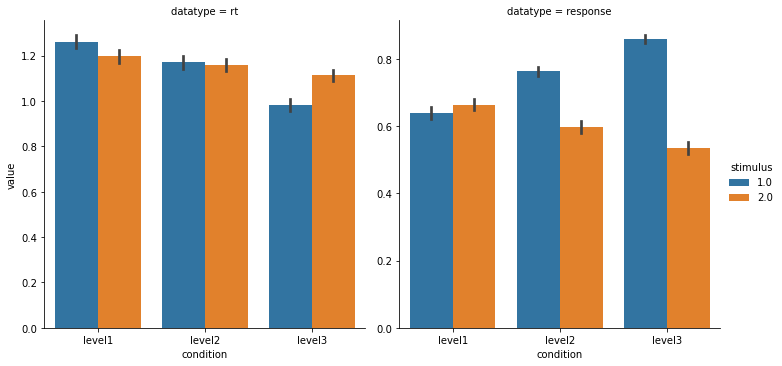

In [4]:
# ## plot the RT and Accuracy

# # wide-to-long format
# df_plot = pd.melt(mydata, 
#                   id_vars=['subj_idx', 'condition','stimulus'], 
#                   value_vars=['rt', 'response'],
#                   var_name='datatype')
# # df_plot.head()

# # way 1: 
# # stim_ord = df_plot.stimulus.unique()
# # g = sns.FacetGrid(df_plot, col="datatype", 
# #                  sharex=False,
# #                   sharey=False,
# #                  height=4)
# # g.map(sns.barplot, "condition", "value",'stimulus', hue_order=np.unique(df_plot["stimulus"]))

# # Way 2: 
# g = sns.catplot(data=df_plot, x='condition', y='value', hue='stimulus', col='datatype', kind='bar',
#                sharex=False, sharey=False)

### Example 2: Very similar case but response direction are meaningful

In this case, we actually have 2 * 3 design, the first factor is concening the stimulus type, and linked to different response. In this case, there is a strong interaction between the two factors, and for the condition B, there is no sig differences between the three levels, either in RT or ACC, but in condition A, there is sig diff. 

Let's assume the ground true of the model parameter is as below:

Parameter for condation A:

level1a = {'v':1.5, 'a':2, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

level2a = {'v':1.6, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}

level3a = {'v':2.0, 'a':2, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}

Parameter for condation B:

level1b = {'v':1.5, 'a':2, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

level2b = {'v':1.5, 'a':2, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

level3b = {'v':1.5, 'a':2, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

How can we model the simulated data?

There are multiple ways:

#### Accuracy-coding + HDDM
That is, we treat the data as accuracy-coding and use the base function. The pseudo code is like:

m1 = hddm:HDDM(depends_on = {'v': [Stim, levels], 'z':[Stim, levels]}, ...)

#### Stim-coding + HDDMstimcoding
That is, we treat the data as stimulus-coding and use the base function. But in this stituation, we might have two way to define the model.

The first way is treating the stimulus doesn't matter, as assumed by the stimcoding, the pseudo code is like:

m2 = hddm:HDDMStimcoding(depends_on = {'v': [levels], 'z':[levels]}, ...)


* Note However, in this case, the result will estimate the `v` and `z` at three levels instead 2 by 3 conditions, which means it didn't have big chance to recover the original six parameters.


The second way is treating the stimulus matters and add stimu as an addition factor, the pseudo code is like:

m3 = hddm:HDDMStimcoding(depends_on = {'v': [Stim, levels], 'z':[Stim, levels]})

#### Accuracy-coding + regressor
That is, we treat the data as accuracy-coding with within-subject design. The pseudo code is like:

m4 = hddm:HDDMRegressor{ 'v' ~ Stim * levels, 'z' ~ stim * levels, link:lamda invlogit_without_multiplying_sim}

#### Stim-coding + regressor
That is, we treat the data as stimulus-coding with within-subject design. And, again, we have two ways to model this situation. 

The first is assume that the data satify the assumption of stim-coding, and not model the stimuli type. The pseudo code is like:

m5 = hddm:HDDMRegressor{ 'v' ~ levels, 'z' ~ levels, link:lamda invlogit_multiplying_sim}

* Note this model is also problematic as m2

Alternatively, we assume the data do not satfifying the model assumption, the pseudo code is like:

m6 = hddm:HDDMRegressor{ 'v' ~ stim * levels, 'z' ~ stim * levels, link:lamda invlogit_multiplying_sim}.

### Steps for stimulation:

Step 1: simulate the data

Step 2: check the data itself

Step 3: fit the data with six models mentioned above

Step 4: Compare the models' DIC and PPC

Step 5: Conclusion and recommendataion

### Step 1: Generate simulation data

Generate the data


In [14]:
# set number of subjects and number of trials per level for the simulated experiment
n_subjects = 30
trials_per_level = 60

# Next, set up parameters of the DDM for three levels and the first stimulus. 
level1a = {'v':1.5, 'a':1.3, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}
level2a = {'v':1.6, 'a':1.3, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level3a = {'v':2.0, 'a':1.3, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}

# Next, set up parameters for the second stimulus, where `v` is the different as for the first stimulus. 
# and `z(stimulus_b) = 1 - z(stimulus_a)`. 
level1b = {'v':1.4, 'a':1.3, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}
level2b = {'v':1.4, 'a':1.3, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}
level3b = {'v':1.4, 'a':1.3, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}

Generate data, using the same parameters but assume the it's all within-subject.

In [15]:
random.seed(123)
np.random.seed(123)

mydata, params = hddm.generate.gen_rand_data({'level1': level1a,
                                                'level2': level2a,
                                                'level3': level3a,
                                                'level4': level1b,
                                                'level5': level2b,
                                                'level6': level3b},
                                              size=trials_per_level,
                                              subjs=n_subjects)

mydata['stimulus'] = np.where(((mydata['condition'] == 'level1') |
                              (mydata['condition'] == 'level2') |
                              (mydata['condition'] == 'level3')) , 1, 2)

mydata.loc[(mydata['condition'] == 'level4'),'condition']= 'level1'
mydata.loc[(mydata['condition'] == 'level5'),'condition']= 'level2'
mydata.loc[(mydata['condition'] == 'level6'),'condition']= 'level3'

# print('Unique combinations of levels and stimulus')
# mydata.groupby(['condition','stimulus']).size()

# covert the params into dataframe for later use.
cols = ['condition', 'subj_idx', 'params', 'value']
row = []
df_params = pd.DataFrame([], columns = cols)
#

for level in params.keys(): 
    data_row = params[level]

    for subj, data in enumerate(data_row):

        for key, value in data.items():
            row = [[level, subj, key, value]]
            data = pd.DataFrame(row, columns=cols)
            df_params = df_params.append(data, ignore_index=True)
            

df_params = df_params.pivot_table(index = ['condition','subj_idx'], columns =['params'], 
                        values =['value']).reset_index() 

col_ind = ['condition','subj_idx', 'a_pop', 'st_pop','sv_pop', 'sz_pop', 't_pop', 'v_pop', 'z_pop']
df_params.columns = col_ind

# df_params_b['StimType'] = 'right'

df_params['stimulus'] = np.where(((df_params['condition'] == 'level1') |
                              (df_params['condition'] == 'level2') |
                              (df_params['condition'] == 'level3')) , 1, 2)

df_params.loc[(df_params['condition'] == 'level4'),'condition']= 'level1'
df_params.loc[(df_params['condition'] == 'level5'),'condition']= 'level2'
df_params.loc[(df_params['condition'] == 'level6'),'condition']= 'level3'

df_params['StimType'] = np.where((df_params['stimulus'] == 1) , 'left', 'right')

#print('Unique combinations of levels and stimulus')
#df_params.groupby(['condition','stimulus']).size()
df_params.head()

condition  subj_idx     a_pop    st_pop    sv_pop    sz_pop     t_pop  \
0    level1         0  1.399735  0.149139  0.165144  0.126594  0.328298   
1    level1         1  1.220791  0.133319  0.015975  0.058869  0.367458   
2    level1         2  1.315234  0.034590  0.037492  0.243941  0.360005   
3    level1         3  1.262625  0.095630  0.099299  0.102319  0.265328   
4    level1         4  1.263466  0.009696  0.031619  0.074624  0.518431   

      v_pop     z_pop  stimulus StimType  
0  1.391437  0.157332         1     left  
1  1.436110  0.233952         1     left  
2  1.652525  0.171825         1     left  
3  1.422619  0.290780         1     left  
4  1.475317  0.473331         1     left

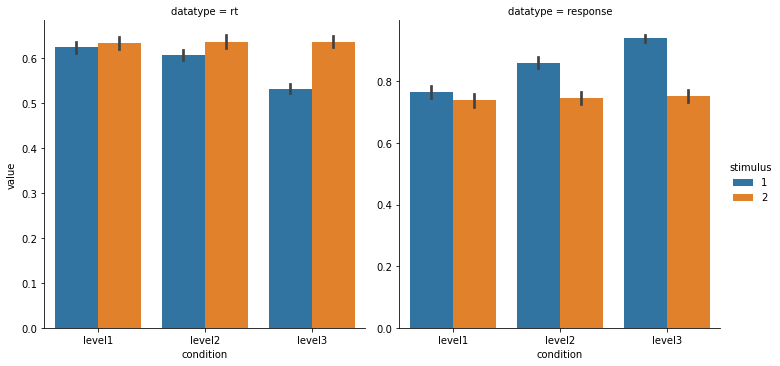

In [16]:
## plot the RT and Accuracy

# wide-to-long format
df_plot = pd.melt(mydata, 
                  id_vars=['subj_idx', 'condition','stimulus'], 
                  value_vars=['rt', 'response'],
                  var_name='datatype')
# df_plot.head()

# way 1: 
# stim_ord = df_plot.stimulus.unique()
# g = sns.FacetGrid(df_plot, col="datatype", 
#                  sharex=False,
#                   sharey=False,
#                  height=4)
# g.map(sns.barplot, "condition", "value",'stimulus', hue_order=np.unique(df_plot["stimulus"]))

# Way 2: 
g = sns.catplot(data=df_plot, x='condition', y='value', hue='stimulus', col='datatype', kind='bar',
               sharex=False, sharey=False)

Below we will use accuracy-coding and stim-coding to model the data. Accordingly, we need to change the way of organizing the data.

In accuracy-coding, response is accuracy, which is the same as the above simulation.

In stimulus-coding, response is the key participants' actual response, an additional stim_col indicate the response participant should response. (**Is this only the case for HDDMStim?**)

Let's assume that stimulus = 1.0 means participants should press the left key, stimulus = 2.0 idicate the right key.

Then, we should re-organize the data as follow:

stimulus = 1.0 & accuracy = 1 => response is left (i.e., the acutal response is 0)

stimulus = 2.0 & accuracy = 1 => resposne is right (i.e., the acutal response is 1)

stimulus = 1.0 & **accuracy = 0** => response is **right (i.e., the acutal response is 1)**

stimulus = 2.0 & **accuracy = 0** => resposne is **left (i.e., the acutal response is 0)**


In [6]:
# data for accuracy-coding modelling, response is accuracy.
# added a column for the stimulus type: 1.0 = left; 2.0 = right.

df_acc = mydata.copy() # cannot use df_acc = mydata, otherwise, mydata will be also changed as df_acc change
df_acc['StimType'] = np.where(df_acc['stimulus'] == 1.0, 'left', 'right')

# data for stimulus coding
df_stim = mydata.copy()
df_stim.rename(columns={'response':'accuracy'}, inplace=True)
df_stim['StimType'] = np.where(df_stim['stimulus'] == 1.0, 'left', 'right')

# left stim, left response
df_stim.loc[(df_stim['StimType'] == 'left') & (df_stim['accuracy'] == 1.0),'response']= 0

# left stim, right response
df_stim.loc[(df_stim['StimType'] == 'left') & (df_stim['accuracy'] != 1.0),'response']= 1

# right stim, right resp
df_stim.loc[(df_stim['StimType'] == 'right') & (df_stim['accuracy'] == 1.0),'response']= 1

# right stim, left resp
df_stim.loc[(df_stim['StimType'] == 'right') & (df_stim['accuracy'] == 0.0),'response']= 0

# df_stim['response'] = np.where(df_stim['StimType'] == 'left' & df_stim['accuracy'] == 1.0, 0, 1)

# change the stimulus column
# df_stim.loc[(df_stim['StimType'] == 'left'),'stim']= 0
# df_stim.loc[(df_stim['StimType'] == 'right'),'stim']= 1

# df_stim.head()

df_acc = pd.merge(df_acc, df_params)
df_stim = pd.merge(df_stim, df_params)

In [7]:
df_stim.head()

rt  accuracy  subj_idx condition  stimulus StimType  response  \
0  0.462767       0.0         0    level1         1     left       1.0   
1  0.410435       0.0         0    level1         1     left       1.0   
2  0.822557       1.0         0    level1         1     left       0.0   
3  0.903459       1.0         0    level1         1     left       0.0   
4  1.013269       1.0         0    level1         1     left       0.0   

      a_pop    st_pop    sv_pop    sz_pop     t_pop     v_pop     z_pop  
0  2.099735  0.149139  0.165144  0.126594  0.328298  1.391437  0.157332  
1  2.099735  0.149139  0.165144  0.126594  0.328298  1.391437  0.157332  
2  2.099735  0.149139  0.165144  0.126594  0.328298  1.391437  0.157332  
3  2.099735  0.149139  0.165144  0.126594  0.328298  1.391437  0.157332  
4  2.099735  0.149139  0.165144  0.126594  0.328298  1.391437  0.157332

### Step 2: Check the data itself

Here we analyze the data as an experiment and plot it's summary data. More importantly, we will check the correaltion between different condition across subjects.

What we found?

RT and ACC are correlated within each stimulus type (between level 1, 2, and 3) but not across stimulus type. Does it mean that we need to change the way to simulate the data?

Note: here we can use plotly later for checking each individual's RT distribution in different conditions.

In [8]:
def plot_sum_cor(df, var = 'rt'):
    '''
    df: simulated dataframe
    var: the variable of which the summary data will be plotted, i.e., rt or response
    '''
    df_sum = df.groupby(['subj_idx', 'condition', 'StimType'])[var].mean().reset_index()

    # long to wide for pair plots
    df_sum_wide = df_sum.pivot_table(index=['subj_idx'], 
                                     columns=['condition','StimType'],
                                          #aggfunc='size', 
                                     values = var,     
                                     fill_value=0) 

    df_sum_wide.columns = df_sum_wide.columns.map('_'.join)
    df_sum_wide = df_sum_wide.reset_index() 

    # plot pairs with regression lines
    sns.pairplot(df_sum_wide.loc[:, df_sum_wide.columns != 'subj_idx'], kind="reg")
    
    print('Here is the correlation matrix of ', var)
    print(df_sum_wide.loc[:, df_sum_wide.columns != 'subj_idx'].corr())

Here is the correlation matrix of  rt
              level1_left  level1_right  level2_left  level2_right  \
level1_left      1.000000      0.871236     0.786676      0.820907   
level1_right     0.871236      1.000000     0.811868      0.836033   
level2_left      0.786676      0.811868     1.000000      0.679901   
level2_right     0.820907      0.836033     0.679901      1.000000   
level3_left      0.703294      0.728764     0.901278      0.675628   
level3_right     0.852591      0.737618     0.819886      0.716638   

              level3_left  level3_right  
level1_left      0.703294      0.852591  
level1_right     0.728764      0.737618  
level2_left      0.901278      0.819886  
level2_right     0.675628      0.716638  
level3_left      1.000000      0.757278  
level3_right     0.757278      1.000000  


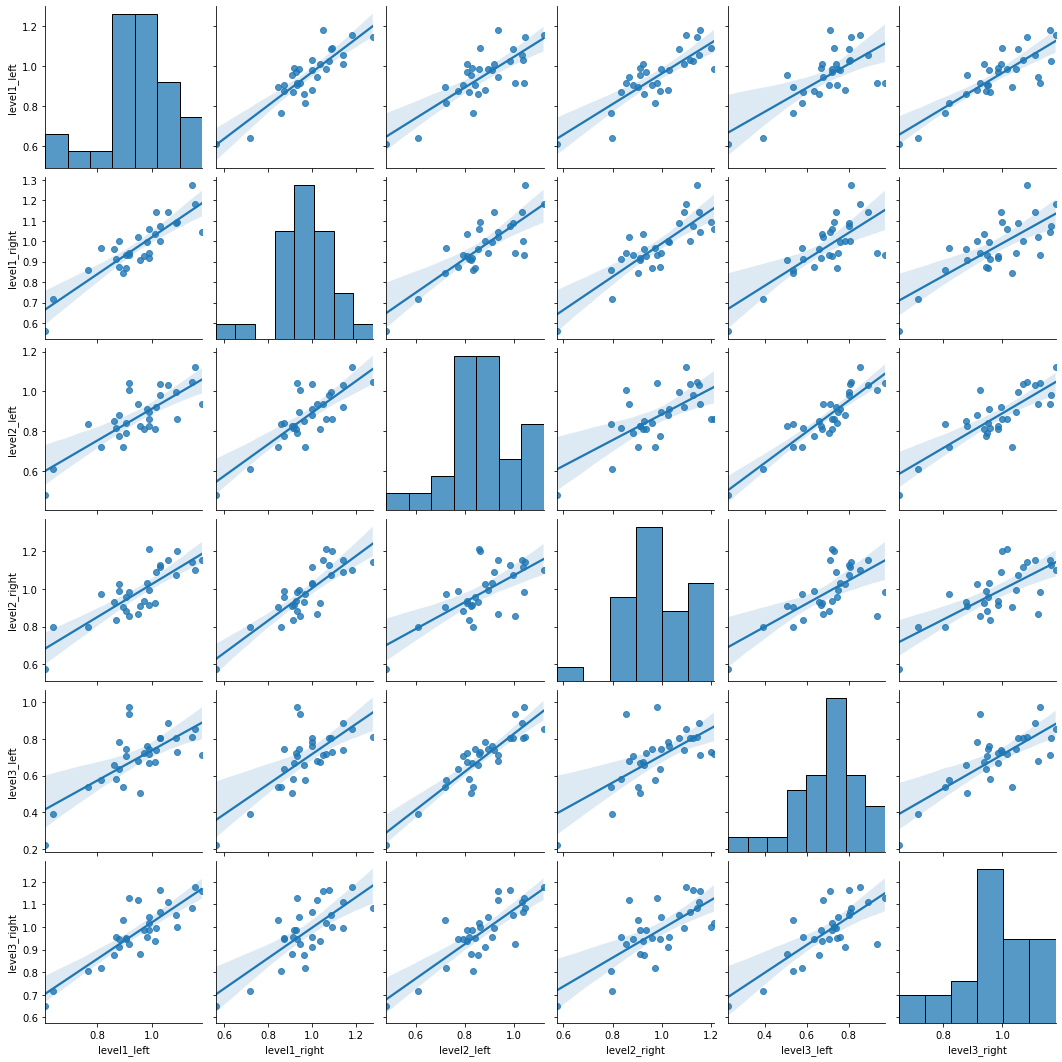

In [9]:
plot_sum_cor(df_acc, 'rt')

Here is the correlation matrix of  response
              level1_left  level1_right  level2_left  level2_right  \
level1_left      1.000000      0.899680     0.783652      0.921460   
level1_right     0.899680      1.000000     0.828889      0.876120   
level2_left      0.783652      0.828889     1.000000      0.734360   
level2_right     0.921460      0.876120     0.734360      1.000000   
level3_left      0.736707      0.812101     0.797827      0.734514   
level3_right     0.913168      0.872418     0.824956      0.876574   

              level3_left  level3_right  
level1_left      0.736707      0.913168  
level1_right     0.812101      0.872418  
level2_left      0.797827      0.824956  
level2_right     0.734514      0.876574  
level3_left      1.000000      0.782976  
level3_right     0.782976      1.000000  


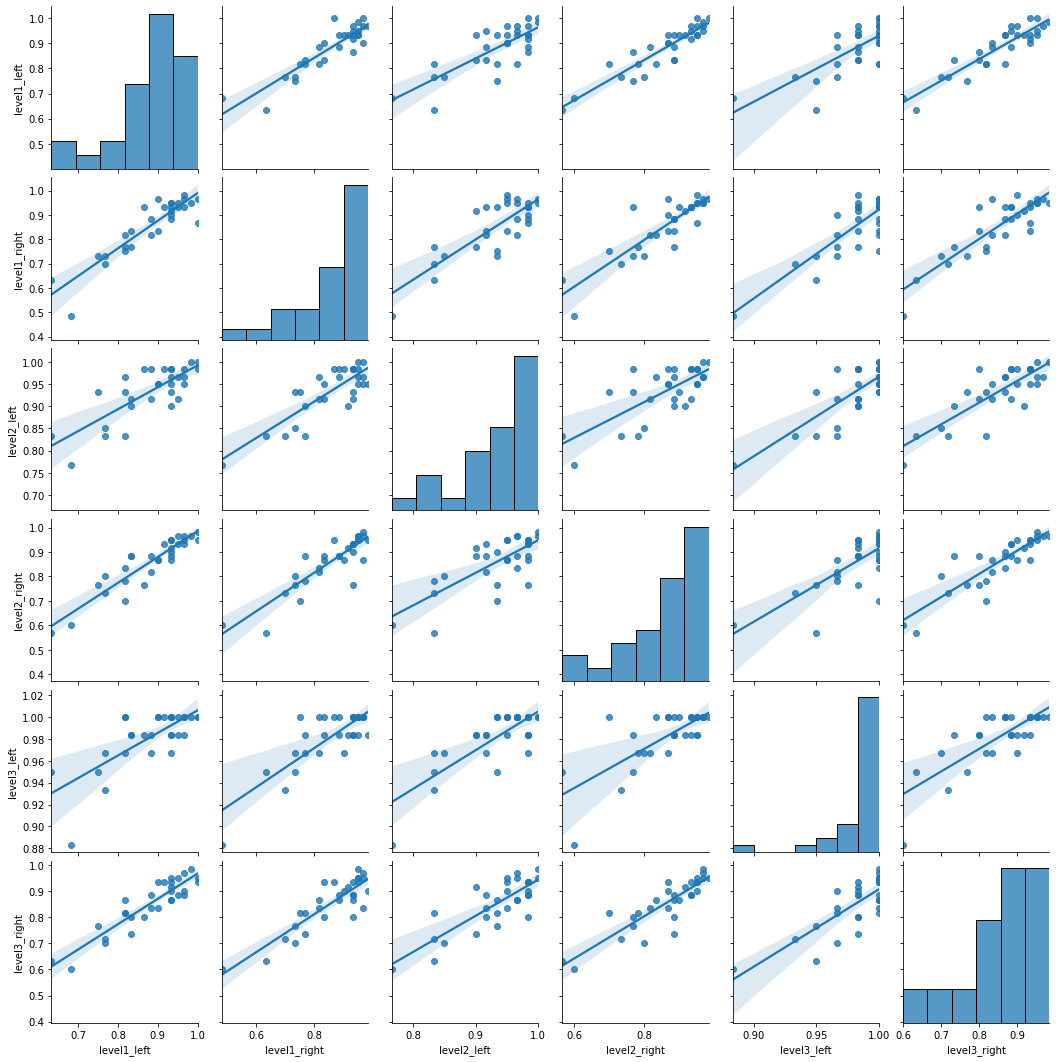

In [10]:
plot_sum_cor(df_acc, 'response')

#### M1: Accuracy coding + HDDM

The first model, use the simple between-subject design model and accuracy-coding. This looks like the most unlikely.

m1 = hddm:HDDM(depends_on = {'v': [Stim, levels], 'z':[Stim, levels]},...)

In [17]:
m1 = hddm.HDDM(df_acc, depends_on={'v': ['condition', 'StimType'], 'z': ['condition', 'StimType']}, 
               include=['v', 'z', 't'],p_outlier=.05)

m1.find_starting_values()
m1.sample(2000,burn = 500, dbname='stim_sim_m1.db', db='pickle')
# 2001 of 2000 complete in 1797.8 sec

# save the model
m1.save('stim_sim_m1')

m1.print_stats()

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 1797.8 sec[-----------------70%------            ] 1407 of 2000 complete in 1266.9 sec                              mean         std       2.5q        25q        50q        75q      97.5q       mc err
a                           1.9816   0.0222057    1.93872    1.96691    1.98156    1.99586     2.0268  0.000727569
a_std                     0.108476   0.0170668   0.078511   0.096428   0.106935   0.118846   0.146577  0.000601621
a_subj.0                   2.11692   0.0444611    2.02998     2.0861    2.11612    2.14557    2.20746    0.0015349
a_subj.1                   1.94517   0.0400158    1.86599    1.91848    1.94651     1.9716    2.02222   0.00133373
a_subj.2                   2.01597   0.0414371    1.93511    1.98856    2.01577    2.04371    2.09895   0.00148306
a_subj.3                     2.001   0.0443195    1.91894     1.9706    1.99904     2.0295    2.09808   0.00188663
a_subj.4                     2.092   0.042

In [11]:
# load the model data if it was previously saved
m1 = hddm.load('stim_sim_m1')

Check parameter recovery

Check the correlation between recovered parameters and the ground truth.

Also check the correlation between recovered parameters themselves to see if there exist trade-off between parameters.

In [12]:
def gen_params_comp(m, df_params):
    '''
    merge the group-level parameters from model fitting with the ground truth of simulation.
    for later plotting and correlation analysis
    '''
    
    m_stats = m.gen_stats()
    m_stats['params'] = m_stats.index
    m_stats.head()

    m_stats_subj = m_stats[m_stats['params'].str.contains("z_subj|v_subj")]
    m_stats_subj[['param','subj']] = m_stats_subj['params'].str.split("_",expand=True) 
    m_stats_subj[['subj','conds','subj_idx']] = m_stats_subj['subj'].str.split("\(|\)",expand=True) 

    # https://stackoverflow.com/questions/46124469/shape-mismatch-indexing-arrays-could-not-be-broadcast-together-with-shapes
    m_stats_subj[['subj_idx']] = m_stats_subj['subj_idx'].str.split(".",expand=True)[1][:,np.newaxis] 
    m_stats_subj[['StimType', 'condition']] = m_stats_subj['conds'].str.split(".",expand=True).loc[:,0:1]
    m_stats_subj = m_stats_subj.drop(['subj', 'conds'], axis=1).copy()

    m_stats_subj_wide = m_stats_subj.pivot_table(index=['subj_idx', 'condition', 'StimType'], 
                                     columns=['param'],
                                     aggfunc='first', 
                                     values = 'mean',     
                                     fill_value=0) 
    #m1_stats_subj_wide.columns = m1_stats_subj_wide.columns.map('_'.join)
    m_stats_subj_wide.reset_index(inplace=True)  

    # reset the index
    m_stats_subj_wide.index = df_params.index

    # change the data type of 'subj_idx'
    m_stats_subj_wide['subj_idx'] = m_stats_subj_wide['subj_idx'].astype(int)
    
    df_params_ppc = pd.merge(df_params, m_stats_subj_wide)
    return df_params_ppc  

In [13]:
tmp = gen_params_comp(m1, df_params)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [14]:
# correlation between variables.
tmp.groupby(['StimType', 'condition'])[['v','v_pop','z', 'z_pop']].corr()

v     v_pop         z     z_pop
StimType condition                                              
left     level1    v      1.000000  0.501747  0.327299  0.444686
                   v_pop  0.501747  1.000000  0.094512  0.089086
                   z      0.327299  0.094512  1.000000  0.913195
                   z_pop  0.444686  0.089086  0.913195  1.000000
         level2    v      1.000000  0.608738  0.399344  0.469079
                   v_pop  0.608738  1.000000  0.112050  0.089086
                   z      0.399344  0.112050  1.000000  0.956915
                   z_pop  0.469079  0.089086  0.956915  1.000000
         level3    v      1.000000  0.445186  0.528031  0.626526
                   v_pop  0.445186  1.000000  0.037261  0.089086
                   z      0.528031  0.037261  1.000000  0.890952
                   z_pop  0.626526  0.089086  0.890952  1.000000
right    level1    v      1.000000  0.623415  0.602548  0.650414
                   v_pop  0.623415  1.000000  0.154305  0.089086
                   z      0.602548  0.154305  1.000000  0.916975
                   z_pop  0.650414  0.089086  0.916975  1.000000
         level2    v      1.000000  0.503719  0.388509  0.474410
                   v_pop  0.503719  1.000000  0.060762  0.089086
                   z      0.388509  0.060762  1.000000  0.954857
                   z_pop  0.474410  0.089086  0.954857  1.000000
         level3    v      1.000000  0.611886  0.608920  0.617683
                   v_pop  0.611886  1.000000  0.044423  0.089086
                   z      0.608920  0.044423  1.000000  0.937347
                   z_pop  0.617683  0.089086  0.937347  1.000000

[None, None]

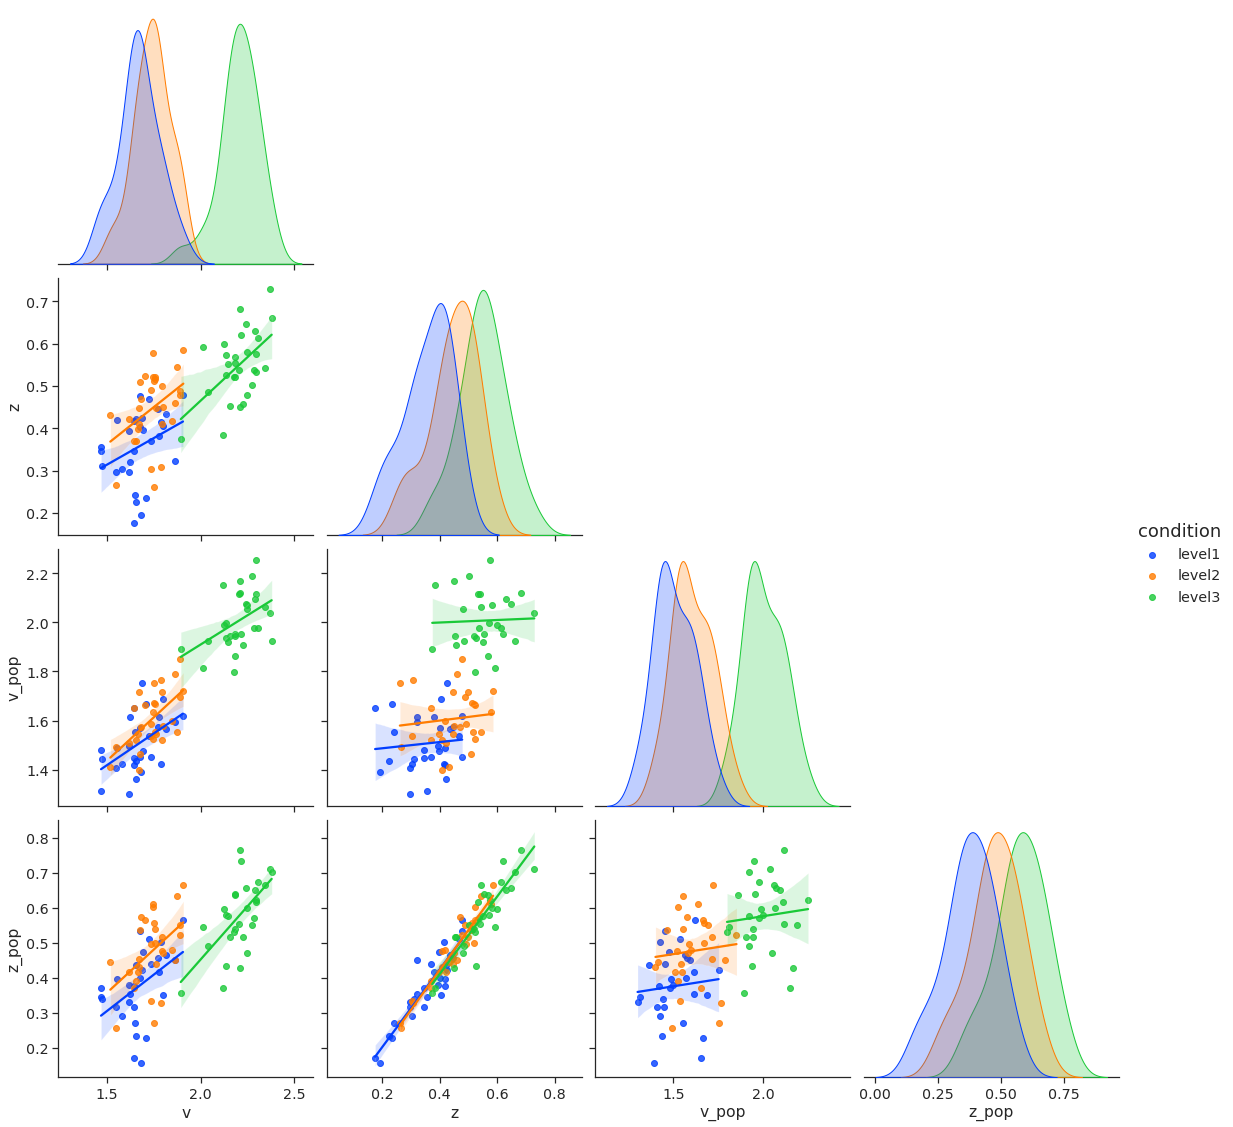

In [15]:
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(tmp.loc[tmp['StimType'] == 'left', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright", 
                 #plot_kws=dict(edgecolor='none', alpha=0.5),
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

[None, None]

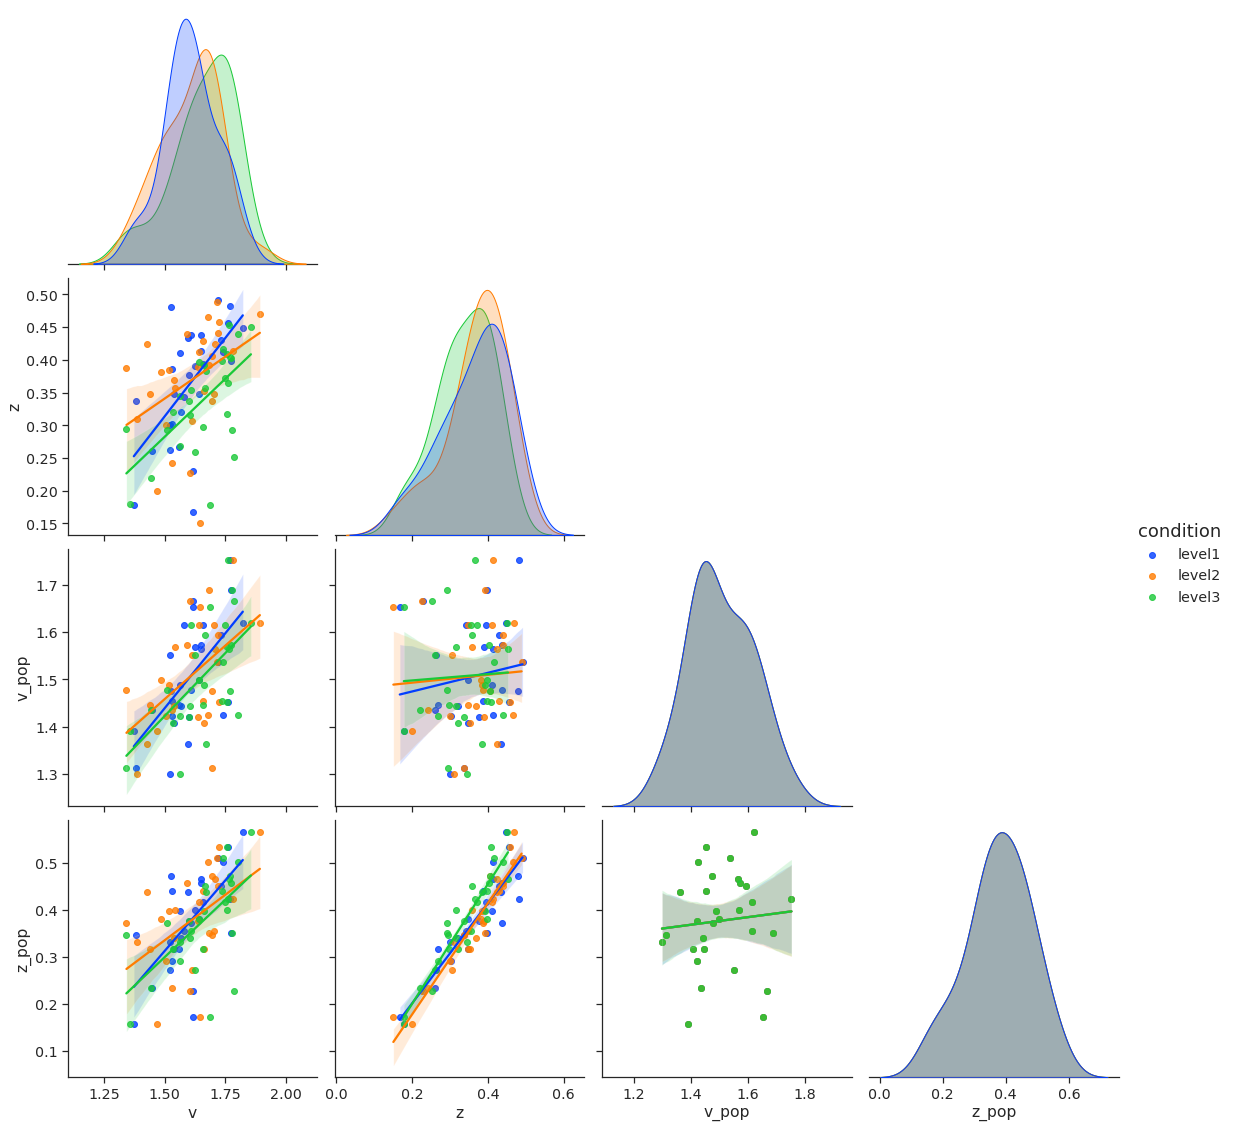

In [17]:
# pair plot for right stimuli
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(tmp.loc[tmp['StimType'] == 'right', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright", 
                 #plot_kws=dict(edgecolor='none', alpha=0.5),
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

Another step could be used for mode recovery: PPC.

In [17]:
m1_ppc_data = hddm.utils.post_pred_gen(m1)
#m1_ppc_data.head()

ppc_compare = hddm.utils.post_pred_stats(df_acc, m1_ppc_data)
print(ppc_compare)

 [-----------------101%-----------------] 183 of 180 complete in 1689.5 sec          observed      mean       std       SEM       MSE credible  \
stat                                                                  
accuracy  0.659222  0.665869  0.137265  0.000044  0.018884     True   
mean_ub   1.248360  1.236255  0.237438  0.000147  0.056524     True   
std_ub    0.794891  0.718103  0.150149  0.005896  0.028441     True   
10q_ub    0.505003  0.580049  0.143958  0.005632  0.026355     True   
30q_ub    0.753127  0.782205  0.187116  0.000846  0.035858     True   
50q_ub    1.027213  1.025537  0.231574  0.000003  0.053630     True   
70q_ub    1.422330  1.388872  0.289152  0.001119  0.084730     True   
90q_ub    2.298006  2.154882  0.416715  0.020485  0.194137     True   
mean_lb  -1.183679 -1.173289  0.202504  0.000108  0.041116     True   
std_lb    0.763513  0.688057  0.186492  0.005694  0.040473     True   
10q_lb    0.496125  0.557219  0.132461  0.003732  0.021278     True   
30

In [18]:
ppc_stats = hddm.utils.post_pred_stats(df_acc, m1_ppc_data, call_compare=False)
print(ppc_stats.head())

                            accuracy   mean_ub    std_ub    10q_ub    30q_ub  \
node                sample                                                     
wfpt(left.level1).0 0           0.22  1.911798  1.221440  0.947026  1.238676   
                    1           0.32  1.906606  1.277204  0.707869  1.373119   
                    2           0.34  1.511916  0.726405  0.746936  1.049276   
                    3           0.28  1.441306  0.695525  0.799554  0.958294   
                    4           0.33  2.021173  1.472641  0.935422  1.199442   

                              50q_ub    70q_ub    90q_ub   mean_lb    std_lb  \
node                sample                                                     
wfpt(left.level1).0 0       1.508126  1.869536  2.950546 -0.845492  0.625802   
                    1       1.613609  1.930439  3.217469 -0.709554  0.656929   
                    2       1.324866  1.883656  2.410316 -0.854033  0.622987   
                    3       1.191374  1

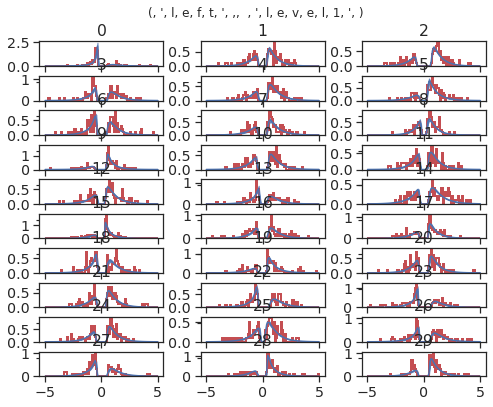

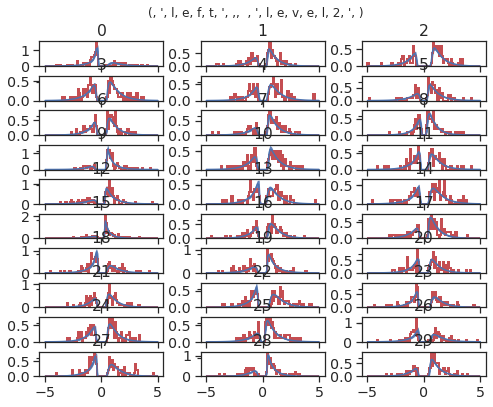

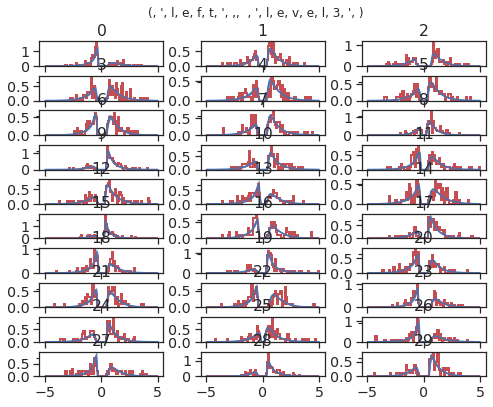

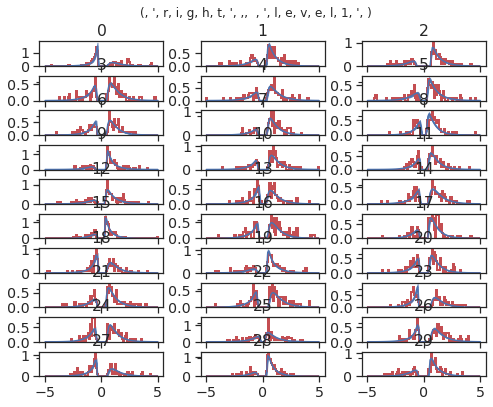

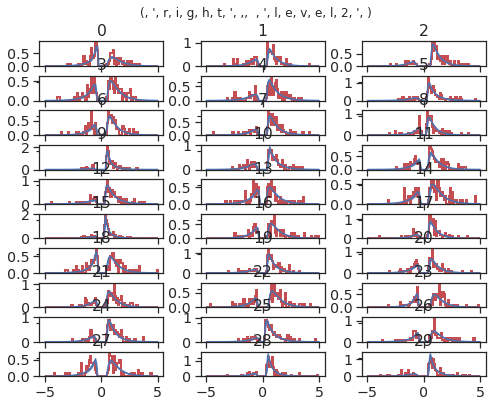

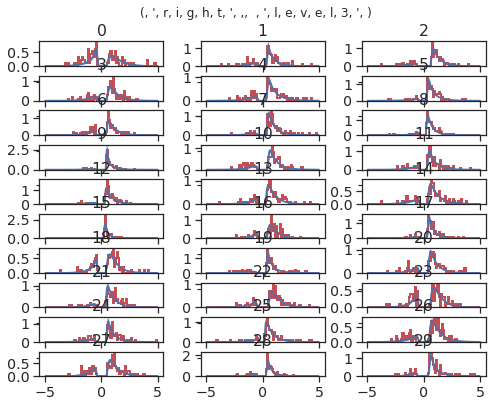

In [19]:
m1.plot_posterior_predictive()

#### M2: Stimcoding with HDDMStimcoding: Way 1

This model still use between-subj design, but use the stimcoding as assumed in the tutorial, i.e., assuming that the response doesn't matter.

m2 = hddm:HDDMStimcoding(depends_on = {'v': [levels], 'z':[levels]}, ...)

Even the number of parameters are different from recovered here and the ground truth data, we nevertheless tried to compare them.


In [18]:
# Should not use 'data = df_stim'
m2 = hddm.HDDMStimCoding(df_stim, include=['z'],
                         stim_col='stim',
                         depends_on={'v': ['condition'], 'z':['condition']}, 
                         p_outlier=.05,
                         split_param='v',
                         drift_criterion=False)                                    

m2.find_starting_values()
m2.sample(2000,burn = 500, dbname='stim_sim_m2.db', db='pickle')
2001 of 2000 complete in 1699.4 sec 

# save the model
m2.save('stim_sim_m2')
#C_val_vtz = hddm.load('C_val_vtz')

m2.print_stats()

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 1699.4 sec                       mean       std      2.5q       25q       50q       75q     97.5q    mc err
a                  1.958776  0.022294  1.916160  1.943811  1.958509  1.973451  2.003572  0.000731
a_std              0.108780  0.016422  0.080732  0.097186  0.107166  0.119231  0.144351  0.000597
a_subj.0           1.911967  0.041124  1.832726  1.883309  1.912270  1.939656  1.991499  0.001551
a_subj.1           1.941747  0.038983  1.864347  1.916045  1.942007  1.968111  2.016992  0.001389
a_subj.2           2.020687  0.040153  1.943897  1.994180  2.021255  2.048286  2.099066  0.001302
a_subj.3           1.982271  0.040073  1.905202  1.954586  1.983241  2.009772  2.059926  0.001342
a_subj.4           2.088061  0.041608  2.004084  2.060009  2.089032  2.116187  2.171952  0.001409
a_subj.5           2.054791  0.044463  1.967485  2.025146  2.055512  2.085140  2.139976  0.001570
a_subj.6           1.886480  0.037140  1.

#### M3: Stimcoding with HDDMStimcoding: Way 2

The second way is treating the stimulus matters and add stimu as an addition factor, the pseudo code is like:

m3 = hddm:HDDMStimcoding(depends_on = {'v': [Stim, levels], 'z':[Stim, levels]}, ...)


In [19]:
# Should not use 'data = df_stim'
m3 = hddm.HDDMStimCoding(df_stim, include=['z'],
                         stim_col='stimulus',
                         depends_on={'v': ['condition', 'StimType'], 'z': ['condition', 'StimType']}, 
                         p_outlier=.05,
                         split_param='v',
                         drift_criterion=False)                                    

m3.find_starting_values()
m3.sample(2000,burn = 500, dbname='stim_sim_m3.db', db='pickle')
# 2001 of 2000 complete in 1793.5 sec

# save the model
m3.save('stim_sim_m3')
# m3 = hddm.load('stim_sim_m3')

m3.print_stats()

/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 1793.5 sec--------------  40%                  ] 801 of 2000 complete in 718.3 sec                             mean       std      2.5q       25q       50q       75q     97.5q    mc err
a                        1.980845  0.021733  1.940369  1.966424  1.980448  1.995081  2.024537  0.000710
a_std                    0.107482  0.017315  0.077886  0.095498  0.105508  0.117636  0.145602  0.000666
a_subj.0                 2.118568  0.042340  2.036256  2.090082  2.118769  2.147656  2.201477  0.001460
a_subj.1                 1.944942  0.040070  1.869736  1.916202  1.945050  1.972621  2.021840  0.001297
a_subj.2                 2.011315  0.041432  1.930111  1.981915  2.011547  2.040467  2.091299  0.001681
a_subj.3                 2.000715  0.042973  1.918653  1.971657  1.999141  2.028840  2.090356  0.001644
a_subj.4                 2.089100  0.043440  2.003956  2.060555  2.088839  2.118718  2.172626  0.001489
a_subj.5           

In [18]:
# load the model data if it was previously saved
m3 = hddm.load('stim_sim_m3')

In [19]:
tmp = gen_params_comp(m3, df_params)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [20]:
# correlation between variables.
tmp.groupby(['StimType', 'condition'])[['v','v_pop','z', 'z_pop']].corr()

v     v_pop         z     z_pop
StimType condition                                              
left     level1    v      1.000000  0.506216 -0.342637  0.444934
                   v_pop  0.506216  1.000000 -0.093796  0.089086
                   z     -0.342637 -0.093796  1.000000 -0.915558
                   z_pop  0.444934  0.089086 -0.915558  1.000000
         level2    v      1.000000  0.599184 -0.400570  0.471753
                   v_pop  0.599184  1.000000 -0.120543  0.089086
                   z     -0.400570 -0.120543  1.000000 -0.954903
                   z_pop  0.471753  0.089086 -0.954903  1.000000
         level3    v      1.000000  0.453420 -0.540466  0.638310
                   v_pop  0.453420  1.000000 -0.038127  0.089086
                   z     -0.540466 -0.038127  1.000000 -0.890419
                   z_pop  0.638310  0.089086 -0.890419  1.000000
right    level1    v      1.000000  0.626490  0.592004  0.643610
                   v_pop  0.626490  1.000000  0.152491  0.089086
                   z      0.592004  0.152491  1.000000  0.915930
                   z_pop  0.643610  0.089086  0.915930  1.000000
         level2    v      1.000000  0.504162  0.393574  0.478989
                   v_pop  0.504162  1.000000  0.060183  0.089086
                   z      0.393574  0.060183  1.000000  0.954219
                   z_pop  0.478989  0.089086  0.954219  1.000000
         level3    v      1.000000  0.612804  0.605998  0.610724
                   v_pop  0.612804  1.000000  0.048300  0.089086
                   z      0.605998  0.048300  1.000000  0.937610
                   z_pop  0.610724  0.089086  0.937610  1.000000

[None, None]

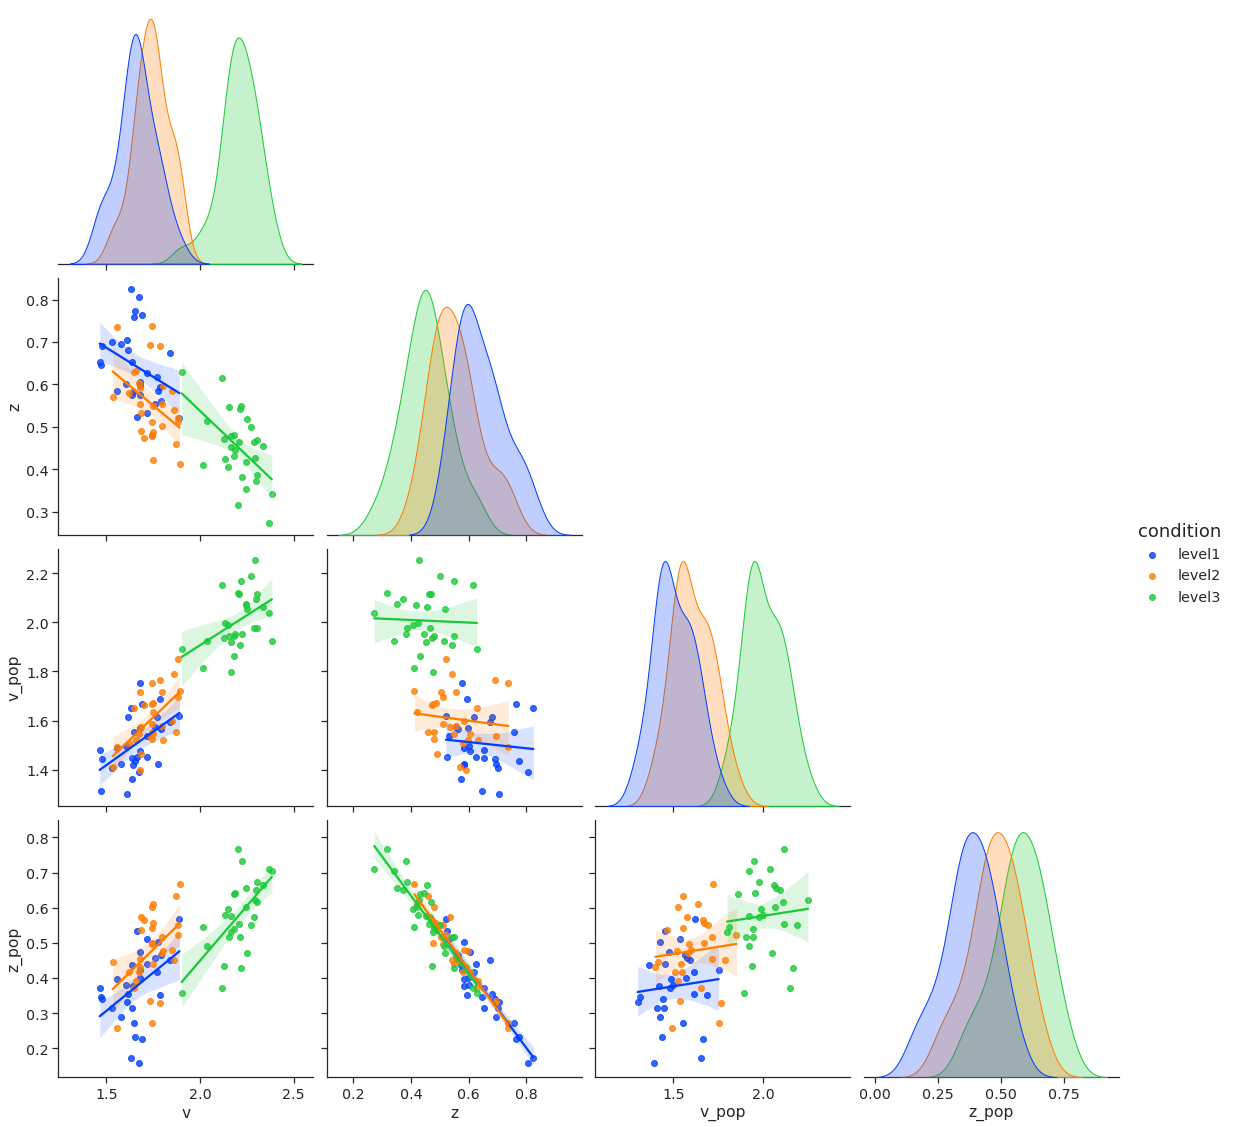

In [21]:
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(tmp.loc[tmp['StimType'] == 'left', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright", 
                 #plot_kws=dict(edgecolor='none', alpha=0.5),
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

[None, None]

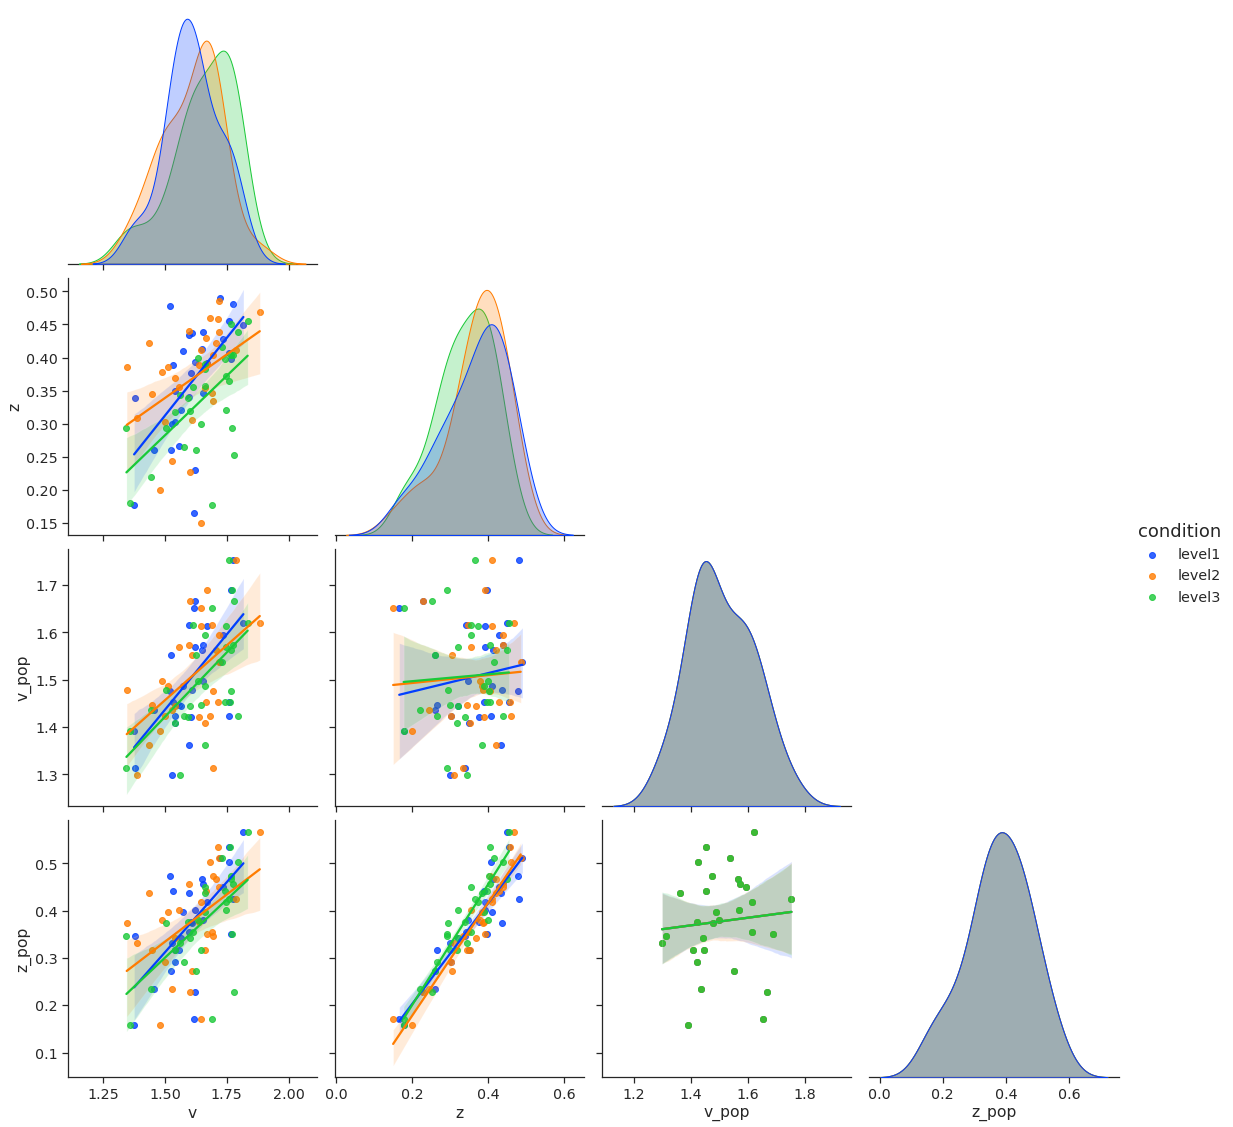

In [22]:
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(tmp.loc[tmp['StimType'] == 'right', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright", 
                 #plot_kws=dict(edgecolor='none', alpha=0.5),
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

#### M4: Accuracy-coding + regressor
That is, we treat the data as accuracy-coding with within-subject design. The pseudo code is like:

m4 = hddm:HDDMRegressor{ 'v' ~ Stim * levels, 'z' ~ stim * levels, 'link_func':lambda x:1/(1+np.exp(-x))}

For reduced-rank coding, one level is chosen as the “reference”, and its mean behaviour is represented by the intercept. Each column of the resulting matrix represents the difference between the mean of one level and this reference level.

For full-rank coding, classic “dummy” coding is used, and each column of the resulting matrix represents the mean of the corresponding level.

https://patsy.readthedocs.io/en/latest/API-reference.html#handling-categorical-data

$v_{ij} = v_{int} + v_{intsubj} + \beta_{i} * cond_{}i$

$i$ is the condition;

$j$ is the subject index

In [22]:
# full rank coding
dmatrix("0 + C(condition, Treatment) * C(StimType, Treatment)", data=df_acc)

DesignMatrix with shape (18000, 6)
  Columns:
    ['C(condition, Treatment)[level1]',
     'C(condition, Treatment)[level2]',
     'C(condition, Treatment)[level3]',
     'C(StimType, Treatment)[T.right]',
     'C(condition, Treatment)[T.level2]:C(StimType, Treatment)[T.right]',
     'C(condition, Treatment)[T.level3]:C(StimType, Treatment)[T.right]']
  Terms:
    'C(condition, Treatment)' (columns 0:3)
    'C(StimType, Treatment)' (column 3)
    'C(condition, Treatment):C(StimType, Treatment)' (columns 4:6)
  (to view full data, use np.asarray(this_obj))

In [23]:
# reduced rank coding
dmatrix("C(condition, Treatment) * C(StimType, Treatment)", data=df_acc)

DesignMatrix with shape (18000, 6)
  Columns:
    ['Intercept',
     'C(condition, Treatment)[T.level2]',
     'C(condition, Treatment)[T.level3]',
     'C(StimType, Treatment)[T.right]',
     'C(condition, Treatment)[T.level2]:C(StimType, Treatment)[T.right]',
     'C(condition, Treatment)[T.level3]:C(StimType, Treatment)[T.right]']
  Terms:
    'Intercept' (column 0)
    'C(condition, Treatment)' (columns 1:3)
    'C(StimType, Treatment)' (column 3)
    'C(condition, Treatment):C(StimType, Treatment)' (columns 4:6)
  (to view full data, use np.asarray(this_obj))

In [20]:
z_reg4 = {'model': "z ~ 1 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 
         'link_func': lambda x:1/(1+np.exp(-x))}

v_reg4 = {'model': "v ~ 1 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 
         'link_func': lambda x:x}

reg_descr4 = [z_reg4, v_reg4]

# Note here the 'group_only_regresors' is set to 'false'
m4 = hddm.HDDMRegressor(df_acc, reg_descr4, group_only_regressors=False, keep_regressor_trace=True, include='z')

m4.find_starting_values()

m4.sample(2000, burn=500, dbname='stim_sim_m4.db', db='pickle') # 7688.0 sec

# save the model
m4.save('stim_sim_m4')
# m4 = hddm.load('stim_sim_m4')

m4.print_stats()

Adding these covariates:
['z_Intercept', "z_C(condition, Treatment('level1'))[T.level2]", "z_C(condition, Treatment('level1'))[T.level3]", "z_C(StimType, Treatment('left'))[T.right]", "z_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]", "z_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]"]
Adding these covariates:
['v_Intercept', "v_C(condition, Treatment('level1'))[T.level2]", "v_C(condition, Treatment('level1'))[T.level3]", "v_C(StimType, Treatment('left'))[T.right]", "v_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]", "v_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]"]


/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 7688.0 secWARNING: Will not save custom link functions.
                                                                                            mean         std        2.5q        25q        50q        75q       97.5q       mc err
a                                                                                        1.96825   0.0212217     1.92717    1.95379     1.9683    1.98193     2.01133  0.000659441
a_std                                                                                   0.103724   0.0169274    0.075683  0.0917517   0.102278    0.11407    0.141411  0.000645053
a_subj.0                                                                                 1.94244   0.0381433     1.86977    1.91571    1.94291    1.96793     2.01489   0.00133448
a_subj.1                                                                                 1.94416   0.0386644     1.87093    1.91818     1.9444    1.97075     2.0

In [23]:
m4 = hddm.load('stim_sim_m4')

In [4]:
m_traces = m4.get_traces()
slct_col_names = m_traces.columns[m_traces.columns.str.contains("z_")]
m_traces = m_traces[slct_col_names].copy()

slct_col_names
trace_name = m_traces.columns[m_traces.columns.str.contains("subj.0|subj_trans.0")]

trace_name

Index(['z_Intercept_subj_trans.0',
       'z_C(condition, Treatment('level1'))[T.level2]_subj.0',
       'z_C(condition, Treatment('level1'))[T.level3]_subj.0',
       'z_C(StimType, Treatment('left'))[T.right]_subj.0',
       'z_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]_subj.0',
       'z_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.0'],
      dtype='object')

In [14]:
subj_id = 0
subj_name = 'subj.' + str(subj_id)

l_l1_name = 'z' + "_Intercept_subj_trans." + str(subj_id)
l_l2_eff_name = 'z' + "_C(condition, Treatment('level1'))[T.level2]_" + subj_name
l_l3_eff_name = 'z' + "_C(condition, Treatment('level1'))[T.level3]_" + subj_name
r_l1_eff_name = 'z' + "_C(StimType, Treatment('left'))[T.right]_" + subj_name
r_l2_int_name = 'z' + "_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]_" + subj_name
r_l3_int_name = 'z' + "_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_" + subj_name

tmp_l_l1 = m_traces[l_l1_name].copy()
#1/(1+np.exp(-x))
# exp(z_trans)/(1+exp(z_trans)) 
#tmp_l_l1 = 1/(1+np.exp(-tmp_l_l1))
tmp_l_l1 = np.exp(tmp_l_l1)/(1+np.exp(tmp_l_l1))

tmp_l_l2 = m_traces[l_l2_eff_name].copy()
tmp_l_l2 = np.exp(tmp_l_l2)/(1+np.exp(tmp_l_l2))

tmp_l_l3 = tmp_l_l1 + m_traces[l_l3_eff_name].copy()
tmp_l_l3 = np.exp(tmp_l_l3)/(1+np.exp(tmp_l_l3))

tmp_r_l1 = tmp_l_l1 + m_traces[r_l1_eff_name].copy()
tmp_r_l1 = np.exp(tmp_r_l1)/(1+np.exp(tmp_r_l1))

tmp_r_l2 = tmp_r_l1 + m_traces[r_l2_int_name].copy()
tmp_r_l2 = np.exp(tmp_r_l2)/(1+np.exp(tmp_r_l2))

tmp_r_l3 = tmp_r_l1 + m_traces[r_l3_int_name].copy()
tmp_r_l3 = np.exp(tmp_r_l3)/(1+np.exp(tmp_r_l3))

dd = pd.concat([tmp_l_l1, tmp_l_l2, tmp_l_l3, tmp_r_l1, tmp_r_l2, tmp_r_l3], axis=1)
dd.columns = ['left_level1_value', 'left_level2_value', 'left_level3_value', 
              'right_level1_value', 'right_level2_value', 'right_level3_value']
dd
# df_subj_traces = pd.DataFrame(columns = ['params','subj_idx', 'left_level1_value', 'left_level2_value',
#                                          'left_level3_value', 'right_level1_value', 'right_level2_value', 
#                                          'right_level3_value'])

left_level1_value  left_level2_value  left_level3_value  \
0              0.028198           0.365616           0.369432   
1              0.029951           0.362269           0.361146   
2              0.028510           0.350889           0.384077   
3              0.029658           0.381358           0.377944   
4              0.028211           0.361473           0.373288   
...                 ...                ...                ...   
1495           0.034222           0.393462           0.451006   
1496           0.025281           0.386290           0.400368   
1497           0.028192           0.364064           0.418401   
1498           0.029689           0.361713           0.412057   
1499           0.029027           0.355834           0.414286   

      right_level1_value  right_level2_value  right_level3_value  
0               0.260183            0.613552            0.637140  
1               0.221879            0.610427            0.658160  
2               0.217780            0.616689            0.669701  
3               0.237175            0.617966            0.609379  
4               0.247536            0.612557            0.671341  
...                  ...                 ...                 ...  
1495            0.237807            0.622616            0.590706  
1496            0.230912            0.619894            0.583150  
1497            0.238638            0.620058            0.637778  
1498            0.245355            0.617194            0.608817  
1499            0.243159            0.647151            0.583611  

[1500 rows x 6 columns]

In [21]:
n_subjects = 30
def gen_params_comp_reg(m, df_params, n_subjects):
    '''
    merge the group-level parameters from model fitting with the ground truth of simulation.
    for later plotting and correlation analysis
    This function is for reduced rank model.
    
    Note, need to converte z_trans back to z
    Link: https://groups.google.com/g/hddm-users/c/k0SfUbQ-Tnw
    z = exp(z_trans)/(1+exp(z_trans)) 
    
    '''
    m_traces = m.get_traces()
    
    # create an empty dataframe to store the parameters.
    df_subj_traces = pd.DataFrame(columns = ['params','subj_idx', 'left_level1_value', 'left_level2_value',
                                             'left_level3_value', 'right_level1_value', 'right_level2_value', 
                                             'right_level3_value'])
    for subj_id in range(n_subjects):
        for param in ['v', 'z']:
            if param == 'v':
                # create strings for extracting the traces of 'v' for each condition
                subj_name = 'subj.' + str(subj_id)
                
                # Name for intercept, which is left_level1's parameter
                l_l1_name = 'v' + "_Intercept_" + subj_name 
                # Name for the difference between left_level2 and intercept
                l_l2_eff_name = 'v' + "_C(condition, Treatment('level1'))[T.level2]_" + subj_name 
                # Name for the diff between left_level3 and intercept
                l_l3_eff_name = 'v' + "_C(condition, Treatment('level1'))[T.level3]_" + subj_name 
                # name for the diff between right_level1 and intercept
                r_l1_eff_name = 'v' + "_C(StimType, Treatment('left'))[T.right]_" + subj_name
                # Name for the diff between right_level2 and right_level1 (interaction of right_level2)
                r_l2_int_name = 'v' + "_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]_" + subj_name
                # Name for the diff between right_level3 and right_level1 (interaction of right_level3)
                r_l3_int_name = 'v' + "_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_" + subj_name
                
                # get the data (MCMC traces of all these conditions)
                tmp_l_l1 = m_traces[l_l1_name].copy()
                tmp_l_l2 = tmp_l_l1 + m_traces[l_l2_eff_name].copy()
                tmp_l_l3 = tmp_l_l1 + m_traces[l_l3_eff_name].copy()
                tmp_r_l1 = tmp_l_l1 + m_traces[r_l1_eff_name].copy()
                tmp_r_l2 = tmp_r_l1 + m_traces[r_l2_int_name].copy()
                tmp_r_l3 = tmp_r_l1 + m_traces[r_l3_int_name].copy()
            else:
                # create strings for extracting the traces of 'z' for each condition
                subj_name = 'subj.' + str(subj_id)
                l_l1_name = 'z' + "_Intercept_subj_trans." + str(subj_id)
                l_l2_eff_name = 'z' + "_C(condition, Treatment('level1'))[T.level2]_" + subj_name
                l_l3_eff_name = 'z' + "_C(condition, Treatment('level1'))[T.level3]_" + subj_name
                r_l1_eff_name = 'z' + "_C(StimType, Treatment('left'))[T.right]_" + subj_name
                r_l2_int_name = 'z' + "_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]_" + subj_name
                r_l3_int_name = 'z' + "_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_" + subj_name

                tmp_l_l1 = m_traces[l_l1_name].copy()
                
                # transfer z_trans to z, using exp(z_trans)/(1+exp(z_trans)), which is equal to 1/(1+np.exp(-x))
                tmp_l_l1 = np.exp(tmp_l_l1)/(1+np.exp(tmp_l_l1))

                tmp_l_l2 = m_traces[l_l2_eff_name].copy()
                tmp_l_l2 = np.exp(tmp_l_l2)/(1+np.exp(tmp_l_l2))

                tmp_l_l3 = tmp_l_l1 + m_traces[l_l3_eff_name].copy()
                tmp_l_l3 = np.exp(tmp_l_l3)/(1+np.exp(tmp_l_l3))

                tmp_r_l1 = tmp_l_l1 + m_traces[r_l1_eff_name].copy()
                tmp_r_l1 = np.exp(tmp_r_l1)/(1+np.exp(tmp_r_l1))

                tmp_r_l2 = tmp_r_l1 + m_traces[r_l2_int_name].copy()
                tmp_r_l2 = np.exp(tmp_r_l2)/(1+np.exp(tmp_r_l2))

                tmp_r_l3 = tmp_r_l1 + m_traces[r_l3_int_name].copy()
                tmp_r_l3 = np.exp(tmp_r_l3)/(1+np.exp(tmp_r_l3))

            # put all these six conditions' mean data together   
            dat= [[param, subj_id, np.mean(tmp_l_l1), np.mean(tmp_l_l2), np.mean(tmp_l_l3), 
                   np.mean(tmp_r_l1), np.mean(tmp_r_l2), np.mean(tmp_r_l3)]]
            
            # create a dataframe from those data
            dd = pd.DataFrame(dat, columns = ['params','subj_idx', 'left_level1_value', 'left_level2_value', 'left_level3_value', 'right_level1_value', 'right_level2_value', 'right_level3_value'])
            
            # append the above as a row for the final dataframe
            df_subj_traces = df_subj_traces.append(dd, ignore_index=True)
                                             

    # melt the dataframe, i.e., wide to long format
    df_subj_traces = pd.melt(df_subj_traces, id_vars=['subj_idx', 'params'], 
                             value_vars=['left_level1_value', 'left_level2_value', 'left_level3_value',
                                         'right_level1_value', 'right_level2_value', 'right_level3_value'])

    df_subj_traces[['StimType','condition','v_name']] = df_subj_traces['variable'].str.split("_",expand=True)
    
    # Long to wide so the v and z are from different columns 
    df_subj_traces = df_subj_traces.pivot_table(index=['subj_idx', 'condition','StimType'], columns='params', values='value')
    df_subj_traces.reset_index(inplace=True) 
    
    # change the data type of 'subj_idx'
    df_subj_traces['subj_idx'] = df_subj_traces['subj_idx'].astype(int)
    df_params_ppc = pd.merge(df_params, df_subj_traces)
    
    return df_params_ppc  

In [28]:
df_params_ppc = gen_params_comp_reg(m4, df_params)
df_params_ppc.head(10)

condition  subj_idx     a_pop    st_pop    sv_pop    sz_pop     t_pop  \
0    level1         0  2.099735  0.149139  0.165144  0.126594  0.328298   
1    level1         1  1.920791  0.133319  0.015975  0.058869  0.367458   
2    level1         2  2.015234  0.034590  0.037492  0.243941  0.360005   
3    level1         3  1.962625  0.095630  0.099299  0.102319  0.265328   
4    level1         4  1.963466  0.009696  0.031619  0.074624  0.518431   
5    level1         5  1.994093  0.055814  0.123352  0.058723  0.110663   
6    level1         6  2.007747  0.000287  0.104315  0.112984  0.407852   
7    level1         7  2.119132  0.093412  0.071068  0.098720  0.362393   
8    level1         8  1.901195  0.013551  0.014275  0.114220  0.344928   
9    level1         9  1.941328  0.120765  0.014519  0.088042  0.334857   

      v_pop     z_pop  stimulus StimType         v         z  
0  1.391437  0.157332         1     left  0.513616  0.034306  
1  1.436110  0.233952         1     left  0.860625  0.034350  
2  1.652525  0.171825         1     left  0.871725  0.034214  
3  1.422619  0.290780         1     left  0.897097  0.034411  
4  1.475317  0.473331         1     left  1.282883  0.034522  
5  1.552762  0.272671         1     left  0.933198  0.034368  
6  1.752137  0.423434         1     left  1.537152  0.034513  
7  1.614573  0.417595         1     left  1.402093  0.034495  
8  1.688700  0.350757         1     left  1.534647  0.034564  
9  1.563807  0.466106         1     left  1.434722  0.034459

[None, None]

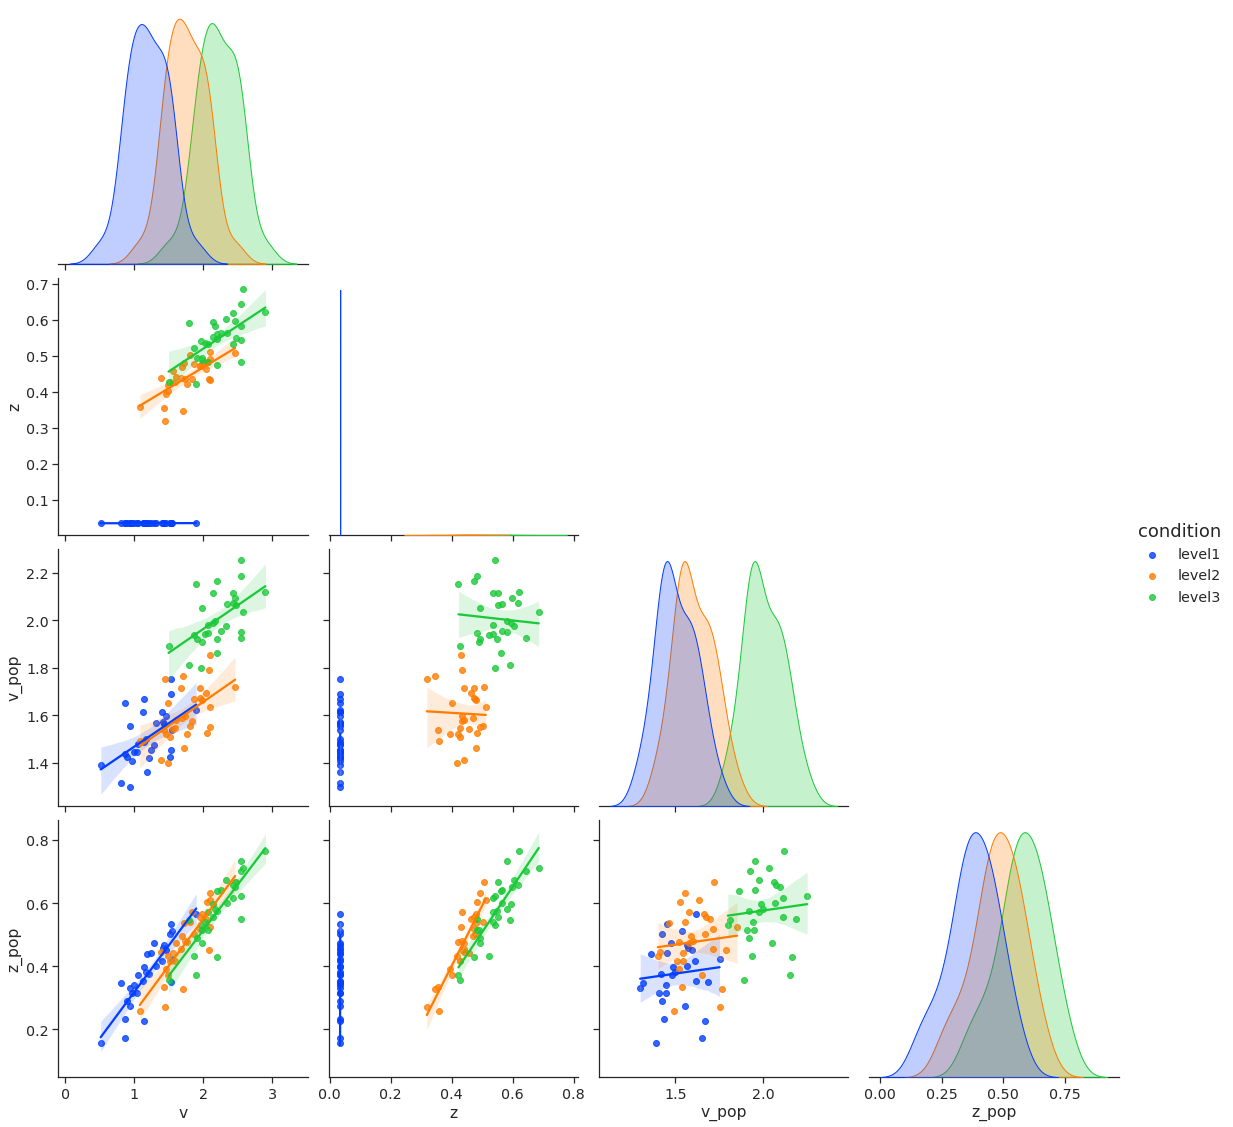

In [26]:
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(df_params_ppc.loc[df_params_ppc['StimType'] == 'left', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright",
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

[None, None]

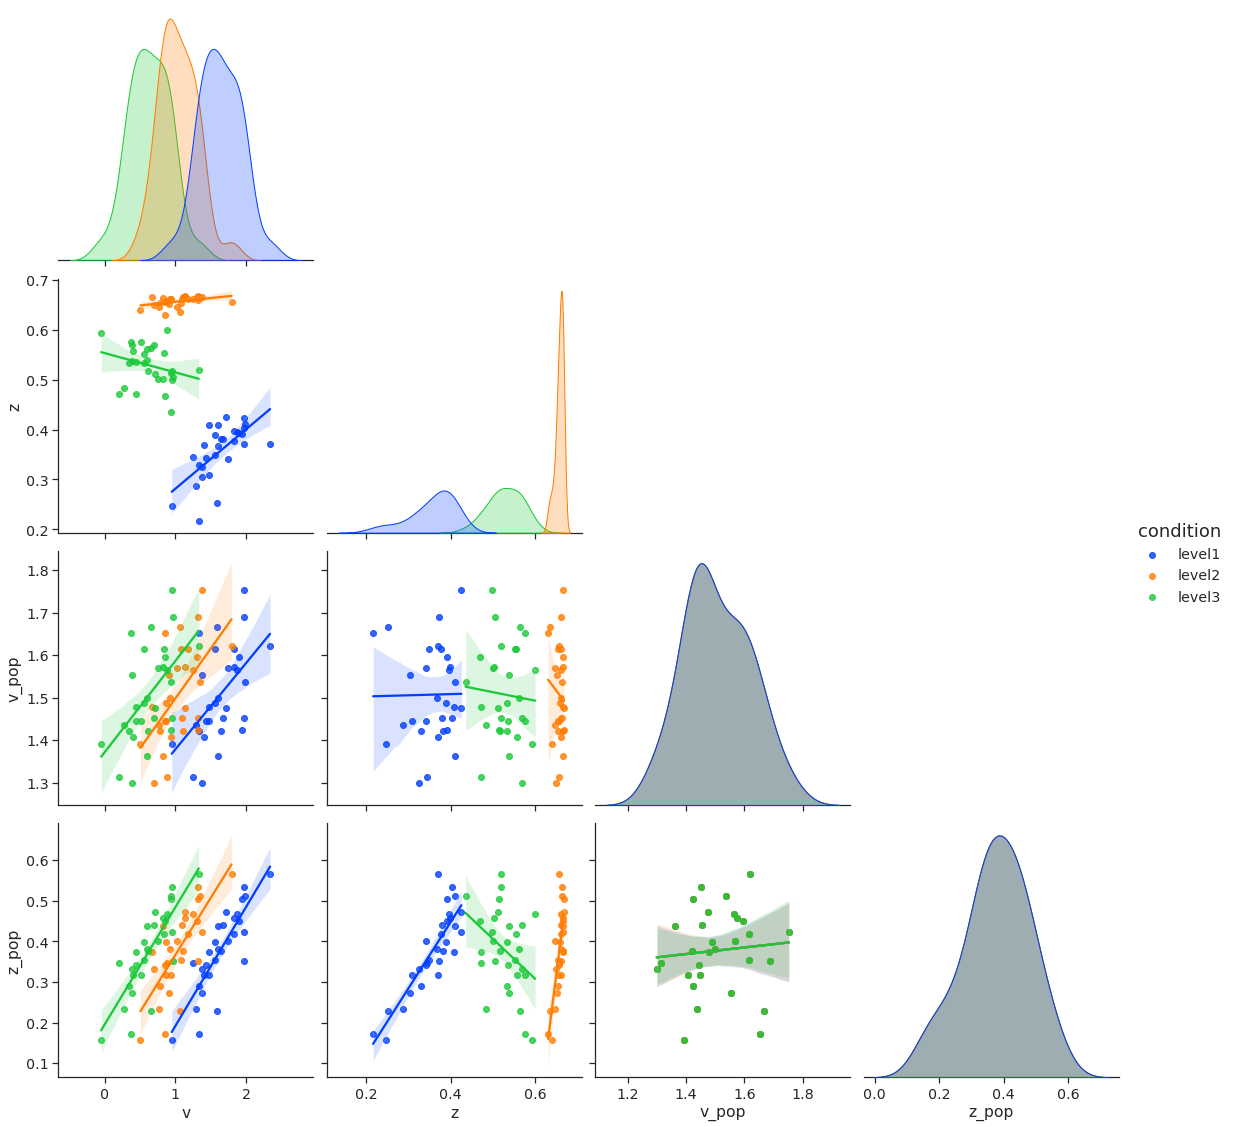

In [27]:
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(df_params_ppc.loc[df_params_ppc['StimType'] == 'right', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright", 
                 #plot_kws=dict(edgecolor='none', alpha=0.5),
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

#### M5: Stim-coding + regressor, Way 1
We treat the data as stimulus-coding with within-subject design. 

In [17]:
def z_link_func(x, data=df_stim):
    stim = (dmatrix('0 + C(s, [[1], [-1]])',
                    {'s':data.stimulus.loc[x.index]},
                    return_type="dataframe")
#    stim = (np.asarray(dmatrix('0 + C(s, [[1], [-1]])',
                               #{'s':data.stimulus.ix[x.index]})) # original .ix is deprecated.
           )
    #print(x.shape)
    return 1/(1+np.exp(-np.multiply(x.to_frame(), stim)))

And, again, we have two ways to model this situation. 

m5 = hddm:HDDMRegressor{ 'v' ~ levels, 'z' ~ levels, link:lamda invlogit_multiplying_sim}

In [ ]:

# z_reg5 = {'model': "z ~ 1 + C(condition,Treatment('level1'))", 
#          'link_func': z_link_func}

# v_reg5 = {'model': "v ~ 1 + C(condition,Treatment('level1'))", 
#          'link_func': lambda x:x}

# reg_descr5 = [z_reg5, v_reg5]

# m5 = hddm.HDDMRegressor(df_stim, reg_descr5, include='z')

# m5.find_starting_values()

# m5.sample(2000, burn=500, dbname='stim_sim_m5.db', db='pickle') 

# # save the model
# m5.save('stim_sim_m5')
# #stim_sim_m5 = hddm.load('stim_sim_m5')

# m5.print_stats()

#### M6: Stim-coding + regressor, Way 2

Alternatively, we assume the data do not satfifying the model assumption, the pseudo code is like:

m6 = hddm:HDDMRegressor{ 'v' ~ stim * levels, 'z' ~ stim * levels, link:lamda invlogit_multiplying_sim}.

In [18]:
z_reg6 = {'model': "z ~ 0 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 
         'link_func': z_link_func}

v_reg6 = {'model': "v ~ 0 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 
         'link_func': lambda x:x}

reg_descr6 = [z_reg6, v_reg6]

# need to try group_only_regressors=False ??
m6 = hddm.HDDMRegressor(df_acc, reg_descr6, group_only_regressors=False, keep_regressor_trace=True, include='z')

m6.find_starting_values()

m6.sample(2000, burn=500, dbname='stim_sim_m6.db', db='pickle') # 20180

# save the model
m6.save('stim_sim_m6')

m6.print_stats()

Adding these covariates:
["z_C(condition, Treatment('level1'))[level1]", "z_C(condition, Treatment('level1'))[level2]", "z_C(condition, Treatment('level1'))[level3]", "z_C(StimType, Treatment('left'))[T.right]", "z_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]", "z_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]"]
Adding these covariates:
["v_C(condition, Treatment('level1'))[level1]", "v_C(condition, Treatment('level1'))[level2]", "v_C(condition, Treatment('level1'))[level3]", "v_C(StimType, Treatment('left'))[T.right]", "v_C(condition, Treatment('level1'))[T.level2]:C(StimType, Treatment('left'))[T.right]", "v_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]"]


/opt/conda/lib/python3.7/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 25727.1 secWARNING: Will not save custom link functions.
                                                                                                    mean         std         2.5q         25q        50q          75q       97.5q       mc err
a                                                                                                2.00881   0.0252914      1.96013     1.99203    2.00865      2.02542     2.05944   0.00107277
a_std                                                                                            0.11044   0.0240709    0.0662071   0.0939779   0.108306     0.125944    0.160283   0.00148573
a_subj.0                                                                                         1.95924   0.0475375      1.86396     1.92708    1.96035      1.98973     2.05472    0.0017639
a_subj.1                                                                                         1.95381   0.052

In [29]:
#m6 = hddm.load('stim_sim_m6')

In [19]:
m = m6
m_traces = m.get_traces()
m_traces.columns[m_traces.columns.str.contains("v_|z_")]

Index(['z_C(condition, Treatment('level1'))[level1]_trans',
       'z_C(condition, Treatment('level1'))[level1]_std',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.0',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.1',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.2',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.3',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.4',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.5',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.6',
       'z_C(condition, Treatment('level1'))[level1]_subj_trans.7',
       ...
       'v_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.20',
       'v_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.21',
       'v_C(condition, Treatment('level1'))[T.level3]:C(StimType, Treatment('left'))[T.right]_subj.22',
       'v_C(condition, 

In [22]:
df_params_ppc = gen_params_comp_reg(m6, df_params)

KeyError: 'v_Intercept_subj.0'

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


[None, None]

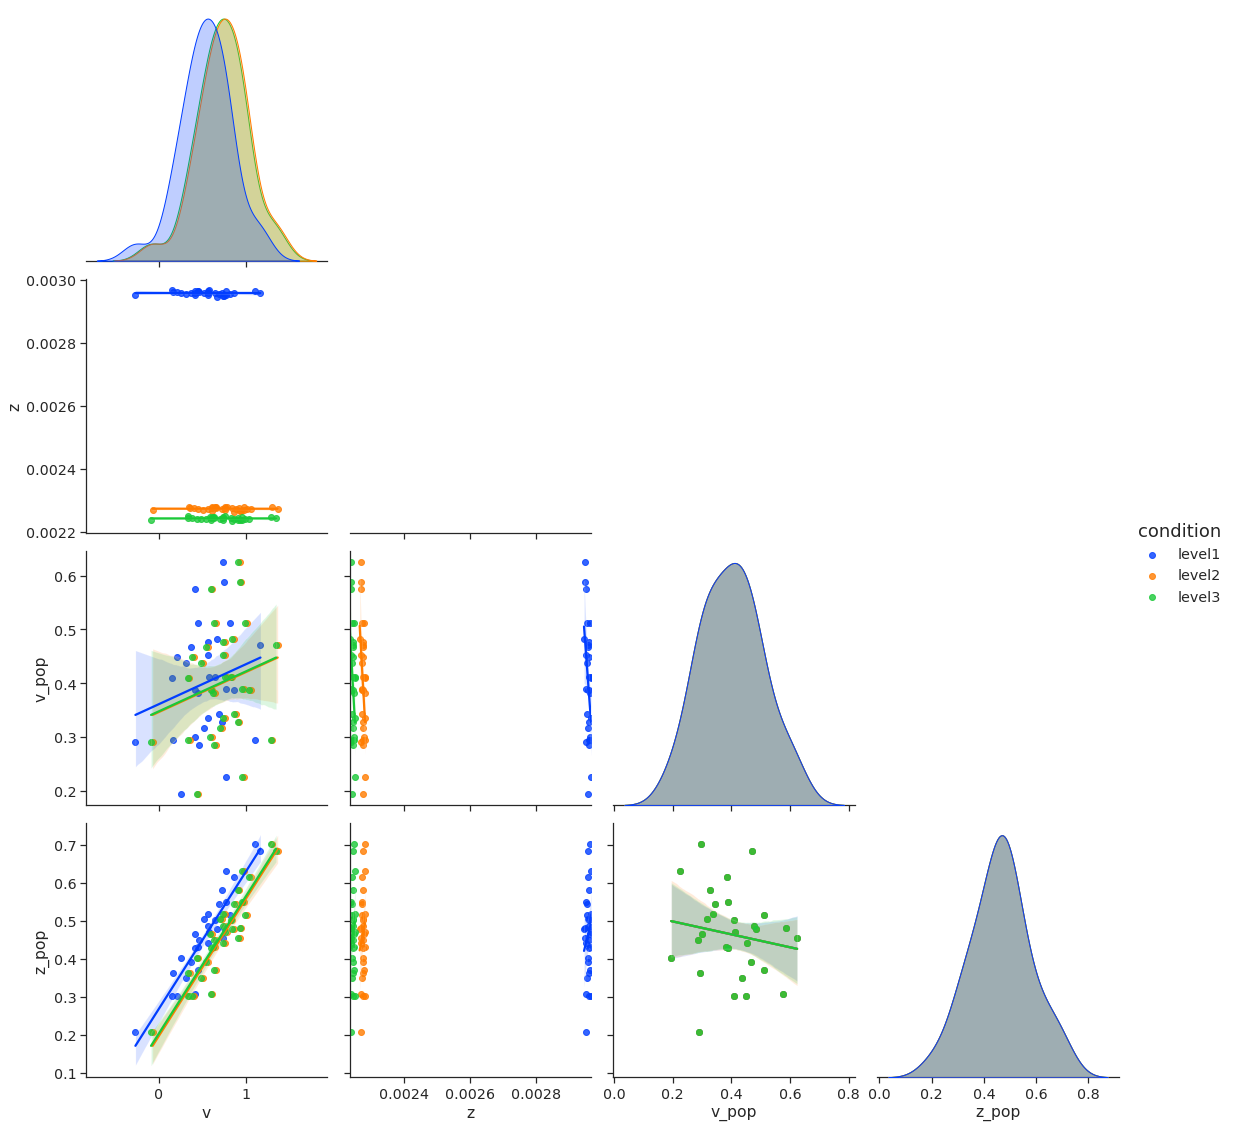

In [16]:
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(df_params_ppc.loc[df_params_ppc['StimType'] == 'left', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright", 
                 #plot_kws=dict(edgecolor='none', alpha=0.5),
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


[None, None]

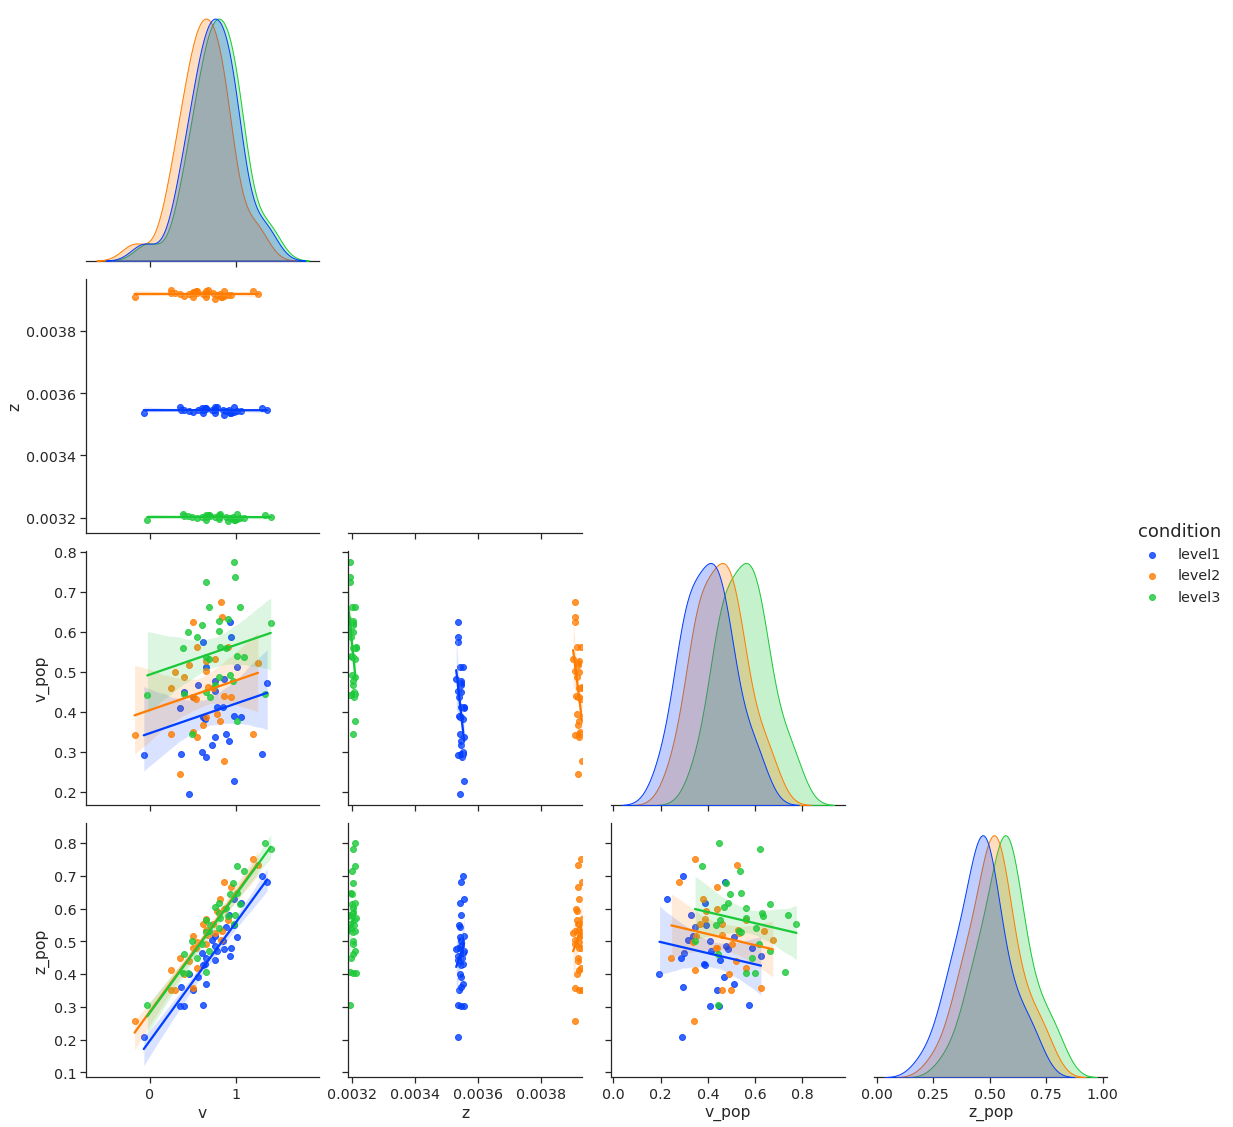

In [17]:
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(df_params_ppc.loc[df_params_ppc['StimType'] == 'right', ['v', 'z', 'v_pop', 'z_pop','condition']], 
                 hue="condition", palette="bright", 
                 #plot_kws=dict(edgecolor='none', alpha=0.5),
                 kind="reg",
                 height = 4, corner=True) # or linewidth=0
plt.setp(g._legend.get_title(), fontsize=18)

## Let's first replicate the tutorial on HDDM website

http://ski.clps.brown.edu/hddm_docs/tutorial_regression_stimcoding.html

In [ ]:
#import sys
# the following will save all the stdout to the txt file, which is not necessary
# sys.stdout = open('ModelRecoveryOutput.txt', 'w')

### Creating simulated data for  the experiment

set number of subjects and number of trials per level for the simulated experiment

In [ ]:
n_subjects = 15
trials_per_level = 150

Next, set up parameters of the DDM for three levels and the first stimulus. 

In [ ]:
# level1a = {'v':.3, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
# level2a = {'v':.4, 'a':2, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}
# level3a = {'v':.5, 'a':2, 't':.3, 'sv':0, 'z':.7, 'sz':0, 'st':0}

level1a = {'v':.3, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level2a = {'v':.3, 'a':2, 't':.3, 'sv':0, 'z':.6, 'sz':0, 'st':0}
level3a = {'v':.3, 'a':2, 't':.3, 'sv':0, 'z':.7, 'sz':0, 'st':0}

Next, set up parameters for the second stimulus, where `v` is the same as for the first stimulus. This is different for `z`. In particular: `z(stimulus_b) = 1 - z(stimulus_a)`. 

In [ ]:
level1b = {'v':.4, 'a':2, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
level2b = {'v':.5, 'a':2, 't':.3, 'sv':0, 'z':.4, 'sz':0, 'st':0}
level3b = {'v':.6, 'a':2, 't':.3, 'sv':0, 'z':.3, 'sz':0, 'st':0}

Now, let's generate data for both stimuli

In [ ]:
random.seed(123)
np.random.seed(123)
data_a, params_a = hddm.generate.gen_rand_data({'level1': level1a,
                                                'level2': level2a,
                                                'level3': level3a},
                                              size=trials_per_level,
                                              subjs=n_subjects)

data_b, params_b = hddm.generate.gen_rand_data({'level1': level1b,
                                                'level2': level2b,
                                                'level3': level3b},
                                              size=trials_per_level,
                                              subjs=n_subjects)

In [ ]:
data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)
data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*2, index=data_a.index)
mydata = data_a.append(data_b,ignore_index=True)

In [ ]:
mydata.head(10)

### Setting up the HDDM regression model

The parameter `z` is bound between `0` and `1`, but the standard linear regression does not generate values between `0` and `1`. Therefore, we use a link-function, here the inverse logit $1/(1+exp(-x))$, which transform values between plus and minus infinity into values ranging from (just above) `0` to (nearly) `1`. [this link function is related to logistic regression].

Next, we need to ensure that bias is $z$ for one stimulus and $1-z$ for the other stimulus. To achive this, we can simply multiply the regression output for one stimulus with $-1$. This is implemented here by dot-multiplying the regression output "x" (which is an array) with equally sized array "stim", which is 1 for all stimulus A trials and -1 for stimulus B trials. We use the `patsy` command `dmatrix` to generate such an array from the stimulus column of our stimulated data.

**Note**
* dot-multiplying is vague here, it should be Hadamard Product, see [here](https://www.tutorialexample.com/understand-numpy-np-multiply-np-dot-and-operation-a-beginner-guide-numpy-tutorial/).

In [ ]:
tmpdata = mydata[mydata['subj_idx'] <= 0]
tmpdata

In [ ]:
stim = (dmatrix('0 + C(s, [[1], [-1]])', 
                {'s':tmpdata.stimulus.loc[tmpdata.index]},
                return_type="dataframe")
        )

#tmp = np.multiply(tmpdata[['stimulus']], stim[:])
tmp = np.multiply(tmpdata.stimulus.loc[tmpdata.index].to_frame(),stim)
#1/(1+np.exp(-((np.asarray(mydata.stimulus.iloc[mydata.index])) * stim)))
type(stim)
#stim.index
#type(mydata.stimulus.iloc[mydata.index])

In [ ]:
tmp

In [ ]:
tmp2 = tmpdata.stimulus.loc[tmpdata.index]
tmp2.to_frame().shape

In [ ]:
# x is a pandas Series, it should be converted to dataframe to do the multiplication.

def z_link_func(x, data=mydata):
    stim = (dmatrix('0 + C(s, [[1], [-1]])',
                    {'s':data.stimulus.loc[x.index]},
                    return_type="dataframe")
#    stim = (np.asarray(dmatrix('0 + C(s, [[1], [-1]])',
                               #{'s':data.stimulus.ix[x.index]})) # original .ix is deprecated.
           )
    #print(x.shape)
    return 1/(1+np.exp(-np.multiply(x.to_frame(), stim)))
    #return 1 /( 1+np.exp(-(x * stim)))

In [ ]:
# x is a pandas Series, it should be converted to dataframe to do the multiplication.

def v_link_func(x, data=mydata):
    stim = (dmatrix('0 + C(s, [[1], [-1]])',
                    {'s':data.stimulus.loc[x.index]},
                    return_type="dataframe")
#    stim = (np.asarray(dmatrix('0 + C(s, [[1], [-1]])',
                               #{'s':data.stimulus.ix[x.index]})) # original .ix is deprecated.
           )
    #print(x.shape)
    return np.multiply(x.to_frame(), stim)
    #return 1 /( 1+np.exp(-(x * stim)))

Now, we set up the regression models for `z` and `v` and also include the link functions. The relevant string here used by `patsy` is `1 + C(condition)`. This will generate a design matrix with an intercept (that's what the `1` is for) and two dummy variables for remaining levels. (The column in which the levels are coded has the default name `condition`):

**NOTE: there is only one variable used in the modelling** 

In [ ]:
z_reg = {'model': 'z ~ 1 + C(condition)', 'link_func':z_link_func}

For `v` the link function is simply $x = x$, b/c no transformation is needed. (However, you could also analyze this experiment with response coded data. Then you would not stimulus code `z` but `v` and you would have to multiply the `v` for one condition with `-1`, with a link function like the one for `z`, but without the additional logit transform):

In [ ]:
v_reg = {'model': 'v ~ 1 + C(condition)', 'link_func': lambda x:x}

Now, we can finally put the regression description for the hddm model together. The general for this is `[{'model': 'outcome_parameter ~ patsy_design_string', 'link_func': your_link_func}, {...}, ...]`

In [ ]:
reg_descr = [z_reg, v_reg]

The last step before running the model is to construct the complete hddm regression model by adding data etc.

In [ ]:
m_reg = hddm.HDDMRegressor(mydata, reg_descr, include='z')

Now, we start the sampling, which takes a long time

In [ ]:
m_reg.sample(1000, burn=200, dbname='within_effect.db', db='pickle') 

In [ ]:
m_reg.save('within_effect')

In [ ]:
m_reg.plot_posteriors()

In [ ]:
m_reg.print_stats()

In [ ]:
v_reg2 = {'model': 'v ~ 1 + C(condition)', 'link_func': v_link_func}

In [ ]:
reg_descr2 = [z_reg, v_reg2]
m_reg2 = hddm.HDDMRegressor(mydata, reg_descr2, include='z')
m_reg2.sample(1000, burn=200, dbname='within_effect2.db', db='pickle') 
m_reg2.save('within_effect2')

In [ ]:
m_reg2.print_stats()

**What if we model as I did?**

First, add the reponse type as an other variable

In [ ]:
mydata2 = mydata
# df.loc[df['salary'] > 50, 'is_rich'] = 'yes'
# https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
# df['hasimage'] = np.where(df['photos']!= '[]', True, False) 
mydata2['StimType'] = np.where(mydata2['stimulus'] == 1.0, 'left', 'right')
# mydata2.loc[mydata2['stimulus'] == 0,'StimType'] = 'right'

In [ ]:
mydata2.head(10)

In [ ]:
z_reg2 = {'model': "z ~ 1 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 'link_func':z_link_func}
v_reg2 = {'model': "v ~ 1 + C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 'link_func': lambda x:x}
reg_descr2 = [z_reg2, v_reg2]

In [ ]:
# check the design matrix
dmatrix("C(condition,Treatment('level1')) * C(StimType, Treatment('left'))", 
        {'condition':mydata2['condition'], 'StimType':mydata2['StimType']})


In [ ]:
m_reg2 = hddm.HDDMRegressor(mydata2, reg_descr2, include='z')

In [ ]:
m_reg2.sample(1000, burn=200, dbname='within_effect2.db', db='pickle') 
m_reg2.save('within_effect2')
m_reg2.plot_posteriors()

In [ ]:
m_reg2 = hddm.load("within_effect2")

In [ ]:
m_reg2_trace = m_reg2.get_group_traces()
print(m_reg2_trace.shape)
m_reg2_trace.head(10)

In [ ]:
# rename the columns
import re

lst = ["v_", "z_", "t(", 'cha']
esc_lst = [re.escape(s) for s in lst]
pattern = '|'.join(esc_lst)

# select v, a, t, and chains
slct_columns = m_reg2_trace.columns[m_reg2_trace.columns.str.contains(pattern, case=False)]

slct_columns = [ x for x in slct_columns if "std" not in x ]

df_tmp = m_reg2_trace[slct_columns]
df_tmp.head(10)

In [ ]:
df_tmp.columns = ['z_intercept', 'z_effect_L2', 'z_effect_L3', 'z_effect_left', 'z_L2:left', 'z_L3:left',
                  'v_intercept', 'v_effect_L2', 'v_effect_L3', 'v_effect_left', 'v_L2:left', 'v_L3:left'] 
df_tmp.head(10)

In [ ]:
df_tmp.loc[:,'v_L1_left'] = df_tmp.loc[:,'v_intercept'].copy()
df_tmp.loc[:,'v_L2_left']  = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_L2'].copy()
df_tmp.loc[:,'v_L3_left'] = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_L3'].copy()
df_tmp.loc[:,'v_L1_right']  = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_left'].copy()
df_tmp.loc[:,'v_L2_right']   = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_left'].copy() + df_tmp.loc[:, 'v_L2:left'].copy()
df_tmp.loc[:,'v_L3_right']  = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_left'].copy() + df_tmp.loc[:, 'v_L3:left'].copy()


In [ ]:
df_tmp.head()

In [ ]:
df_tmp_v = df_tmp[['v_L1_left', 'v_L2_left', 'v_L3_left', 'v_L1_right', 'v_L2_right', 'v_L3_right']]
df_tmp_v.head(10)

In [ ]:
df_tmp_v.plot.density(figsize=(8,6),xlim=(-2.5, 3.5),linewidth=3)

### Comparing generative and recovered model parameters
First, let's print the model stats

In [ ]:
m_reg.print_stats()

## Working with real data

Now let's move to the real data. 

I will use 1b as the example because it includes many scale data. I'd like to try whether we can add these scores as an group-level predictor.


I will first model the data as the tutorial about within-subject design and stimulus-coding, then I will add the self-esteem as an additional regressor.

In [ ]:
# load data
df1b = hddm.load_csv('df1bv.hddm_stim.reg.csv')
df = df1b

# randomly chose 10 participants from the dataset
df_subj = df['subj_idx'].unique()
random.seed(10)
df_test_list = []
for i in range(10):
    pos = random.randint(0, (len(df_subj)-1))
    df_test_list.append(df_subj[pos])  

df_test = df[df['subj_idx'].isin(df_test_list)]

In [ ]:
df_test.head(10)

In [ ]:
# create a link func for z
def z_link_func(x, data=df_test):
    stim = (dmatrix('0 + C(s, [[1], [-1]])',
                    {'s':data.stim.loc[x.index]},
                    return_type="dataframe")
           )
    return 1/(1+np.exp(-np.multiply(x.to_frame(), stim)))

### Stimulus coding in regressor

This time, explicitly used `C` to indicate the independent variables are categorical.

In [ ]:
z_reg = {'model': "z ~ 1 + C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", 'link_func': z_link_func}

In [ ]:
# check the design matrix
# without self-esteem as a regressor
dmatrix("C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", {'match':df_test['match'], 'val':df_test['val']})

# with self-esteem as regressor
#dmatrix("SlfEst_sum:C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", {'SlfEst_sum':df_test['SlfEst_sum'], 'match':df_test['match'], 'val':df_test['val']})

In [ ]:
z_reg = {'model': "z ~ 1 + C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", 'link_func': z_link_func}
v_reg = {'model': "v ~ 1 + C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", 'link_func': lambda x:x}
a_reg = {'model': "a ~ 1 + C(match,Treatment('Mismatch')) * C(val, Treatment('Neutral'))", 'link_func': lambda x:x}

reg_descr = [z_reg, v_reg, a_reg]

m_reg = hddm.HDDMRegressor(df_test, v_reg, include='z')

In [ ]:
start_time = time.time()   # the start time of the processing

m_reg.sample(5000, burn=1000, dbname='df1_within_effect_try.db', db='pickle') 

print("\nRunning within model of exp 1a (10 subj) used: %f seconds" % (time.time() - start_time)) # print the elapse of time

In [ ]:
m_reg.save('df1_within_effect_try')

In [ ]:
m_reg.plot_posteriors()

In [ ]:
print("m_reg DIC: %f" % m_reg.dic) 

In [ ]:
stats = m_reg.gen_stats()
stats

In [ ]:
v_nmn, v_nmg, v_nmb = m_reg.nodes_db.loc[["v_Intercept",
                                              "v_C(val, Treatment('Neutral'))[T.Bad]",
                                              "v_C(val, Treatment('Neutral'))[T.Good]"], 'node']
#v_nmg = v_nmn + v_nmg
#v_nmb = v_nmn + v_nmb
hddm.analyze.plot_posterior_nodes([v_nmn, v_nmg, v_nmb])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

In [ ]:
v_mn, v_mg, v_mb = m_reg.nodes_db.loc[["v_C(match, Treatment('Mismatch'))[T.Match]",
                                              "v_C(match, Treatment('Mismatch'))[T.Match]:C(val, Treatment('Neutral'))[T.Bad]",
                                              "v_C(match, Treatment('Mismatch'))[T.Match]:C(val, Treatment('Neutral'))[T.Good]"], 'node']
#v_nmg = v_nmn + v_nmg
#v_nmb = v_nmn + v_nmb
hddm.analyze.plot_posterior_nodes([v_mn, v_mg, v_mb])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

In [ ]:
m_reg_trace = m_reg.get_group_traces()
print(m_reg_trace.shape)

In [ ]:
m_reg_trace.head(10)

In [ ]:
# rename the columns
import re

lst = ["v_", "a(", "t(", 'cha']
esc_lst = [re.escape(s) for s in lst]
pattern = '|'.join(esc_lst)

# select v, a, t, and chains
slct_columns = m_reg_trace.columns[m_reg_trace.columns.str.contains(pattern, case=False)]

slct_columns = [ x for x in slct_columns if "std" not in x ]

df_tmp = m_reg_trace[slct_columns]
df_tmp.head(10)

In [ ]:
df_tmp.columns = ['v_intercept', 'v_effect_Match', 'v_effect_NM_Bad', 'v_effect_NM_Good', 'v_Match:Bad', 'v_Match:Good'] 
df_tmp.head(10)

In [ ]:
df_tmp.loc[:,'NM_Neut'] = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_NM_Bad'].copy()

In [ ]:
df_tmp.loc[:,'NM_Neut'] = df_tmp.loc[:,'v_intercept'].copy()
df_tmp.loc[:,'NM_Bad']  = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_NM_Bad'].copy()
df_tmp.loc[:,'NM_Good'] = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_NM_Good'].copy()
df_tmp.loc[:,'M_Neut']  = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_Match'].copy()
df_tmp.loc[:,'M_Bad']   = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_Match'].copy() + df_tmp.loc[:, 'v_Match:Bad'].copy()
df_tmp.loc[:,'M_Good']  = df_tmp.loc[:,'v_intercept'].copy() + df_tmp.loc[:, 'v_effect_Match'].copy() + df_tmp.loc[:, 'v_Match:Good'].copy()


In [ ]:
df_tmp = df_tmp.loc[:, ['NM_Neut', 'NM_Bad', 'NM_Good', 'M_Neut', 'M_Bad', 'M_Good']]
df_tmp.head(10)

In [ ]:
df_tmp.plot.density(figsize=(8,6),xlim=(-2.5, 3.5),linewidth=3)

In [ ]:


df_tmp["id"] = df_tmp.index
# df_tmp.head()
print('Shape of the wide format', df_tmp.shape)

df_melt = pd.melt(df_tmp,
                  id_vars=['id'],
                  value_vars=['NM_Neut', 'NM_Bad', 'NM_Good', 'M_Neut', 'M_Bad', 'M_Good'],
                  var_name='cond',
                  value_name='value')

#type(df_melt)
print('Shape of the long format', df_melt.shape)
df_melt.head()

In [ ]:
# split the cond column into three columns
df_melt[['Matchness','Valence']] = pd.DataFrame(df_melt['cond'].apply(lambda x: [i for i in re.split(r'[\_\.]', x) if len(i)>0]).to_list())
df_melt.head()

In [ ]:
df_melt['cond_c'] = pd.Categorical(df_melt['cond'], categories=['NM_Bad', 'NM_Neut', 'NM_Good', 'M_Bad', 'M_Neut',  'M_Good'])

import seaborn as sns
sns.kdeplot(data=df_melt, x="value", hue="cond_c")